In [1]:
suppressPackageStartupMessages({
    library(NanoStringNCTools)
    library(fpc)
    library(plotly)
    library(knitr)
    library(GeomxTools)
    library(GeoMxWorkflows)
    library(ggplot2)
    library(scales)
    library(dplyr)
    library(ggforce)
    library(reshape2)
    library(readxl)
    library(gplots)
    library(grid)
    library(gridExtra)
    library(plyr)
    library(openxlsx)
    library(DESeq2)
    library(lme4)
    library(AnnotationDbi)
    library(org.Hs.eg.db)
    library(clusterProfiler)
    library(png)
    library(ggforce)
    library(tidyverse)
    library(edgeR)
    library(aliases2entrez)
    library(biomaRt)
    HGNC <- update_symbols()
    library(stringr)
    library(GSVA)
    library(GSEABase)
    library(limma)
    library(msigdbr)
    library(ComplexHeatmap)
    library(circlize)
    library(RColorBrewer)
    library(ggplot2)
    library(ggpubr)
    library(reshape2)  # for melt
    library(cowplot)   # for plot_grid
    library(tidyverse)
    library(ggrepel)
    library(readODS)
    library(knitr)
    library(kableExtra)
    library(openxlsx)

    # source('/home/dimitris/Workspace/crc/scripts/geomx_helper_functions.R')
})

cd45_color = '#F8766D'
ck_color = '#00BA38'
cd68_color = '#619CFF'
options(repr.plot.width=NULL, repr.plot.height=NULL)


Warning message:
“package ‘NanoStringNCTools’ was built under R version 4.4.2”
Warning message:
“package ‘Biobase’ was built under R version 4.4.2”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.4.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.4.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘knitr’ was built under R version 4.4.3”
Warning message:
“package ‘GeomxTools’ was built under R version 4.4.2”
Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘DESeq2’ was built under R version 4.4.3”
Warning message:
“package ‘IRanges’ was built under R version 4.4.2”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.4.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.4.2”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.4.2”
Warning message:
“package ‘MatrixGenerics’ was built under R ve

In [2]:
df <- readxl::read_excel("/home/dimitris/Workspace/crc/geomx_crc/annotations.xlsx")
df$location <- ifelse(df$segment == 'CK' ,'intra-tumor',df$location) # POSSIBLE MISTAKE IN ANNOTATIONS CK SEGMENTS ANNOTATED AS NORMAL
openxlsx::write.xlsx(df, file = "/home/dimitris/Workspace/crc/geomx_crc/geomx_annotations.xlsx")

# Load Data

In [3]:
DCCFiles <- dir(file.path("/home/dimitris/Workspace/crc/geomx_crc/dccs_2"), pattern = ".dcc$",
                full.names = TRUE, recursive = TRUE)
PKCFiles <- file.path("/home/dimitris/Workspace/crc/geomx_crc/Hs_R_NGS_WTA_v1.0.pkc")
SampleAnnotationFile <- "/home/dimitris/Workspace/crc/geomx_crc/geomx_annotations.xlsx"

# load data
demoData <- readNanoStringGeoMxSet(dccFiles = DCCFiles,
                           pkcFiles = PKCFiles,
                           phenoDataFile = SampleAnnotationFile,
                           phenoDataSheet = "Sheet 1",
                           phenoDataDccColName = "Sample_ID",
                           protocolDataColNames = c("aoi"),
                           experimentDataColNames = c("panel"))


pkcs <- annotation(demoData)
modules <- gsub(".pkc", "", pkcs)
kable(data.frame(PKCs = pkcs, modules = modules))

Warning message in readNanoStringGeoMxSet(dccFiles = DCCFiles, pkcFiles = PKCFiles, :
“Annotations missing for the following: DSP-1001660011456-E-A01.dcc, These will be excluded from the GeoMxSet object.”




|PKCs                  |modules           |
|:---------------------|:-----------------|
|Hs_R_NGS_WTA_v1.0.pkc |Hs_R_NGS_WTA_v1.0 |

In [4]:
demoData$location <- ifelse(demoData$location == 'front' ,'border',demoData$location)
demoData$mucinous <- ifelse(pData(demoData)$mucinous == 'true','mucinous','non-mucinous')
demoData <- demoData[,pData(demoData)$location == 'intra-tumor' & pData(demoData)$`slide name` %in% c('21H03592-11 metastase #1 13-10-22','21H09328.13 COLON METASTASE 13.09.22','21H05698-33 Meta#4 06-10-22')]
demoData$treatment_response <- NA
demoData$treatment_response <- ifelse(pData(demoData)$`slide name` == '21H03592-11 metastase #1 13-10-22' , 'naive' , pData(demoData)$treatment_response)
demoData$treatment_response <- ifelse(pData(demoData)$`slide name` == '21H09328.13 COLON METASTASE 13.09.22' , 'progressor' , pData(demoData)$treatment_response)
demoData$treatment_response <- ifelse(pData(demoData)$`slide name` == '21H05698-33 Meta#4 06-10-22' , 'responder' , pData(demoData)$treatment_response)

In [5]:
# Shift counts to one
demoData <- shiftCountsOne(demoData, useDALogic = TRUE)

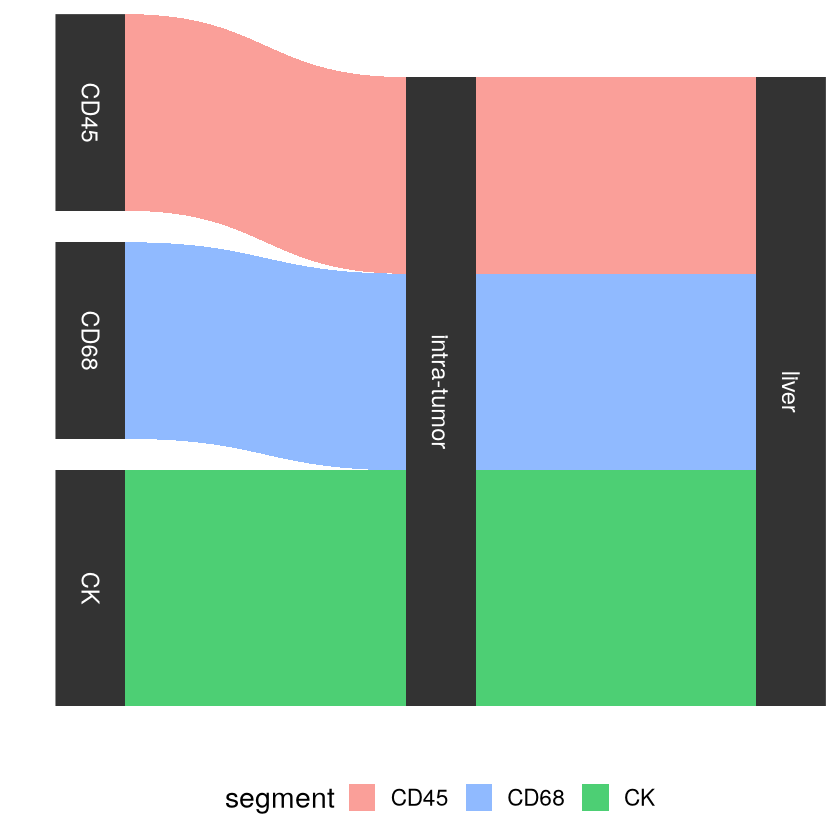

In [6]:
sankey_plot <- function(df,columns){
data <- table(df[,columns])
data <- reshape2::melt(data)
data <- gather_set_data(data, 1:3)
# Create the parallel sets diagram
ggplot(data, aes(x, id = id, split = y,value=value)) +
 geom_parallel_sets(aes(fill = segment), alpha = .7, axis.width = 0.2,sep = 0.05) +
 geom_parallel_sets_axes(axis.width = 0.2,sep = 0.05) +
 scale_fill_manual(values = c("CK" = ck_color, "CD45" = cd45_color,'CD68'=cd68_color)) +
    geom_parallel_sets_labels(color = "white", size = 5) +
    theme_classic(base_size = 17) + 
    theme(legend.position = "bottom",
          axis.ticks.y = element_blank(),
          axis.line = element_blank(),
          axis.text.y = element_blank()) +
    scale_y_continuous(expand = expansion(0)) + 
    scale_x_discrete(expand = expansion(0)) +
    labs(x = "", y = "") 
    }
sankey_plot(pData(demoData),c('segment','location','tissue'))

# QC & Pre-processing

## Select Segment QC

In [7]:
###### Default QC cutoffs are commented in () adjacent to the respective parameters
# study-specific values were selected after visualizing the QC results in more
# detail below
QC_params <-
        list(minSegmentReads = 1000, # Minimum number of reads (1000)
             percentTrimmed = 80,    # Minimum % of reads trimmed (80%)
             percentStitched = 80,   # Minimum % of reads stitched (80%)
             percentAligned = 75,    # Minimum % of reads aligned (80%)
             percentSaturation = 50, # Minimum sequencing saturation (50%)
             minNegativeCount = 1,   # Minimum negative control counts (10)
             maxNTCCount = 9000,     # Maximum counts observed in NTC well (1000)
             minNuclei = 20,         # Minimum # of nuclei estimated (100)
             minArea = 1000)         # Minimum segment area (5000)
demoData <-
        setSegmentQCFlags(demoData, 
                          qcCutoffs = QC_params)        

# Collate QC Results
QCResults <- protocolData(demoData)[["QCFlags"]]
flag_columns <- colnames(QCResults)
QC_Summary <- data.frame(Pass = colSums(!QCResults[, flag_columns]),
                         Warning = colSums(QCResults[, flag_columns]))
QCResults$QCStatus <- apply(QCResults, 1L, function(x) {
                                    ifelse(sum(x) == 0L, "PASS", "WARNING")
                         })
QC_Summary["TOTAL FLAGS", ] <-
        c(sum(QCResults[, "QCStatus"] == "PASS"),
          sum(QCResults[, "QCStatus"] == "WARNING"))

## Visualize Segment QC

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


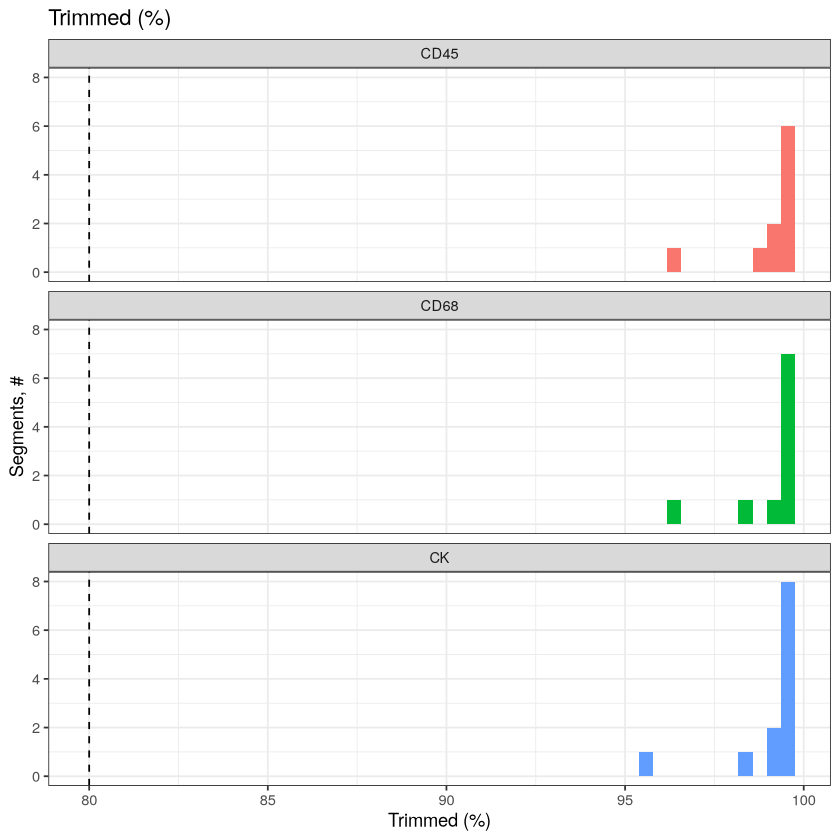

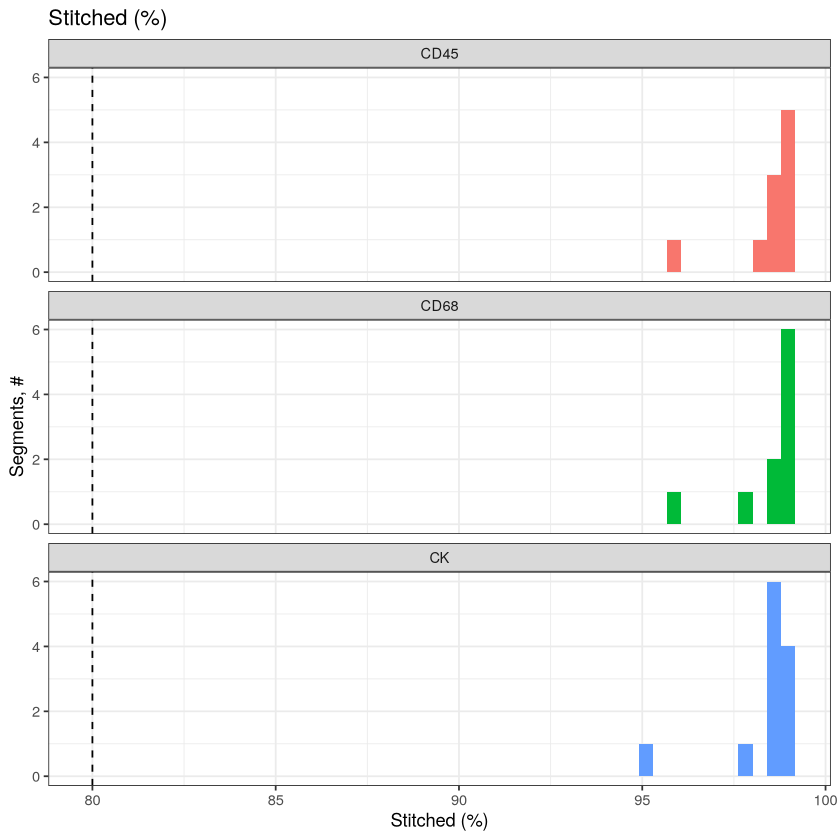

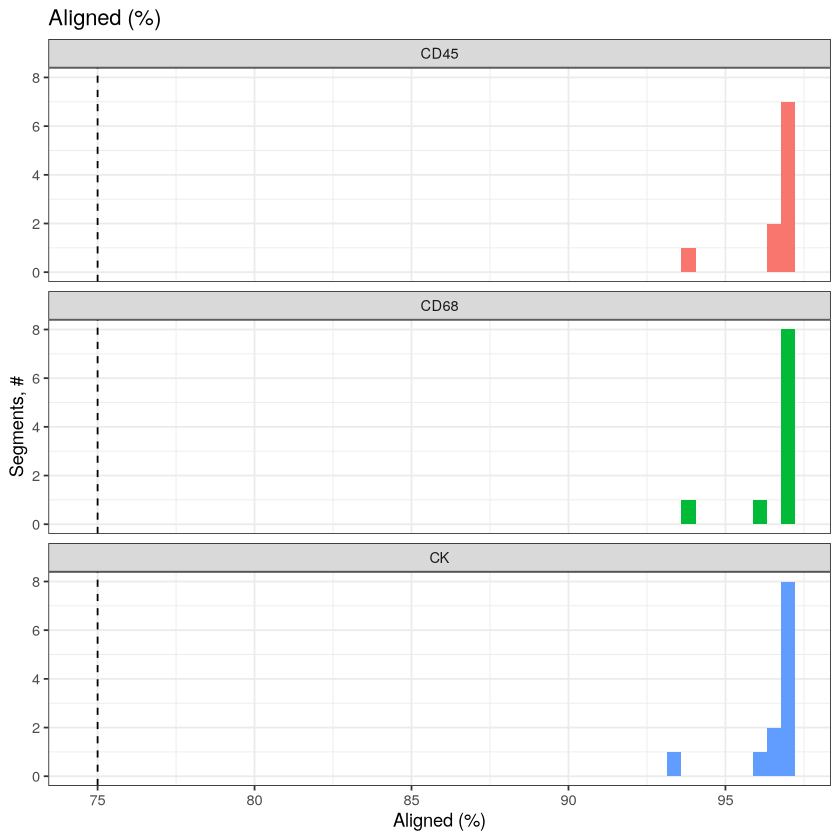

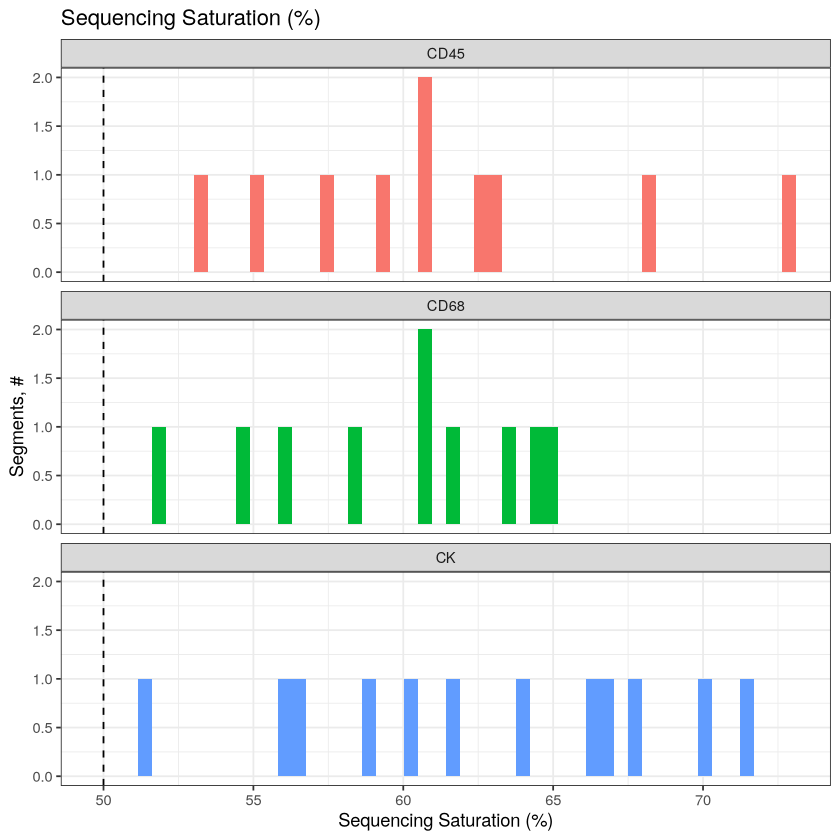

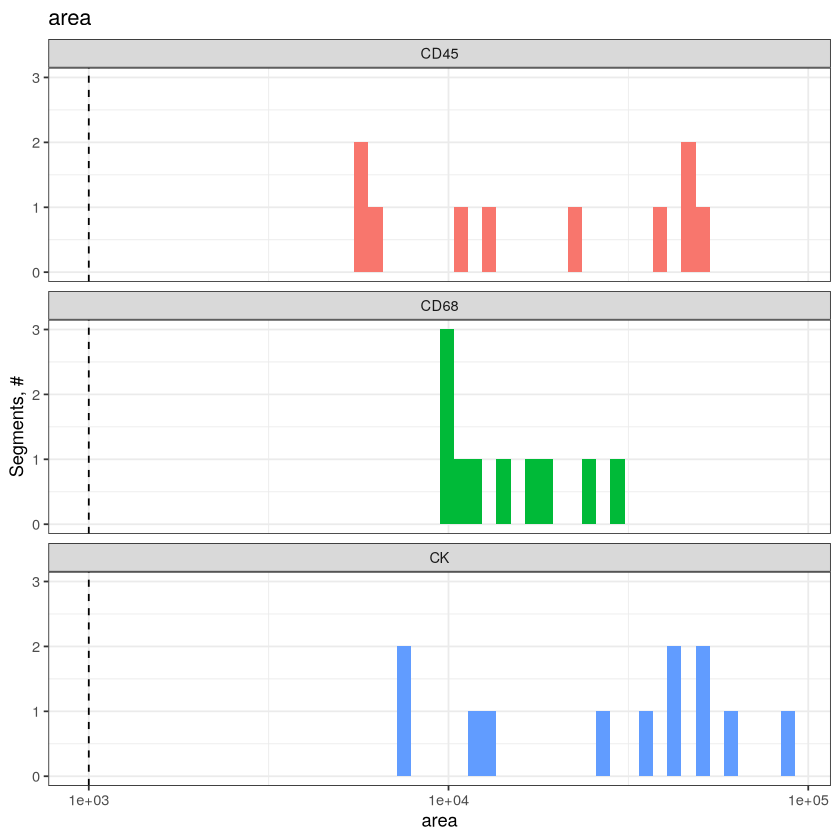



|NTC Count | # of Segments|
|:---------|-------------:|
|6         |            14|
|28        |            12|
|221       |             6|



Table: QC Summary Table for each Segment

|              | Pass| Warning|
|:-------------|----:|-------:|
|LowReads      |   32|       0|
|LowTrimmed    |   32|       0|
|LowStitched   |   32|       0|
|LowAligned    |   32|       0|
|LowSaturation |   32|       0|
|LowNegatives  |   32|       0|
|HighNTC       |   32|       0|
|LowArea       |   32|       0|
|TOTAL FLAGS   |   32|       0|

Features  Samples 
   18815       32

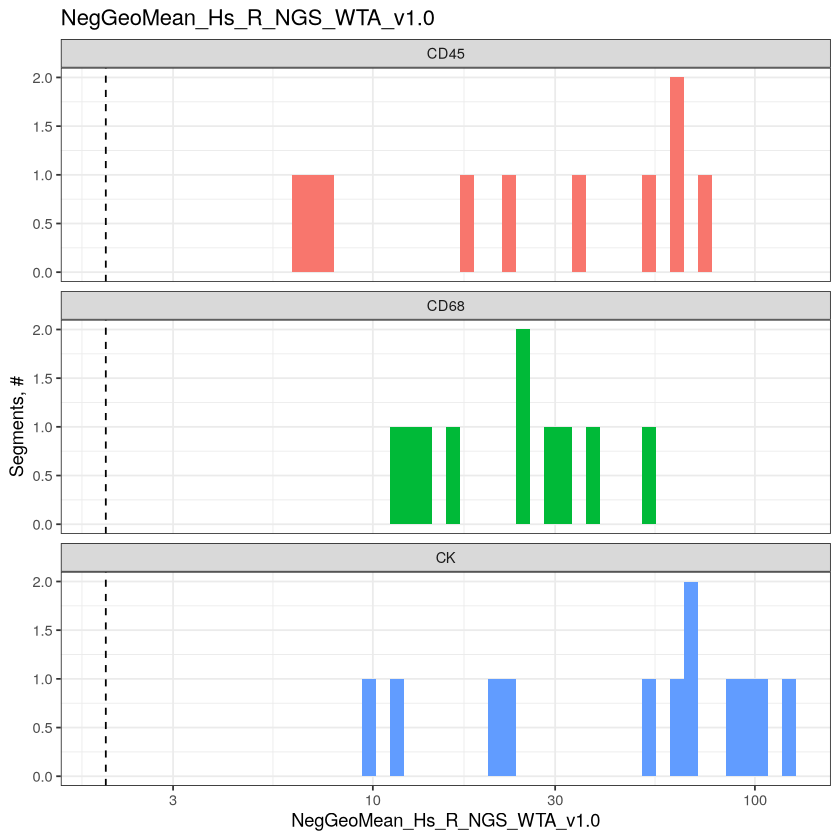

In [8]:
col_by <- "segment"

# Graphical summaries of QC statistics plot function
QC_histogram <- function(assay_data = NULL,
                         annotation = NULL,
                         fill_by = NULL,
                         thr = NULL,
                         scale_trans = NULL) {
        plt <- ggplot(assay_data,
                      aes_string(x = paste0("unlist(`", annotation, "`)"),
                                 fill = fill_by)) +
        geom_histogram(bins = 50) +
        geom_vline(xintercept = thr, lty = "dashed", color = "black") +
        theme_bw() + guides(fill = "none") +
        facet_wrap(as.formula(paste("~", fill_by)), nrow = 4) +
        labs(x = annotation, y = "Segments, #", title = annotation)
        if(!is.null(scale_trans)) { 
                plt <- plt + scale_x_continuous(trans = scale_trans) 
                }
                plt
        }

QC_histogram(sData(demoData), "Trimmed (%)", col_by, 80)
QC_histogram(sData(demoData), "Stitched (%)", col_by, 80)
QC_histogram(sData(demoData), "Aligned (%)", col_by, 75)
QC_histogram(sData(demoData), "Saturated (%)", col_by, 50) +
            labs(title = "Sequencing Saturation (%)",
                          x = "Sequencing Saturation (%)")
QC_histogram(sData(demoData), "area", col_by, 1000, scale_trans = "log10")
#QC_histogram(sData(demoData), "nuclei", col_by, 20)
# calculate the negative geometric means for each module
negativeGeoMeans <- 
            esBy(negativeControlSubset(demoData), 
                 GROUP = "Module", 
                 FUN = function(x) { 
                         assayDataApply(x, MARGIN = 2, FUN = ngeoMean, elt = "exprs") 
                 }) 

protocolData(demoData)[["NegGeoMean"]] <- negativeGeoMeans

# explicitly copy the Negative geoMeans from sData to pData
negCols <- paste0("NegGeoMean_", modules)
pData(demoData)[, negCols] <- sData(demoData)[["NegGeoMean"]]
for(ann in negCols) {
            plt <- QC_histogram(pData(demoData), ann, col_by, 2, scale_trans = "log10")
    print(plt)
}

# detatch neg_geomean columns ahead of aggregateCounts call
pData(demoData) <- pData(demoData)[, !colnames(pData(demoData)) %in% negCols]

# show all NTC values, Freq = # of Segments with a given NTC count:
kable(table(NTC_Count = sData(demoData)$NTC),
            col.names = c("NTC Count", "# of Segments"))

kable(QC_Summary, caption = "QC Summary Table for each Segment")
demoData <- demoData[, QCResults$QCStatus == "PASS"]
# Subsetting our dataset has removed samples which did not pass QC

dim(demoData)

# Probe QC

## Set Probe QC Flags

In [9]:
# Generally keep the qcCutoffs parameters unchanged. Set removeLocalOutliers to 
# FALSE if you do not want to remove local outliers
demoData <- setBioProbeQCFlags(demoData, 
                               qcCutoffs = list(minProbeRatio = 0.1,
                                                percentFailGrubbs = 20), 
                               removeLocalOutliers = TRUE)

ProbeQCResults <- fData(demoData)[["QCFlags"]]

# Define QC table for Probe QC
qc_df <- data.frame(Passed = sum(rowSums(ProbeQCResults[, -1]) == 0),
                    Global = sum(ProbeQCResults$GlobalGrubbsOutlier),
                    Local = sum(rowSums(ProbeQCResults[, -2:-1]) > 0
                                & !ProbeQCResults$GlobalGrubbsOutlier))
kable(qc_df)



| Passed| Global| Local|
|------:|------:|-----:|
|  18811|      0|     4|

## Exclude Outlier Probes

In [10]:
#Subset object to exclude all that did not pass Ratio & Global testing
ProbeQCPassed <- 
        subset(demoData, 
               fData(demoData)[["QCFlags"]][,c("LowProbeRatio")] == FALSE &
                       fData(demoData)[["QCFlags"]][,c("GlobalGrubbsOutlier")] == FALSE)
print("Probe QC Passed")
print(dim(ProbeQCPassed))
demoData <- ProbeQCPassed

[1] "Probe QC Passed"
Features  Samples 
   18815       32 


# Create Gene-level Count Data

In [11]:
# Check how many unique targets the object has
length(unique(featureData(demoData)[["TargetName"]]))

# collapse to targets
print(" collapse to targets ")
target_demoData <- aggregateCounts(demoData)

dim(target_demoData)
print("dim(target_demoData) before filtering")
print(dim(target_demoData))

print("Create Gene-level Count Data ")
exprs(target_demoData)[1:5, 1:2]
dim(pData(target_demoData))
pData(target_demoData)[1:3,]

# Limit of Quantification

# Define LOQ SD threshold and minimum value
cutoff <- 2
minLOQ <- 2

# Calculate LOQ per module tested
LOQ <- data.frame(row.names = colnames(target_demoData))
for(module in modules) {
    vars <- paste0(c("NegGeoMean_", "NegGeoSD_"),
                   module)
    if(all(vars[1:2] %in% colnames(pData(target_demoData)))) {
        LOQ[, module] <-
            pmax(minLOQ,
                 pData(target_demoData)[, vars[1]] * 
                     pData(target_demoData)[, vars[2]] ^ cutoff)
    }
}
# Create a new column initialized with NA

pData(target_demoData) <- cbind(pData(target_demoData), LOQ)
# pData(target_demoData)

[1] 18677

[1] " collapse to targets "


Features  Samples 
   18677       32

[1] "dim(target_demoData) before filtering"
Features  Samples 
   18677       32 
[1] "Create Gene-level Count Data "


DSP-1001660005664-D-C10.dcc DSP-1001660005664-D-C11.dcc
A2M   137                         318                        
NAT2   83                         164                        
ACADM 113                         261                        
ACADS 110                         283                        
ACAT1 118                         241

[1] 32 11

slide name                           roi segment
DSP-1001660005664-D-C10.dcc 21H09328.13 COLON METASTASE 13.09.22 001 CK     
DSP-1001660005664-D-C11.dcc 21H09328.13 COLON METASTASE 13.09.22 002 CK     
DSP-1001660005664-D-C12.dcc 21H09328.13 COLON METASTASE 13.09.22 003 CK     
                            area     mucinous     tissue patient_id location   
DSP-1001660005664-D-C10.dcc 58566.87 non-mucinous liver  patient 2  intra-tumor
DSP-1001660005664-D-C11.dcc 86723.49 non-mucinous liver  patient 2  intra-tumor
DSP-1001660005664-D-C12.dcc 51454.31 non-mucinous liver  patient 2  intra-tumor
                            treatment_response NegGeoMean_Hs_R_NGS_WTA_v1.0
DSP-1001660005664-D-C10.dcc progressor          67.77262                   
DSP-1001660005664-D-C11.dcc progressor         124.94818                   
DSP-1001660005664-D-C12.dcc progressor          67.97480                   
                            NegGeoSD_Hs_R_NGS_WTA_v1.0
DSP-1001660005664-D-C10.dcc 1.313310                  
DSP-1001660005664-D-C11.dcc 1.340964                  
DSP-1001660005664-D-C12.dcc 1.331366

# Filtering

In [12]:
LOQ_Mat <- c()
for(module in modules) {
        ind <- fData(target_demoData)$Module == module
        Mat_i <- t(esApply(target_demoData[ind, ], MARGIN = 1,
                           FUN = function(x) {
                                   x > LOQ[, module]
                           }))
        LOQ_Mat <- rbind(LOQ_Mat, Mat_i)
}
# ensure ordering since this is stored outside of the geomxSet
LOQ_Mat <- LOQ_Mat[fData(target_demoData)$TargetName, ]

## Segment Gene Detection



|       | CD45| CD68| CK|
|:------|----:|----:|--:|
|<1%    |    0|    0|  0|
|1-5%   |    2|    1|  0|
|5-10%  |    5|    9|  0|
|10-15% |    1|    0|  2|
|>15%   |    2|    0| 10|

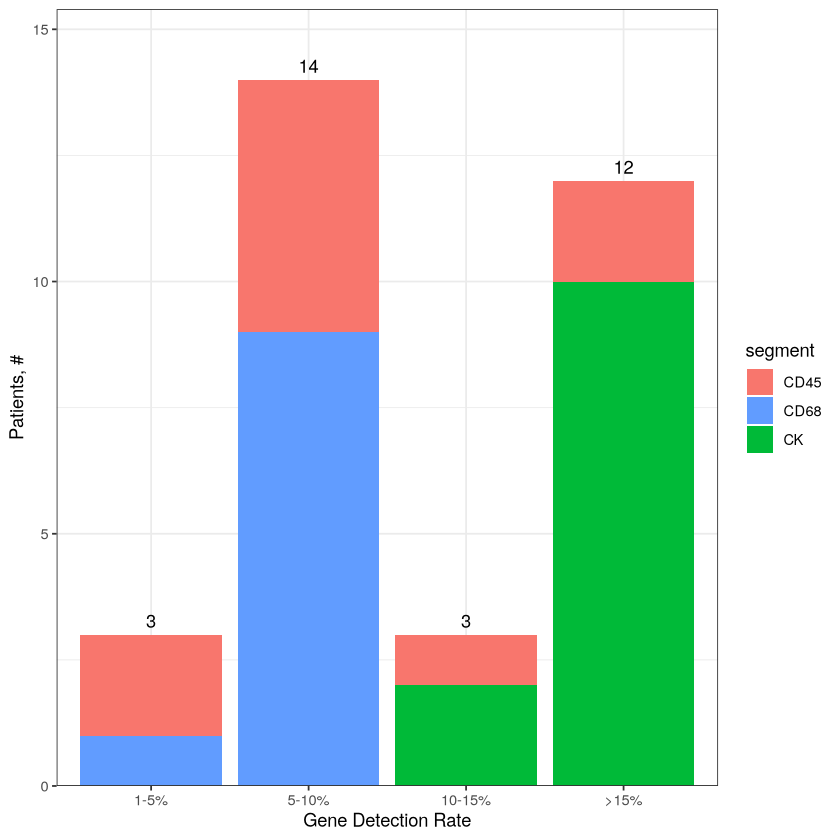

In [13]:
# Save detection rate information to pheno data
pData(target_demoData)$GenesDetected <- 
        colSums(LOQ_Mat, na.rm = TRUE)
pData(target_demoData)$GeneDetectionRate <-
        pData(target_demoData)$GenesDetected / nrow(target_demoData)

# Determine detection thresholds: 1%, 5%, 10%, 15%, >15%
pData(target_demoData)$DetectionThreshold <- 
        cut(pData(target_demoData)$GeneDetectionRate,
            breaks = c(0, 0.01, 0.05, 0.1, 0.15, 1),
            labels = c("<1%", "1-5%", "5-10%", "10-15%", ">15%"))

# stacked bar plot of different cut points (1%, 5%, 10%, 15%)
ggplot(pData(target_demoData),
       aes(x = DetectionThreshold)) +
geom_bar(aes(fill = segment)) +
geom_text(stat = "count", aes(label = after_stat(count)), vjust = -0.5) +
scale_fill_manual(values = c("CK" = ck_color, "CD45" = cd45_color,'CD68'=cd68_color)) +
theme_bw() +
scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
labs(x = "Gene Detection Rate",
     y = "Patients, #",
     fill = "segment")

# cut percent genes detected at 1, 5, 10, 15
kable(table(pData(target_demoData)$DetectionThreshold,pData(target_demoData)$segment))
#print("filter out segments with exceptionally low signal")

In [14]:
print("dim(target_demoData) after filtering")
print(dim(target_demoData))
target_demoData <- target_demoData[, pData(target_demoData)$GeneDetectionRate >= .01]
print("dim(target_demoData) after filtering")
print(dim(target_demoData))
dim(target_demoData)

[1] "dim(target_demoData) after filtering"
Features  Samples 
   18677       32 
[1] "dim(target_demoData) after filtering"
Features  Samples 
   18677       32 


Features  Samples 
   18677       32

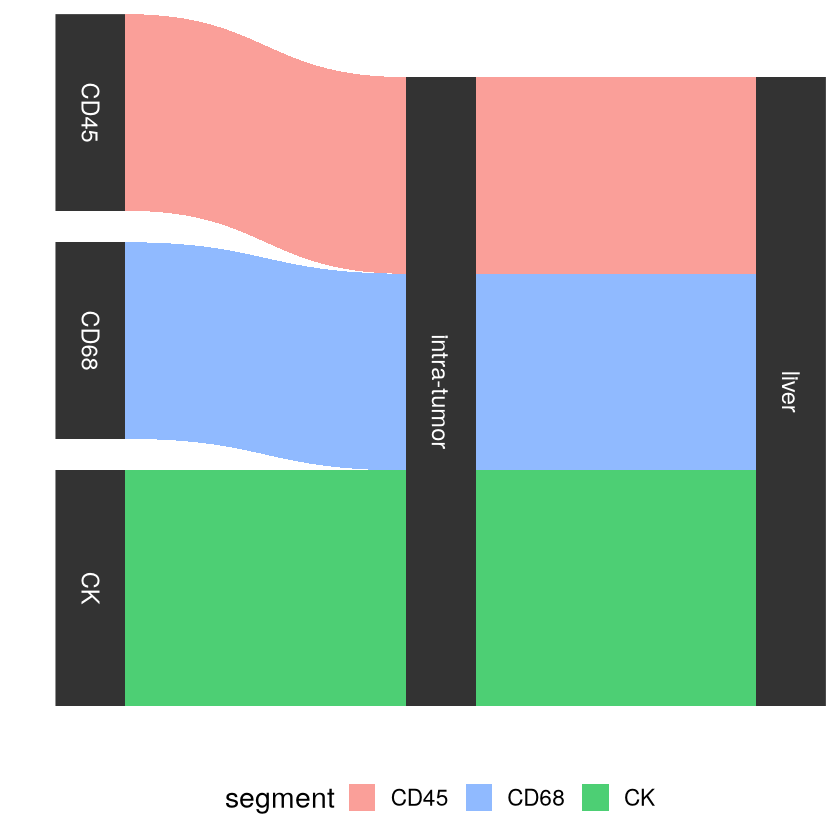

In [15]:
sankey_plot(pData(target_demoData),c('segment','location','tissue'))

## Gene Detection Rate

[1] "dim(target_demoData)"
Features  Samples 
   10294       32 


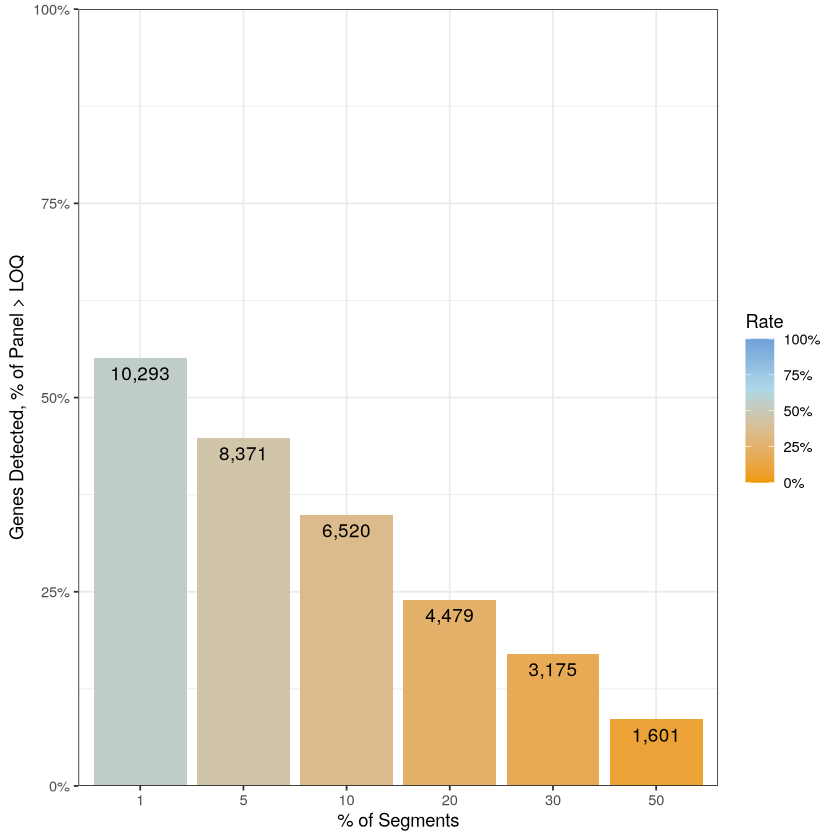

In [16]:
# Calculate detection rate:
LOQ_Mat <- LOQ_Mat[, colnames(target_demoData)]
fData(target_demoData)$DetectedSegments <- rowSums(LOQ_Mat, na.rm = TRUE)
fData(target_demoData)$DetectionRate <-
        fData(target_demoData)$DetectedSegments / nrow(pData(target_demoData))

# Plot detection rate:
plot_detect <- data.frame(Freq = c(1, 5, 10, 20, 30, 50))
plot_detect$Number <-
        unlist(lapply(c(0.01, 0.05, 0.1, 0.2, 0.3, 0.5),
                      function(x) {sum(fData(target_demoData)$DetectionRate >= x)}))
plot_detect$Rate <- plot_detect$Number / nrow(fData(target_demoData))
rownames(plot_detect) <- plot_detect$Freq

ggplot(plot_detect, aes(x = as.factor(Freq), y = Rate, fill = Rate)) +
        geom_bar(stat = "identity") +
        geom_text(aes(label = formatC(Number, format = "d", big.mark = ",")),
                  vjust = 1.6, color = "black", size = 4) +
scale_fill_gradient2(low = "orange2", mid = "lightblue",
                     high = "dodgerblue3", midpoint = 0.65,
                     limits = c(0,1),
                     labels = scales::percent) +
theme_bw() +
scale_y_continuous(labels = scales::percent, limits = c(0,1),
                   expand = expansion(mult = c(0, 0))) +
labs(x = "% of Segments",y = "Genes Detected, % of Panel > LOQ")


# Subset to target genes detected in at least 10% of the samples.
#   Also manually include the negative control probe, for downstream use
negativeProbefData <- subset(fData(target_demoData), CodeClass == "Negative")
neg_probes <- unique(negativeProbefData$TargetName)

######## !!!!!!!!!!!!!!! ################
target_demoData <- 
        target_demoData[fData(target_demoData)$DetectionRate >= 0.01 |
                        fData(target_demoData)$TargetName %in% neg_probes, ]
print("dim(target_demoData)")
print(dim(target_demoData))

# Normalization

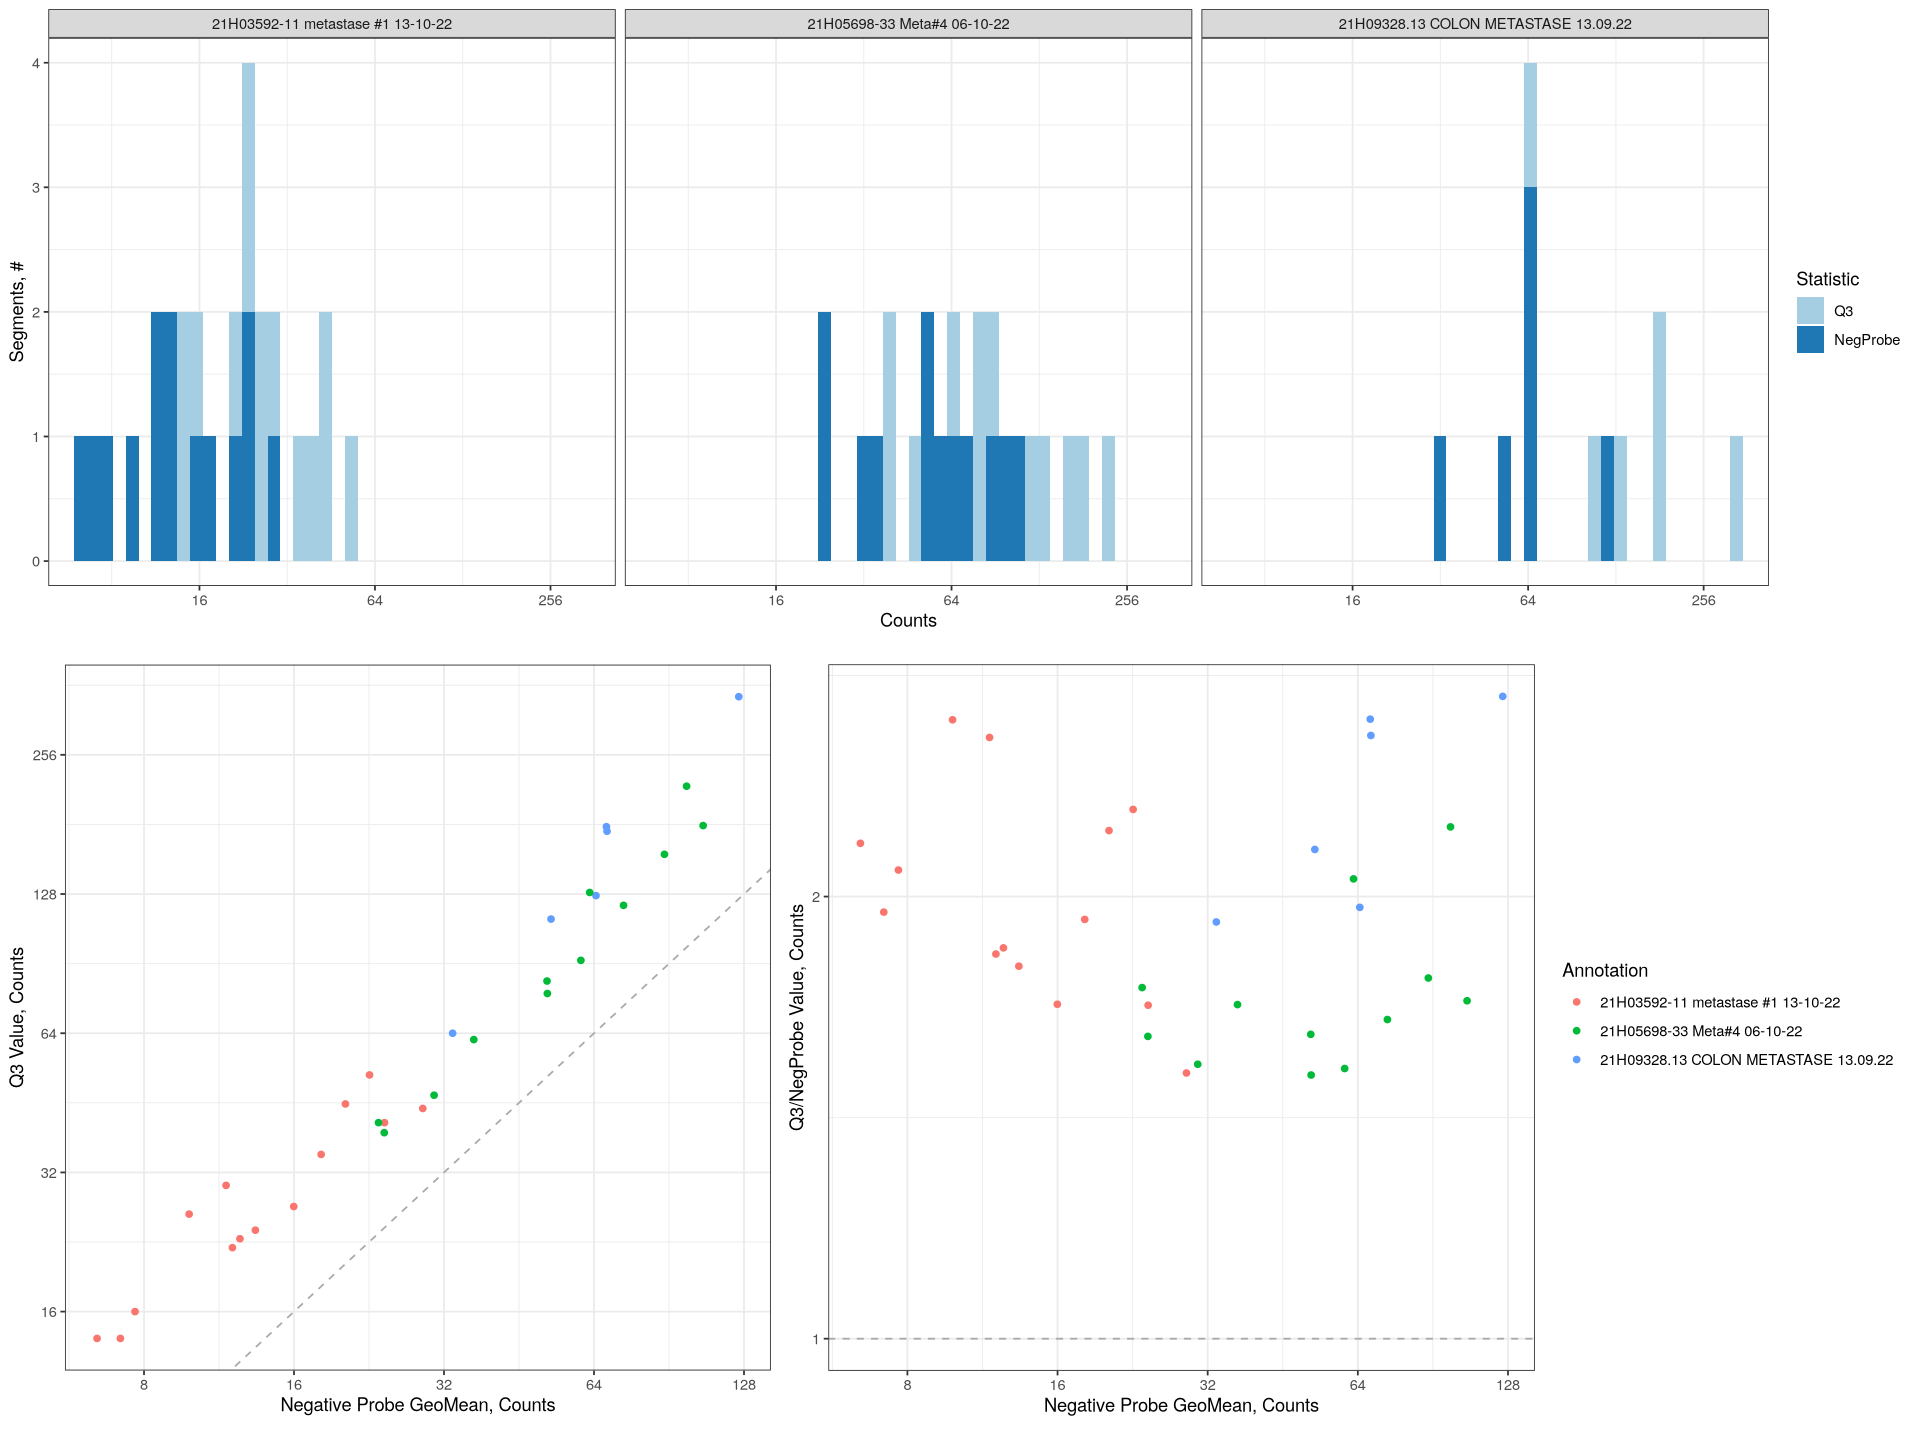

In [17]:


# Graph Q3 value vs negGeoMean of Negatives
ann_of_interest <- "slide name"
Stat_data <- 
        data.frame(row.names = colnames(exprs(target_demoData)),
                   Segment = colnames(exprs(target_demoData)),
                   Annotation = pData(target_demoData)[, ann_of_interest],
                   Q3 = unlist(apply(exprs(target_demoData), 2,
                                     quantile, 0.75, na.rm = TRUE)),
                   NegProbe = exprs(target_demoData)[neg_probes, ])
Stat_data_m <- melt(Stat_data, measure.vars = c("Q3", "NegProbe"),
                    variable.name = "Statistic", value.name = "Value")

plt1 <- ggplot(Stat_data_m,
               aes(x = Value, fill = Statistic)) +
geom_histogram(bins = 40) + theme_bw() +
scale_x_continuous(trans = "log2") +
facet_wrap(~Annotation, nrow = 1) + 
scale_fill_brewer(palette = 3, type = "qual") +
labs(x = "Counts", y = "Segments, #")
#plt1
            plt2 <- ggplot(Stat_data,
                           aes(x = NegProbe, y = Q3, color = Annotation)) +
geom_abline(intercept = 0, slope = 1, lty = "dashed", color = "darkgray") +
geom_point() + guides(color = "none") + theme_bw() +
scale_x_continuous(trans = "log2") + 
scale_y_continuous(trans = "log2") +
theme(aspect.ratio = 1) +
labs(x = "Negative Probe GeoMean, Counts", y = "Q3 Value, Counts")
#plt2
plt3 <- ggplot(Stat_data,aes(x = NegProbe, y = Q3 / NegProbe, color = Annotation)) +
geom_hline(yintercept = 1, lty = "dashed", color = "darkgray") +
geom_point() + theme_bw() +
scale_x_continuous(trans = "log2") + 
scale_y_continuous(trans = "log2") +
theme(aspect.ratio = 1) +
labs(x = "Negative Probe GeoMean, Counts", y = "Q3/NegProbe Value, Counts")
#plt3
options(repr.plot.width=16, repr.plot.height=12)

                btm_row <- plot_grid(plt2, plt3, nrow = 1, labels = c("", ""),
                                     rel_widths = c(0.39,0.57))
plot_grid(plt1, btm_row, ncol = 1, labels = c("", ""),  rel_heights = c(0.4,0.5))
options(repr.plot.width=NULL, repr.plot.height=NULL)

 [1] "slide name"                   "roi"                         
 [3] "segment"                      "area"                        
 [5] "mucinous"                     "tissue"                      
 [7] "patient_id"                   "location"                    
 [9] "treatment_response"           "NegGeoMean_Hs_R_NGS_WTA_v1.0"
[11] "NegGeoSD_Hs_R_NGS_WTA_v1.0"   "Hs_R_NGS_WTA_v1.0"           
[13] "GenesDetected"                "GeneDetectionRate"           
[15] "DetectionThreshold"           "q_norm_qFactors"             
[17] "neg_norm_negFactors"         
[1] 32


Features  Samples 
   10294       32

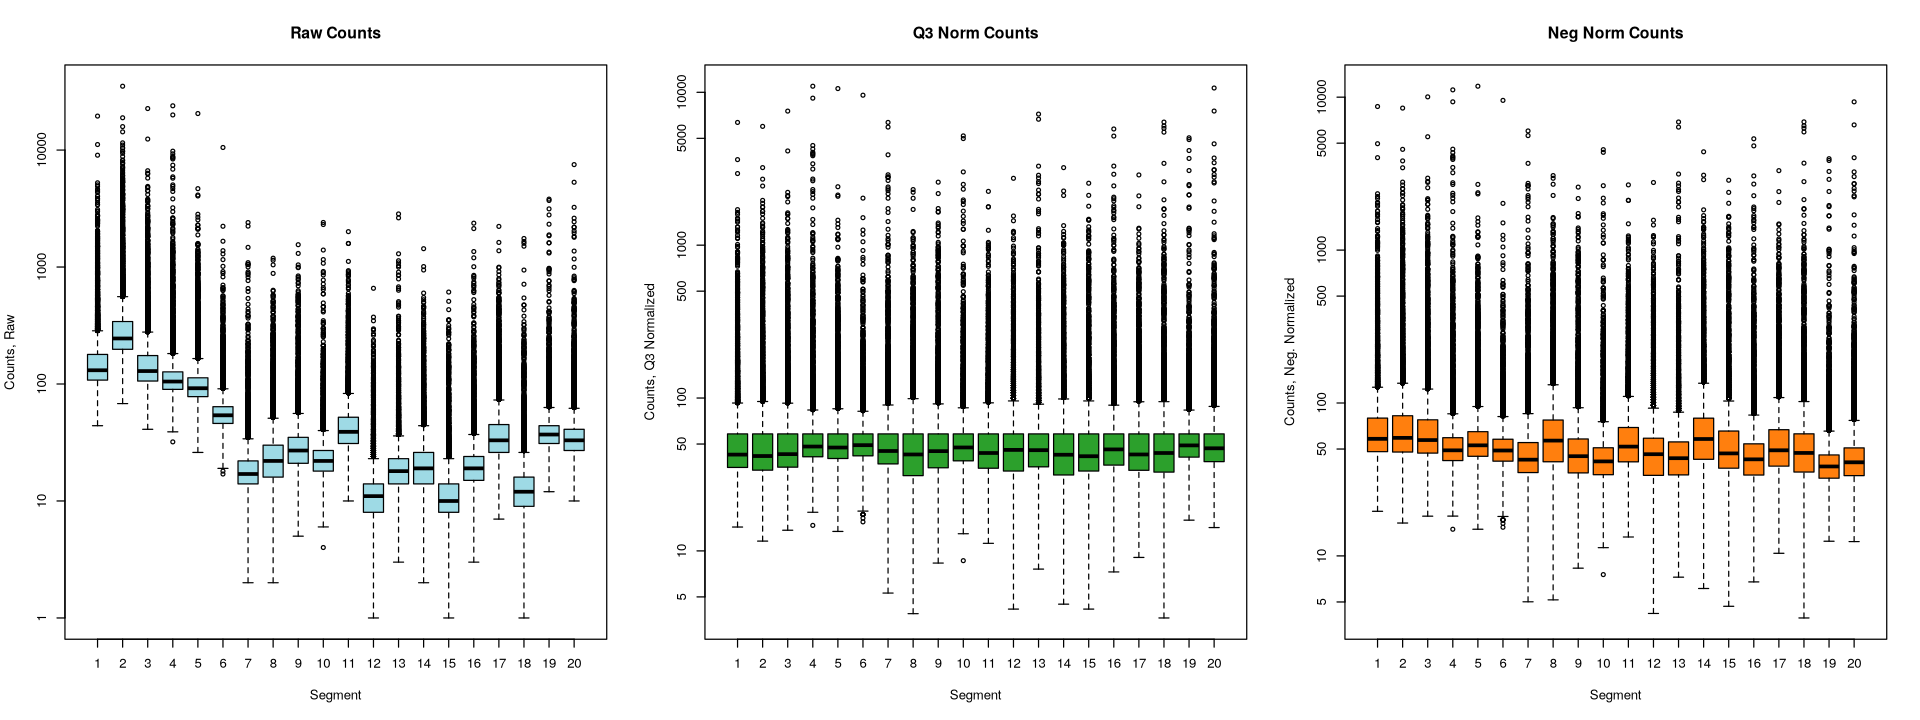

In [18]:
# Q3 norm (75th percentile) for WTA/CTA  with or without custom spike-ins
target_demoData <- normalize(target_demoData ,
                             norm_method = "quant", 
                             desiredQuantile = .75,
                             toElt = "q_norm")

# Background normalization for WTA/CTA without custom spike-in
target_demoData <- normalize(target_demoData ,
                             norm_method = "neg", 
                             fromElt = "exprs",
                             toElt = "neg_norm")

len <- dim(target_demoData)[2][]
str <- paste(len,collape="")

par(bg = "white")
par(mfrow = c(1, 3))  # 1 row, 3 columns
options(repr.plot.width=16, repr.plot.height=6)

# visualize the first 10 segments with each normalization method
boxplot(exprs(target_demoData)[,1:20],
        col = "#9EDAE5", main = "Raw Counts",
        log = "y", names = 1:20, xlab = "Segment",
        ylab = "Counts, Raw")

boxplot(assayDataElement(target_demoData[,1:20], elt = "q_norm"),
        col = "#2CA02C", main = "Q3 Norm Counts",
        log = "y", names = 1:20, xlab = "Segment",
        ylab = "Counts, Q3 Normalized")

boxplot(assayDataElement(target_demoData[,1:20], elt = "neg_norm"),
        col = "#FF7F0E", main = "Neg Norm Counts",
        log = "y", names = 1:20, xlab = "Segment",
        ylab = "Counts, Neg. Normalized")
print(colnames(pData(target_demoData)))
print(nrow(pData(target_demoData)))
dim(target_demoData)
par(mfrow = c(1, 1))
options(repr.plot.width=NULL, repr.plot.height=NULL)


# Differential Expression

Focus on 3 CRC metastasis samples (21H03592.11 & 21H09328.13 & 21H05698.33), for which we have the spatial data.

- Do the DEGs for CK+ and CD45+ segments between these 2 patients, who have different trajectories. If we see that the DEGs fit with the rest of the story, would be great.
- Within each patient, look at the different ROIs, and see if we can detect selective genes in the CK and CD45 segments.
- Can we have access to the matrix counts for these 2 patients in a simple way at GR or you can do it remotely?

1. 21H03592.11 is untreated,
2. 21H09328.13 is progressor
3. 21H05698.33 is responder.

Look at genes CXCL1, CXCL2, CXCL3 and CXCL8 in the CK+ segments of the 3 patients, and genes CD3E, CD8A, PDCD1, LAG-3 and HAVCR2 the CD45+ segment.

This is a biased analysis. You can also just look at what are the diff between the 3 patients in CK and CD45, even if you will probably have a huge patient/batch effect.

[1] 0.01805732
[1] 0.02318318


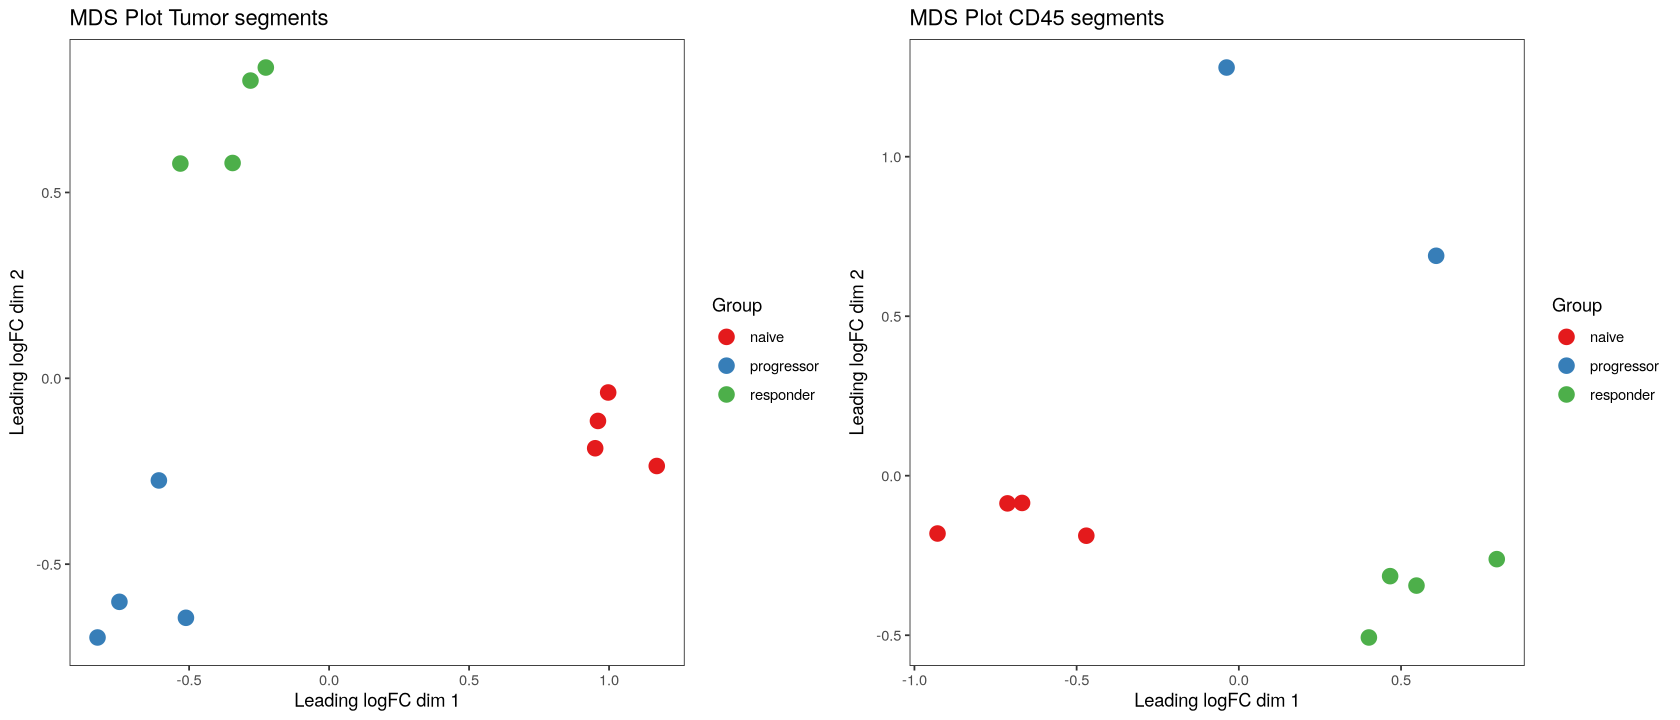

In [19]:
cd45_subset <- target_demoData[,pData(target_demoData)$segment == 'CD45']
ck_subset <- target_demoData[,pData(target_demoData)$segment == 'CK']
glm_model <- function(data) {
    matrix <- assayData(data)[["exprs"]]
    metadata <- pData(data)
    metadata$response <- as.factor(metadata$treatment_response)
    y = DGEList(counts = matrix,samples=metadata)
    y <- calcNormFactors(y)
    design <- model.matrix(~ 0 + response , data = metadata)
    colnames(design) <- levels(metadata$response)
    
    y <- estimateDisp(y,design)
    print(y$common.dispersion)   
    fit <- glmQLFit(y, design, robust = TRUE)
    
    # Define contrasts for all pairwise comparisons
    contrasts <- makeContrasts(
        Progressor_vs_Naive = progressor - naive,
        Responder_vs_Naive = responder - naive,
        Responder_vs_Progressor = responder - progressor,
        levels = design
    )
    
    # Perform tests for each contrast
    results <- list()
    results$Progressor_vs_Naive <- glmQLFTest(fit, contrast = contrasts[,"Progressor_vs_Naive"])
    results$Responder_vs_Naive <- glmQLFTest(fit, contrast = contrasts[,"Responder_vs_Naive"])
    results$Responder_vs_Progressor <- glmQLFTest(fit, contrast = contrasts[,"Responder_vs_Progressor"])
    return(list(df = results,fit = fit, y =y))
}

ck_results = glm_model(ck_subset)
y = ck_results$y
# 1. MDS Plot with white background
mds_data <- plotMDS(y, plot = FALSE)
mds_df <- data.frame(Dim1 = mds_data$x, Dim2 = mds_data$y, Group = pData(ck_subset)$treatment_response)
options(repr.plot.width=6, repr.plot.height=6)

p1 <- ggplot(mds_df, aes(x = Dim1, y = Dim2, color = Group)) +
  geom_point(size = 4) +
  theme_bw() +  # White background
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "white")) +
  scale_color_brewer(palette = "Set1") +
  ggtitle("MDS Plot Tumor segments") +
  xlab("Leading logFC dim 1") +
  ylab("Leading logFC dim 2")

cd45_results = glm_model(cd45_subset)
y = cd45_results$y
# 1. MDS Plot with white background
mds_data <- plotMDS(y, plot = FALSE)
mds_df <- data.frame(Dim1 = mds_data$x, Dim2 = mds_data$y, Group = pData(cd45_subset)$treatment_response)
options(repr.plot.width=6, repr.plot.height=6)

p2 <- ggplot(mds_df, aes(x = Dim1, y = Dim2, color = Group)) +
  geom_point(size = 4) +
  theme_bw() +  # White background
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "white")) +
  scale_color_brewer(palette = "Set1") +
  ggtitle("MDS Plot CD45 segments") +
  xlab("Leading logFC dim 1") +
  ylab("Leading logFC dim 2")


options(repr.plot.width=14, repr.plot.height=6)
grid.arrange(p1, p2, ncol = 2)

options(repr.plot.width=NULL, repr.plot.height=NULL)

In [20]:
# edger_volcano <- function(results, contrast, goi = NULL, goi.color = "blue") {
#     # Extract left and right parts of contrast (e.g., "group1 - group2")
#     pattern <- "^(.+?) - (.+)$"
#     matches <- str_match(contrast, pattern)
#     left_part <- trimws(matches[2])  # group1
#     right_part <- trimws(matches[3]) # group2
    
#     # Categorize results based on P-value & FDR
#     results$Color <- "NS or FC < 0.5"
#     results$Color[results$PValue < 0.05] <- "P < 0.05"
#     results$Color[results$FDR < 0.05] <- "FDR < 0.05"
#     results$Color[results$FDR < 0.001] <- "FDR < 0.001"
#     results$Color[abs(results$logFC) < 0.5] <- "NS or FC < 0.5"
#     results$Color <- factor(results$Color, levels = c("NS or FC < 0.5", "P < 0.05", "FDR < 0.05", "FDR < 0.001"))
    
#     # Compute inverted P for ranking
#     results$invert_P <- (-log10(results$PValue)) * sign(results$logFC)
    
#     # Pick top genes (using rownames)
#     ind <- which(abs(results$logFC) >= 0.5 & results$FDR < 0.05)
#     top_g <- c()
#     if (length(ind) > 0) {
#         top_g <- c(
#             rownames(results)[ind][order(results$invert_P[ind], decreasing = TRUE)[1:15]],  # Top enriched in left_part
#             rownames(results)[ind][order(results$invert_P[ind], decreasing = FALSE)[1:15]]  # Top enriched in right_part
#         )
#         top_g <- unique(top_g[!is.na(top_g)])  # Remove NA and duplicates
#     }
    
#     # Remove invert_P column
#     results$invert_P <- NULL
    
#     # Create volcano plot
#     volcano_plot <- ggplot(results, aes(x = logFC, y = -log10(PValue), color = Color, label = rownames(results))) +
#         geom_vline(xintercept = c(0.5, -0.5), linetype = "dashed") +
#         geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
#         geom_point(size = 2) +
#         labs(
#             x = paste0("Enriched in ", right_part, " <- log2(FC) -> Enriched in ", left_part),
#             y = "-log10(P-value)",
#             color = "Significance",
#             title = contrast
#         ) +
#         scale_color_manual(
#             values = c(
#                 "FDR < 0.001" = "#e03a3a",
#                 "FDR < 0.05" = "#e0833a",
#                 "P < 0.05" = "#d4d632",
#                 "NS or FC < 0.5" = "gray"
#             ),
#             guide = guide_legend(override.aes = list(size = 3))
#         ) +
#         scale_y_continuous(expand = expansion(mult = c(0, 0.05))) +
#         theme_bw(base_size = 14) +
#         theme(
#             legend.position = "bottom",
#             plot.title = element_text(hjust = 0.5)
#         )
    
#     # Add gene labels for top significant genes (FDR < 0.001)
#     if (length(top_g) > 0) {
#         label_data <- results[rownames(results) %in% top_g & results$FDR < 0.001, ]
#         if (nrow(label_data) > 0) {
#             volcano_plot <- volcano_plot +
#                 geom_text_repel(
#                     data = label_data,
#                     aes(label = rownames(label_data)),
#                     size = 3,
#                     max.overlaps = 50,
#                     box.padding = 0.3,
#                     segment.color = "grey50"
#                 )
#         }
#     }
    
#     # Add gene labels for user-specified genes of interest (goi)
#     if (!is.null(goi) && length(goi) > 0) {
#         goi_data <- results[rownames(results) %in% goi, ]
#         if (nrow(goi_data) > 0) {
#             volcano_plot <- volcano_plot +
#                 geom_text_repel(
#                     data = goi_data,
#                     aes(label = rownames(goi_data)),
#                     color = goi.color,
#                     size = 3,
#                     max.overlaps = Inf,  # Always show all goi labels
#                     box.padding = 0.5,
#                     segment.color = "grey50",
#                     fontface = "bold"
#                 )
#         }
#     }
    
#     return(volcano_plot)
# }

edger_volcano_single <- function(results, contrast, gene_group = NULL, group_name = NULL, group_color = "black", show_top_genes = FALSE) {
  require(ggplot2)
  require(ggrepel)
  require(stringr)
  
  # Extract contrast parts
  matches <- str_match(contrast, "^(.+?) - (.+)$")
  left_part <- trimws(matches[2])
  right_part <- trimws(matches[3])
  
  # Categorize results
  results$Color <- "NS or FC < 0.5"
  results$Color[results$PValue < 0.05] <- "P < 0.05"
  results$Color[results$FDR < 0.05] <- "FDR < 0.05"
  results$Color[results$FDR < 0.001] <- "FDR < 0.001"
  results$Color[abs(results$logFC) < 0.5] <- "NS or FC < 0.5"
  results$Color <- factor(results$Color, levels = c("NS or FC < 0.5", "P < 0.05", "FDR < 0.05", "FDR < 0.001"))
  
  # Get top genes if requested
  if (show_top_genes) {
    results$invert_P <- (-log10(results$PValue)) * sign(results$logFC)
    ind <- which(abs(results$logFC) >= 0.5 & results$FDR < 0.05)
    top_g <- if (length(ind) > 0) {
      unique(c(
        rownames(results)[ind][order(results$invert_P[ind], decreasing = TRUE)[1:15]],
        rownames(results)[ind][order(results$invert_P[ind], decreasing = FALSE)[1:15]]
      ))
    } else character(0)
    results$invert_P <- NULL
  }
  
  # Create base plot
  p <- ggplot(results, aes(x = logFC, y = -log10(PValue), color = Color)) +
    geom_vline(xintercept = c(0.5, -0.5), linetype = "dashed") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_point(size = 1.5) +
    labs(
      x = paste0("Enriched in ", right_part, " <- log2(FC) -> Enriched in ", left_part),
      y = "-log10(P-value)",
      color = "Significance",
      title = ifelse(is.null(group_name), "Top genes", group_name)
    ) +
    scale_color_manual(
      values = c("FDR < 0.001" = "#e03a3a", "FDR < 0.05" = "#e0833a", 
                 "P < 0.05" = "#d4d632", "NS or FC < 0.5" = "gray"),
      guide = guide_legend(override.aes = list(size = 3))
    ) +
    theme_bw(base_size = 11) +
    theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5, size = 10))
  
  # Add top genes if requested
  if (show_top_genes && exists("top_g") && length(top_g) > 0) {
    label_data <- results[rownames(results) %in% top_g & results$FDR < 0.001, ]
    if (nrow(label_data) > 0) {
      p <- p + geom_text_repel(
        data = label_data,
        aes(label = rownames(label_data)),
        size = 2.2,
        max.overlaps = 20,
        box.padding = 0.25,
        segment.color = "grey50",
        color = "black"
      )
    }
  }
  
  # Add gene group highlights if provided
  if (!is.null(gene_group)) {
    highlight_data <- results[rownames(results) %in% gene_group & 
                     results$FDR < 0.05 & 
                     abs(results$logFC) > 0.5, ]
    if (nrow(highlight_data) > 0) {
      p <- p +
        geom_point(
          data = highlight_data,
          color = group_color,
          size = 1.8
        ) +
        geom_text_repel(
          data = highlight_data,
          aes(label = rownames(highlight_data)),
          color = group_color,
          size = 2.2,
          max.overlaps = Inf,
          box.padding = 0.4,
          segment.color = "grey50",
          fontface = "bold"
        )
    }
  }
  
  return(p)
}

# Genes

In [21]:
group_colors <- c("naive" = "#e41a1c", "progressor" = "#367db7", "responder" = "#4cae49")

genes = c("COL6A3", "GPC6", "RARRES2", "DCN", "BICC1", "LUM", "C1S", "COL5A1", "ANTXR1", "COL12A1", "VCAN", "CDH11","COL18A1", "SOX5", "EBF1", "DLC1", "RGS5", "PDGFRB", "LHFPL6", "CACNA1C", "FILIP1L", "CCDC102B", "NOTCH3", "MGP", "RBMS3","CD3", "CD8", "PD1", "GZMB", "LAG3", "TIM3", "HLA-DPB1", "FTL", "FTH1", "RPL10", "TPT1", "TMSB4X", "RPL13", "TMSB10", "EEF1A1", "RPS12", "BDCA-2", "CD1A", "CD11C", "CD83", "XCR1", "CD86", "CD4", "CD45", "CD25", "CD69", "FOXP3", "CTLA4", "CD38", "MTRNR2L1", "CDX1", "PLP2", "TFF3", "VAMP8", "GPX2", "DBI", "CLIC1", "KRT18", "PTPRK", "KRT19", "PHGR1", "LLGL2", "LMO7", "CTNND1", "AGAP1", "MAP7", "LINC00511")
subtypes = c("FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1","FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2","Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder")
cell_types = c("fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells")

df = data.frame(genes= genes , subtypes = subtypes, cell_type = cell_types)
fc1 =df[df$subtypes == 'FC1',]$genes
fc2 =df[df$subtypes == 'FC2',]$genes
exhausted_cd8 =df[df$subtypes == 'Exhausted CD8',]$genes
dc_markers =df[df$subtypes == 'DCs markers',]$genes
Progressor =df[df$subtypes == 'Progressor',]$genes
Responder =df[df$subtypes == 'Responder',]$genes
responder_dc_sig =df[df$subtypes == 'responder_dc_sig',]$genes
unknown =df[df$subtypes == 'unknown',]$genes

signature_5Ato30 = c("CXCL2", "CXCL8", "CXCL3", "CXCL1", "CREB5", "EMP1", "KLF10", "RELB", "EPHA2", "TUBA1A", "PMAIP1", "IRF1", "GADD45B", "TCIM", "HBEGF", "TNAIP3", "TNFRSF12A", "BCL3", "MAFF", "TMEM265", "NFKBIA", "CTSB", "PIM3", "ABTB2", "ANXA1", "PLAUR", "CCN1", "RND3", "TUBB2A", "FOSL1")
apoptotic_hallmarks = c("CASP1", "CASP2", "CASP3", "CASP4", "CASP6", "CASP7", "CASP8", "CASP9", "ENO2", "ERBB2", "ERBB3", "F2", "F2R", "FAS", "GPX1", "GPX3", "GPX4", "GSTM1", "HGF", "HMGB2", "IRF1", "LGALS3", "MMP2", "PDGFRB", "RELA", "RHOB", "TGFB2", "TGFBR3", "TNF")
cd45_markers = c("CD3E","CD8A","PDCD1","LAG-3","HAVCR2")
ck_markers = c("CXCL1", "CXCL2", "CXCL3","CXCL8")

degs_ods <- "/home/dimitris/Workspace/crc/sergey_paper/DEGS_new.ods"
TC_DEGS_enr_PR <- as.data.frame(read_ods(degs_ods,sheet = "TC_DEGS_enr_PR"))
TC_MP_progr <- as.data.frame(read_ods(degs_ods,sheet = "TC_MP_progr"))
TC_autophagiy_progr <- read_ods(degs_ods,sheet = "TC_autophagiy_progr",col_names=F)[[1]]
CD8_MP_exh <- read_ods(degs_ods,sheet = "CD8_MP_exh")[[1]]

progressor_genes <- TC_DEGS_enr_PR[TC_DEGS_enr_PR[, 7]  == "PR", "names"]
responder_genes  <- TC_DEGS_enr_PR[TC_DEGS_enr_PR[, 7]  == "RESP", "names"]
mp14_emt_iii <- TC_MP_progr[,1]
mp21_respiration <- TC_MP_progr[,2]
mp3_cellcycle_hmg_rich <- TC_MP_progr[,3]

# gene_groups = list("fc1" = fc1,
#                    "fc2" = fc2,
#                    "exhausted_cd8" = exhausted_cd8,
#                    "dc_markers"=dc_markers,
#                    "Progressor"=Progressor,
#                    "Responder"=Responder,
#                    "responder_dc_sig"=responder_dc_sig,
#                    "unknown"=unknown,
#                    "signature_5Ato30"= signature_5Ato30,
#                    "apoptotic_hallmarks" = apoptotic_hallmarks,
#                    "cd45_markers" = cd45_markers,
#                    "ck_markers" = ck_markers
#                 )

# gene_group_colors <- c(
#   "fc1" = "#1F77B4",          # Muted blue (consistent for FC groups)
#   "fc2" = "#AEC7E8",          # Light blue (complement to fc1)
#   "exhausted_cd8" = "#D62728", # Brick red (strong for important T cell state)
#   "dc_markers" = "#FF7F0E",   # Safety orange (clear for DCs)
#   "Progressor" = "#8C564B",    # Brownish (clinical outcome)
#   "Responder" = "#2CA02C",     # Green (positive clinical outcome)
#   "responder_dc_sig" = "#17BECF", # Teal (mix of responder + DC)
#   "unknown" = "#7F7F7F",       # Medium gray (for unknown)
#   "signature_5Ato30" = "#9467BD", # Purple (distinct for signatures)
#   "apoptotic_hallmarks" = "#E377C2", # Pink (apoptosis)
#   "cd45_markers" = "#BCBD22",  # Olive (leukocyte markers)
#   "ck_markers" = "#FFBB78"     # Peach (cytokeratin markers)
# )

ck_gene_groups = list(
  "TC autophagy progressor" = TC_autophagiy_progr,
  "MP14 EMT III" = mp14_emt_iii,
  "MP21 Respiration" = mp21_respiration,
  "MP3 cell cycle HMG-rich" = mp3_cellcycle_hmg_rich,
  "CK markers" = ck_markers,
  "Progressor markers" = progressor_genes,
  "Responder markers" = responder_genes
)

ck_gene_group_colors <- c(
  "MP14 EMT III" = "#FF7F0E",
  "MP21 Respiration" = "#17BECF",
  "MP3 cell cycle HMG-rich" = "#9467BD",
  "CK markers" = "#E377C2",
  "TC autophagy progressor" = "#1F77B4",
  "Progressor markers" = "#8C564B",
  "Responder markers" = "#2CA02C"
)
cd45_gene_groups = list(
  "CD8 MP exh" = CD8_MP_exh,
  "CD45 markers" = cd45_markers,
  "Progressor markers" = progressor_genes,
  "Responder markers" = responder_genes
)

cd45_gene_group_colors <- c(
  "cd45_markers" = "#BCBD22",
  "CD8_MP_exh" = "#D62728",
  "Progressor markers" = "#8C564B",
  "Responder markers" = "#2CA02C"
)

New names:
• `` -> `...1`
• `` -> `...7`
New names:
• `` -> `...1`


# CK

Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


TableGrob (3 x 4) "arrange": 9 grobs
                        z     cells    name                 grob
Overview                1 (2-2,1-1) arrange       gtable[layout]
TC autophagy progressor 2 (2-2,2-2) arrange       gtable[layout]
MP14 EMT III            3 (2-2,3-3) arrange       gtable[layout]
MP21 Respiration        4 (2-2,4-4) arrange       gtable[layout]
MP3 cell cycle HMG-rich 5 (3-3,1-1) arrange       gtable[layout]
CK markers              6 (3-3,2-2) arrange       gtable[layout]
Progressor markers      7 (3-3,3-3) arrange       gtable[layout]
Responder markers       8 (3-3,4-4) arrange       gtable[layout]
                        9 (1-1,1-4) arrange text[GRID.text.2132]


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


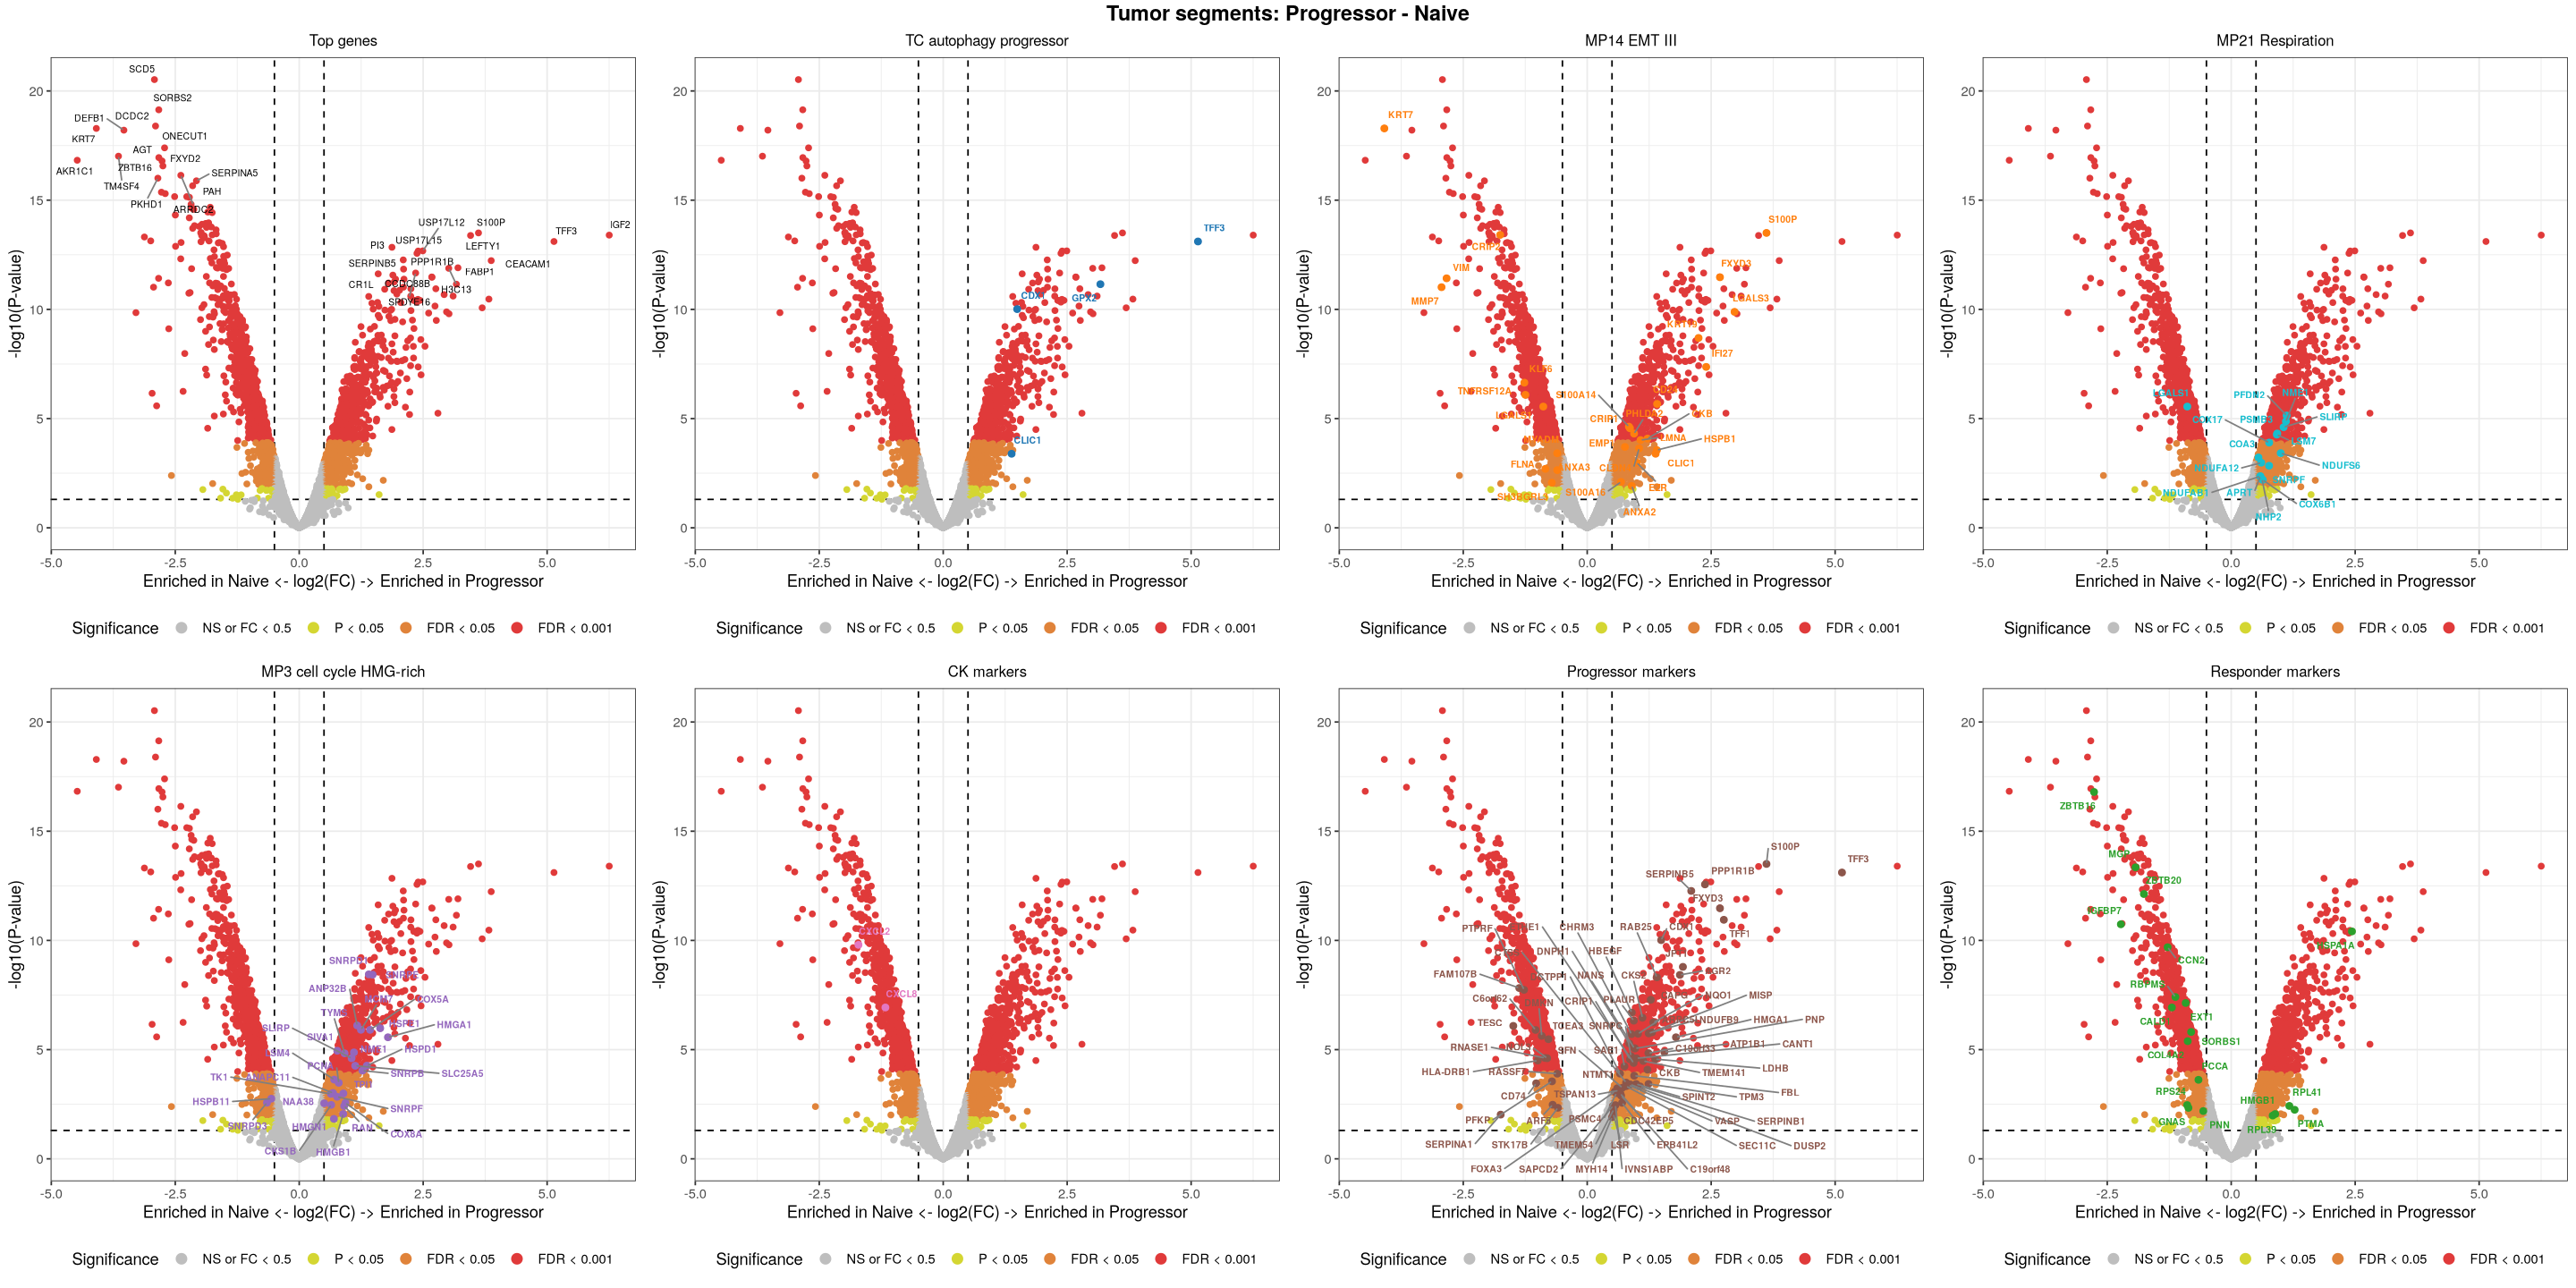

TableGrob (3 x 4) "arrange": 9 grobs
                        z     cells    name                 grob
Overview                1 (2-2,1-1) arrange       gtable[layout]
TC autophagy progressor 2 (2-2,2-2) arrange       gtable[layout]
MP14 EMT III            3 (2-2,3-3) arrange       gtable[layout]
MP21 Respiration        4 (2-2,4-4) arrange       gtable[layout]
MP3 cell cycle HMG-rich 5 (3-3,1-1) arrange       gtable[layout]
CK markers              6 (3-3,2-2) arrange       gtable[layout]
Progressor markers      7 (3-3,3-3) arrange       gtable[layout]
Responder markers       8 (3-3,4-4) arrange       gtable[layout]
                        9 (1-1,1-4) arrange text[GRID.text.2868]


Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


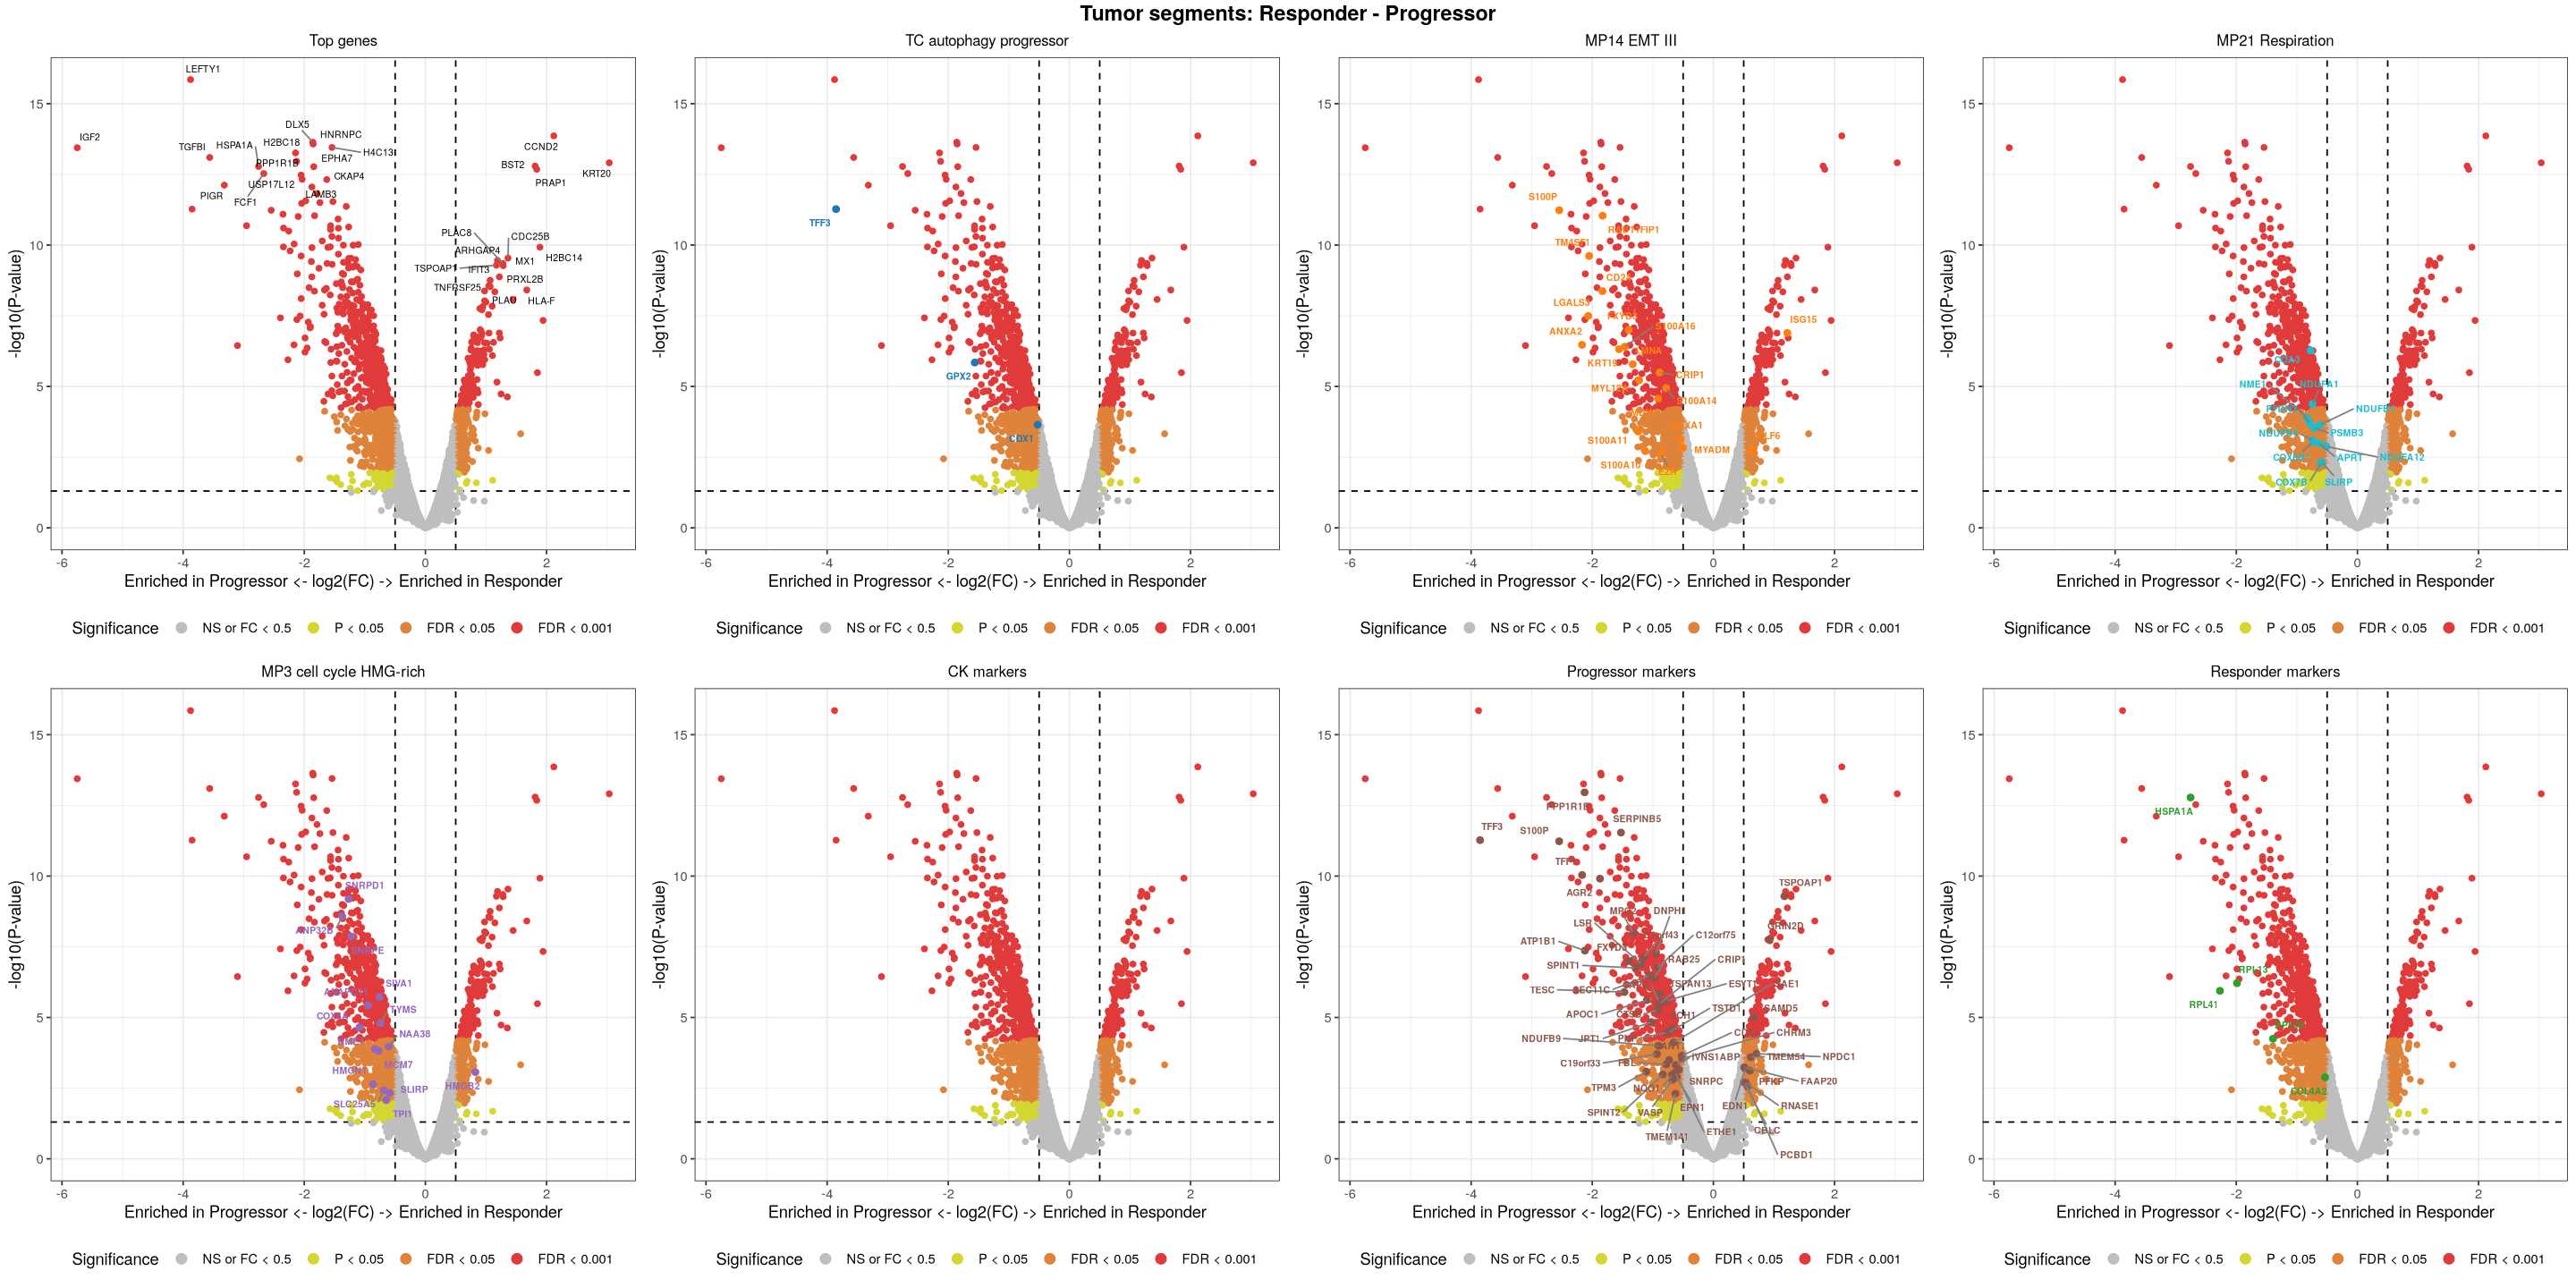

TableGrob (3 x 4) "arrange": 9 grobs
                        z     cells    name                 grob
Overview                1 (2-2,1-1) arrange       gtable[layout]
TC autophagy progressor 2 (2-2,2-2) arrange       gtable[layout]
MP14 EMT III            3 (2-2,3-3) arrange       gtable[layout]
MP21 Respiration        4 (2-2,4-4) arrange       gtable[layout]
MP3 cell cycle HMG-rich 5 (3-3,1-1) arrange       gtable[layout]
CK markers              6 (3-3,2-2) arrange       gtable[layout]
Progressor markers      7 (3-3,3-3) arrange       gtable[layout]
Responder markers       8 (3-3,4-4) arrange       gtable[layout]
                        9 (1-1,1-4) arrange text[GRID.text.3748]


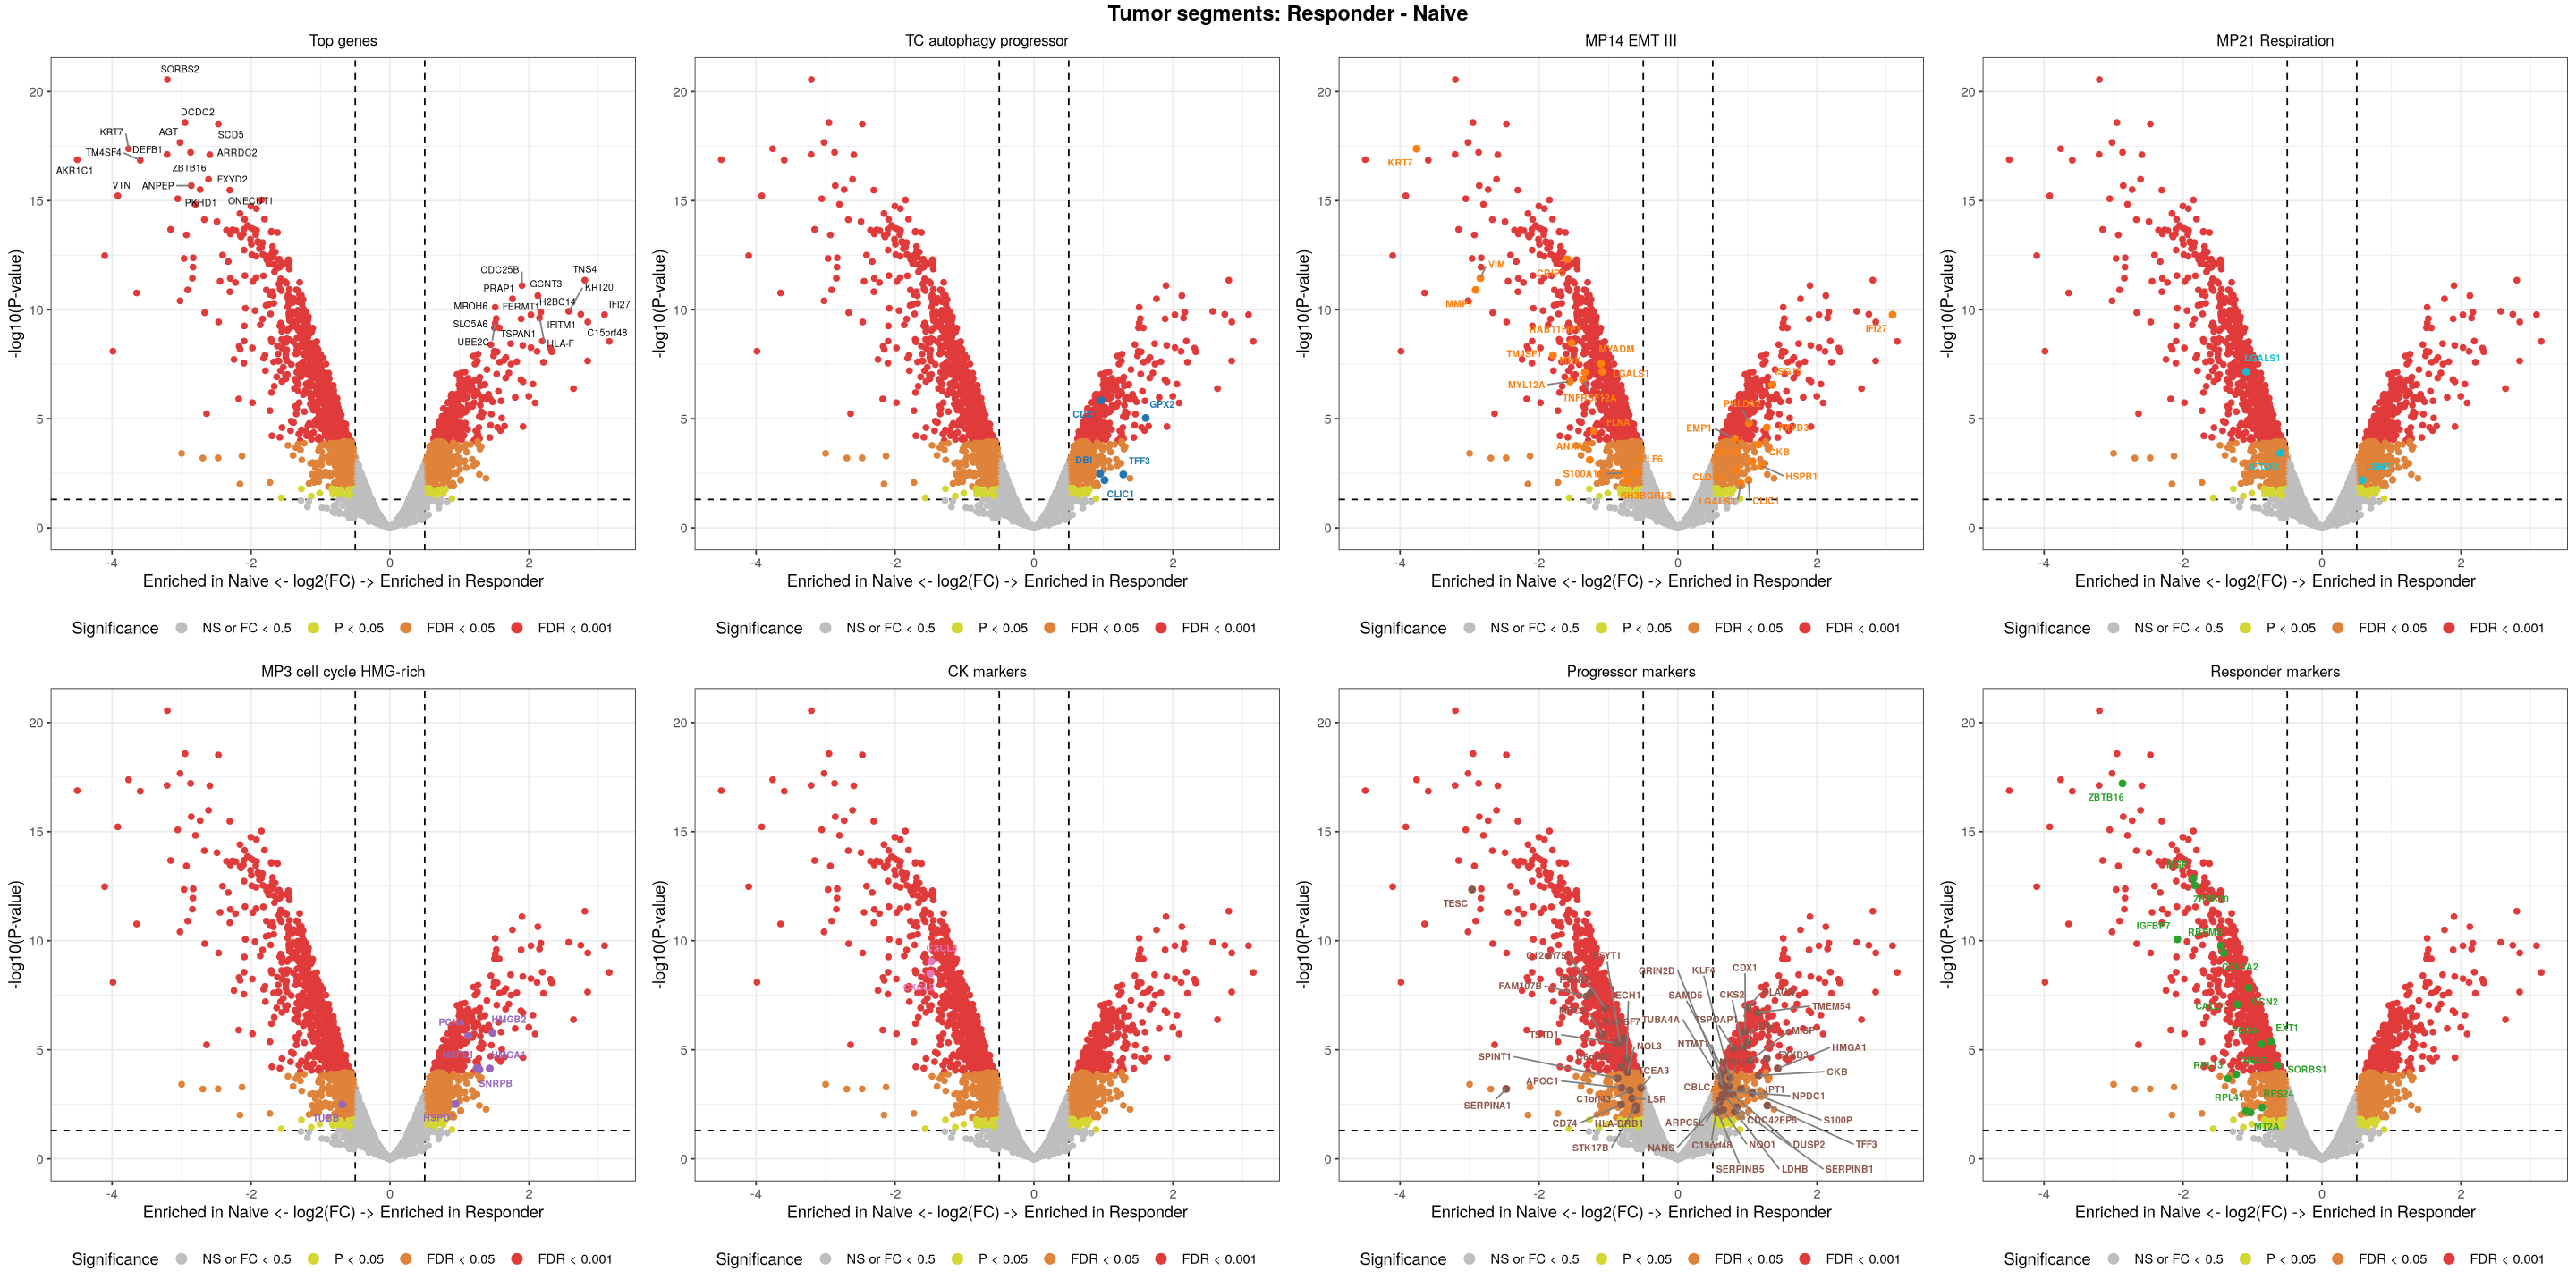

In [22]:
Progressor_Naive_results = topTags(ck_results$df$Progressor_vs_Naive, n = Inf)$table
contrast = 'Progressor - Naive'
# Run the analysis
# Create list to store plots
plot_list <- list()

# Overview plot with top genes
plot_list[["Overview"]] <- edger_volcano_single(
  results = Progressor_Naive_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(ck_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Progressor_Naive_results,
    contrast = contrast,
    gene_group = ck_gene_groups[[group_name]],
    group_name = group_name,
    group_color = ck_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("Tumor segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

Responder_Progressor_results = topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table
contrast = 'Responder - Progressor'

plot_list <- list()

plot_list[["Overview"]] <- edger_volcano_single(
  results = Responder_Progressor_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(ck_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Responder_Progressor_results,
    contrast = contrast,
    gene_group = ck_gene_groups[[group_name]],
    group_name = group_name,
    group_color = ck_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("Tumor segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

Responder_Naive_results = topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table
contrast = 'Responder - Naive'

plot_list <- list()

plot_list[["Overview"]] <- edger_volcano_single(
  results = Responder_Naive_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(ck_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Responder_Naive_results,
    contrast = contrast,
    gene_group = ck_gene_groups[[group_name]],
    group_name = group_name,
    group_color = ck_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("Tumor segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

# CD45

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


TableGrob (3 x 4) "arrange": 6 grobs
                   z     cells    name                 grob
Overview           1 (2-2,1-1) arrange       gtable[layout]
CD8 MP exh         2 (2-2,2-2) arrange       gtable[layout]
CD45 markers       3 (2-2,3-3) arrange       gtable[layout]
Progressor markers 4 (2-2,4-4) arrange       gtable[layout]
Responder markers  5 (3-3,1-1) arrange       gtable[layout]
                   6 (1-1,1-4) arrange text[GRID.text.4503]


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


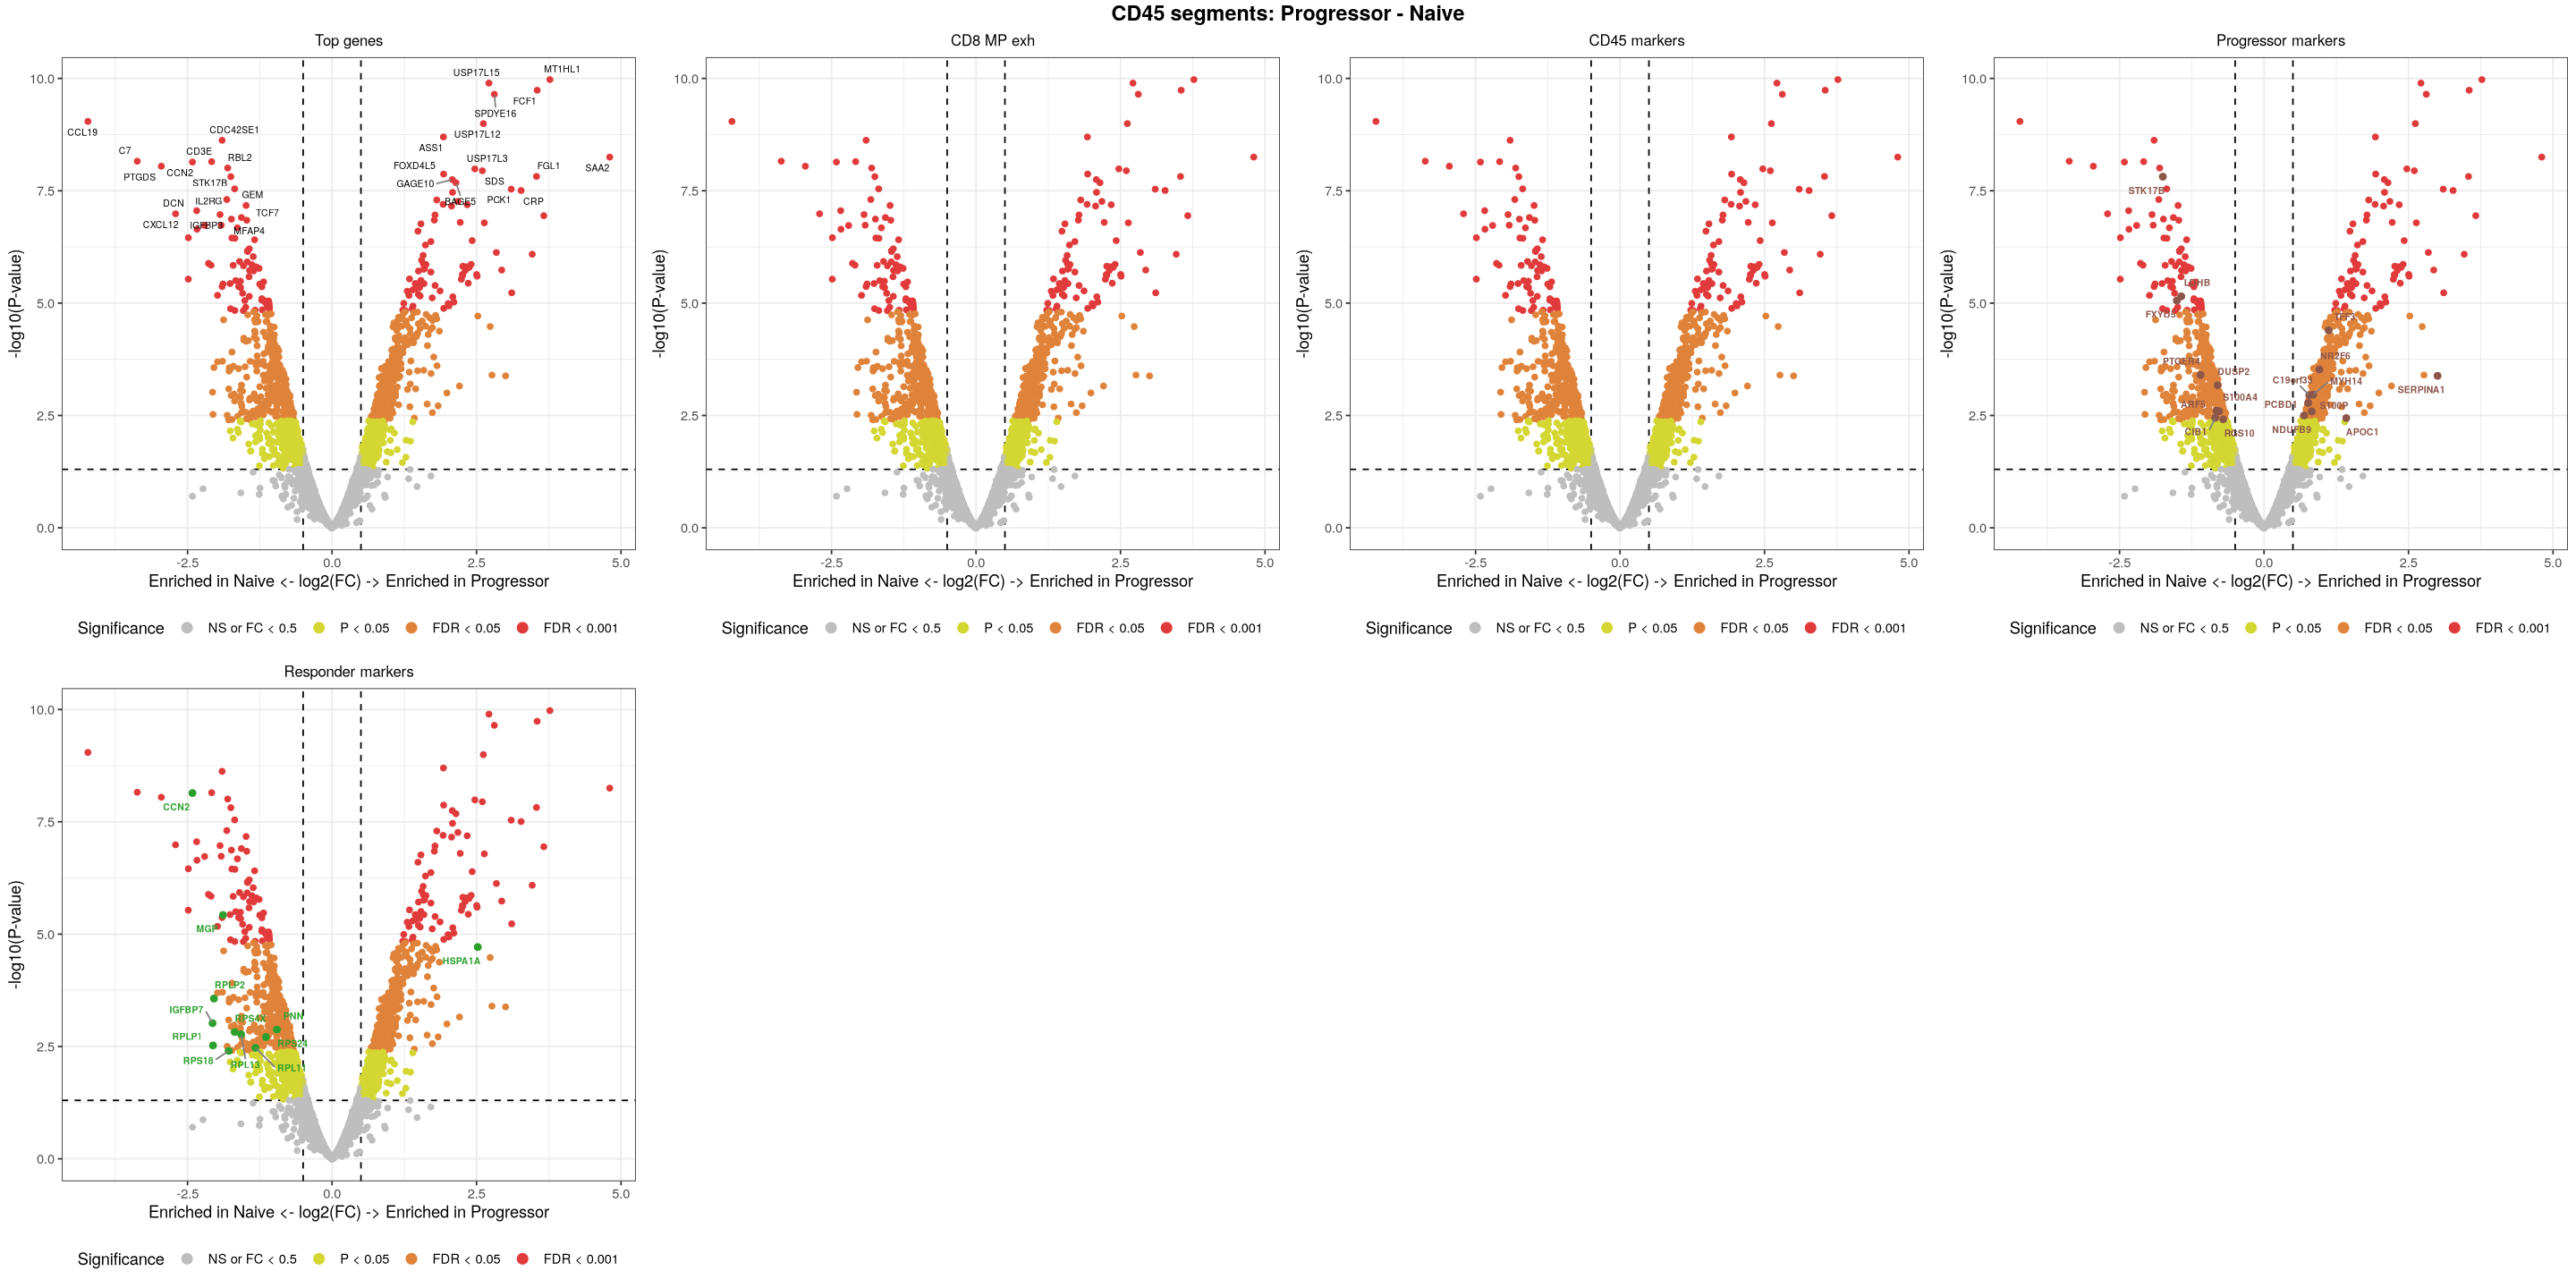

TableGrob (3 x 4) "arrange": 6 grobs
                   z     cells    name                 grob
Overview           1 (2-2,1-1) arrange       gtable[layout]
CD8 MP exh         2 (2-2,2-2) arrange       gtable[layout]
CD45 markers       3 (2-2,3-3) arrange       gtable[layout]
Progressor markers 4 (2-2,4-4) arrange       gtable[layout]
Responder markers  5 (3-3,1-1) arrange       gtable[layout]
                   6 (1-1,1-4) arrange text[GRID.text.4904]


Warning message:
“Removed 9 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


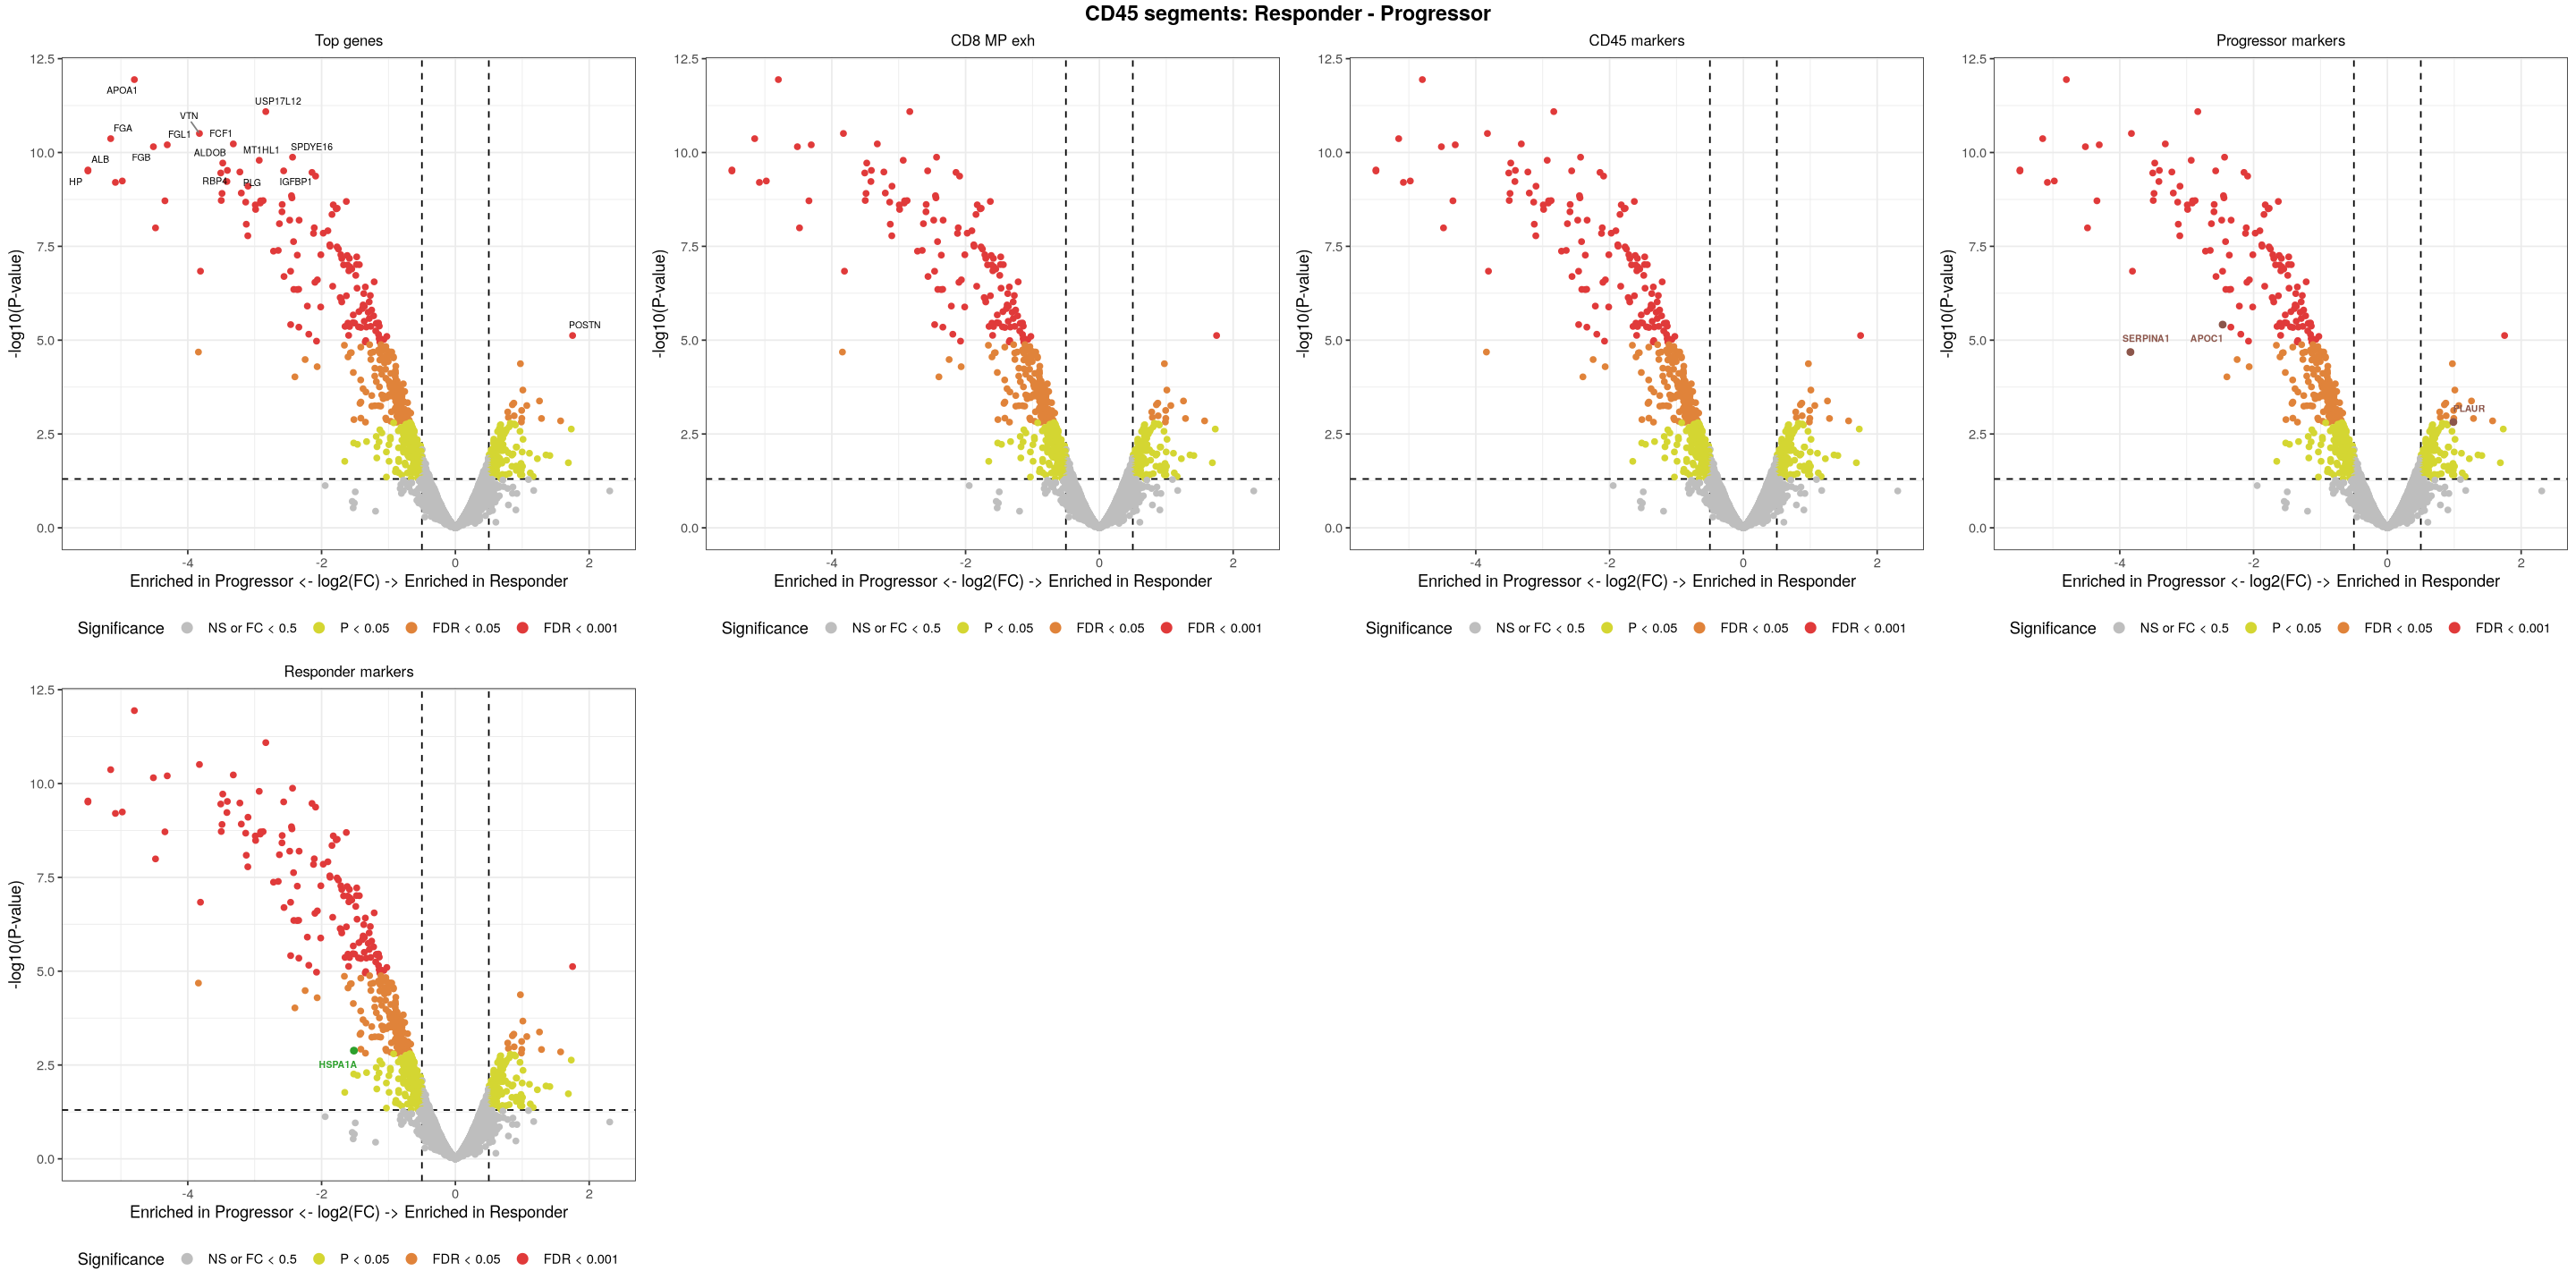

TableGrob (3 x 4) "arrange": 6 grobs
                   z     cells    name                 grob
Overview           1 (2-2,1-1) arrange       gtable[layout]
CD8 MP exh         2 (2-2,2-2) arrange       gtable[layout]
CD45 markers       3 (2-2,3-3) arrange       gtable[layout]
Progressor markers 4 (2-2,4-4) arrange       gtable[layout]
Responder markers  5 (3-3,1-1) arrange       gtable[layout]
                   6 (1-1,1-4) arrange text[GRID.text.5328]


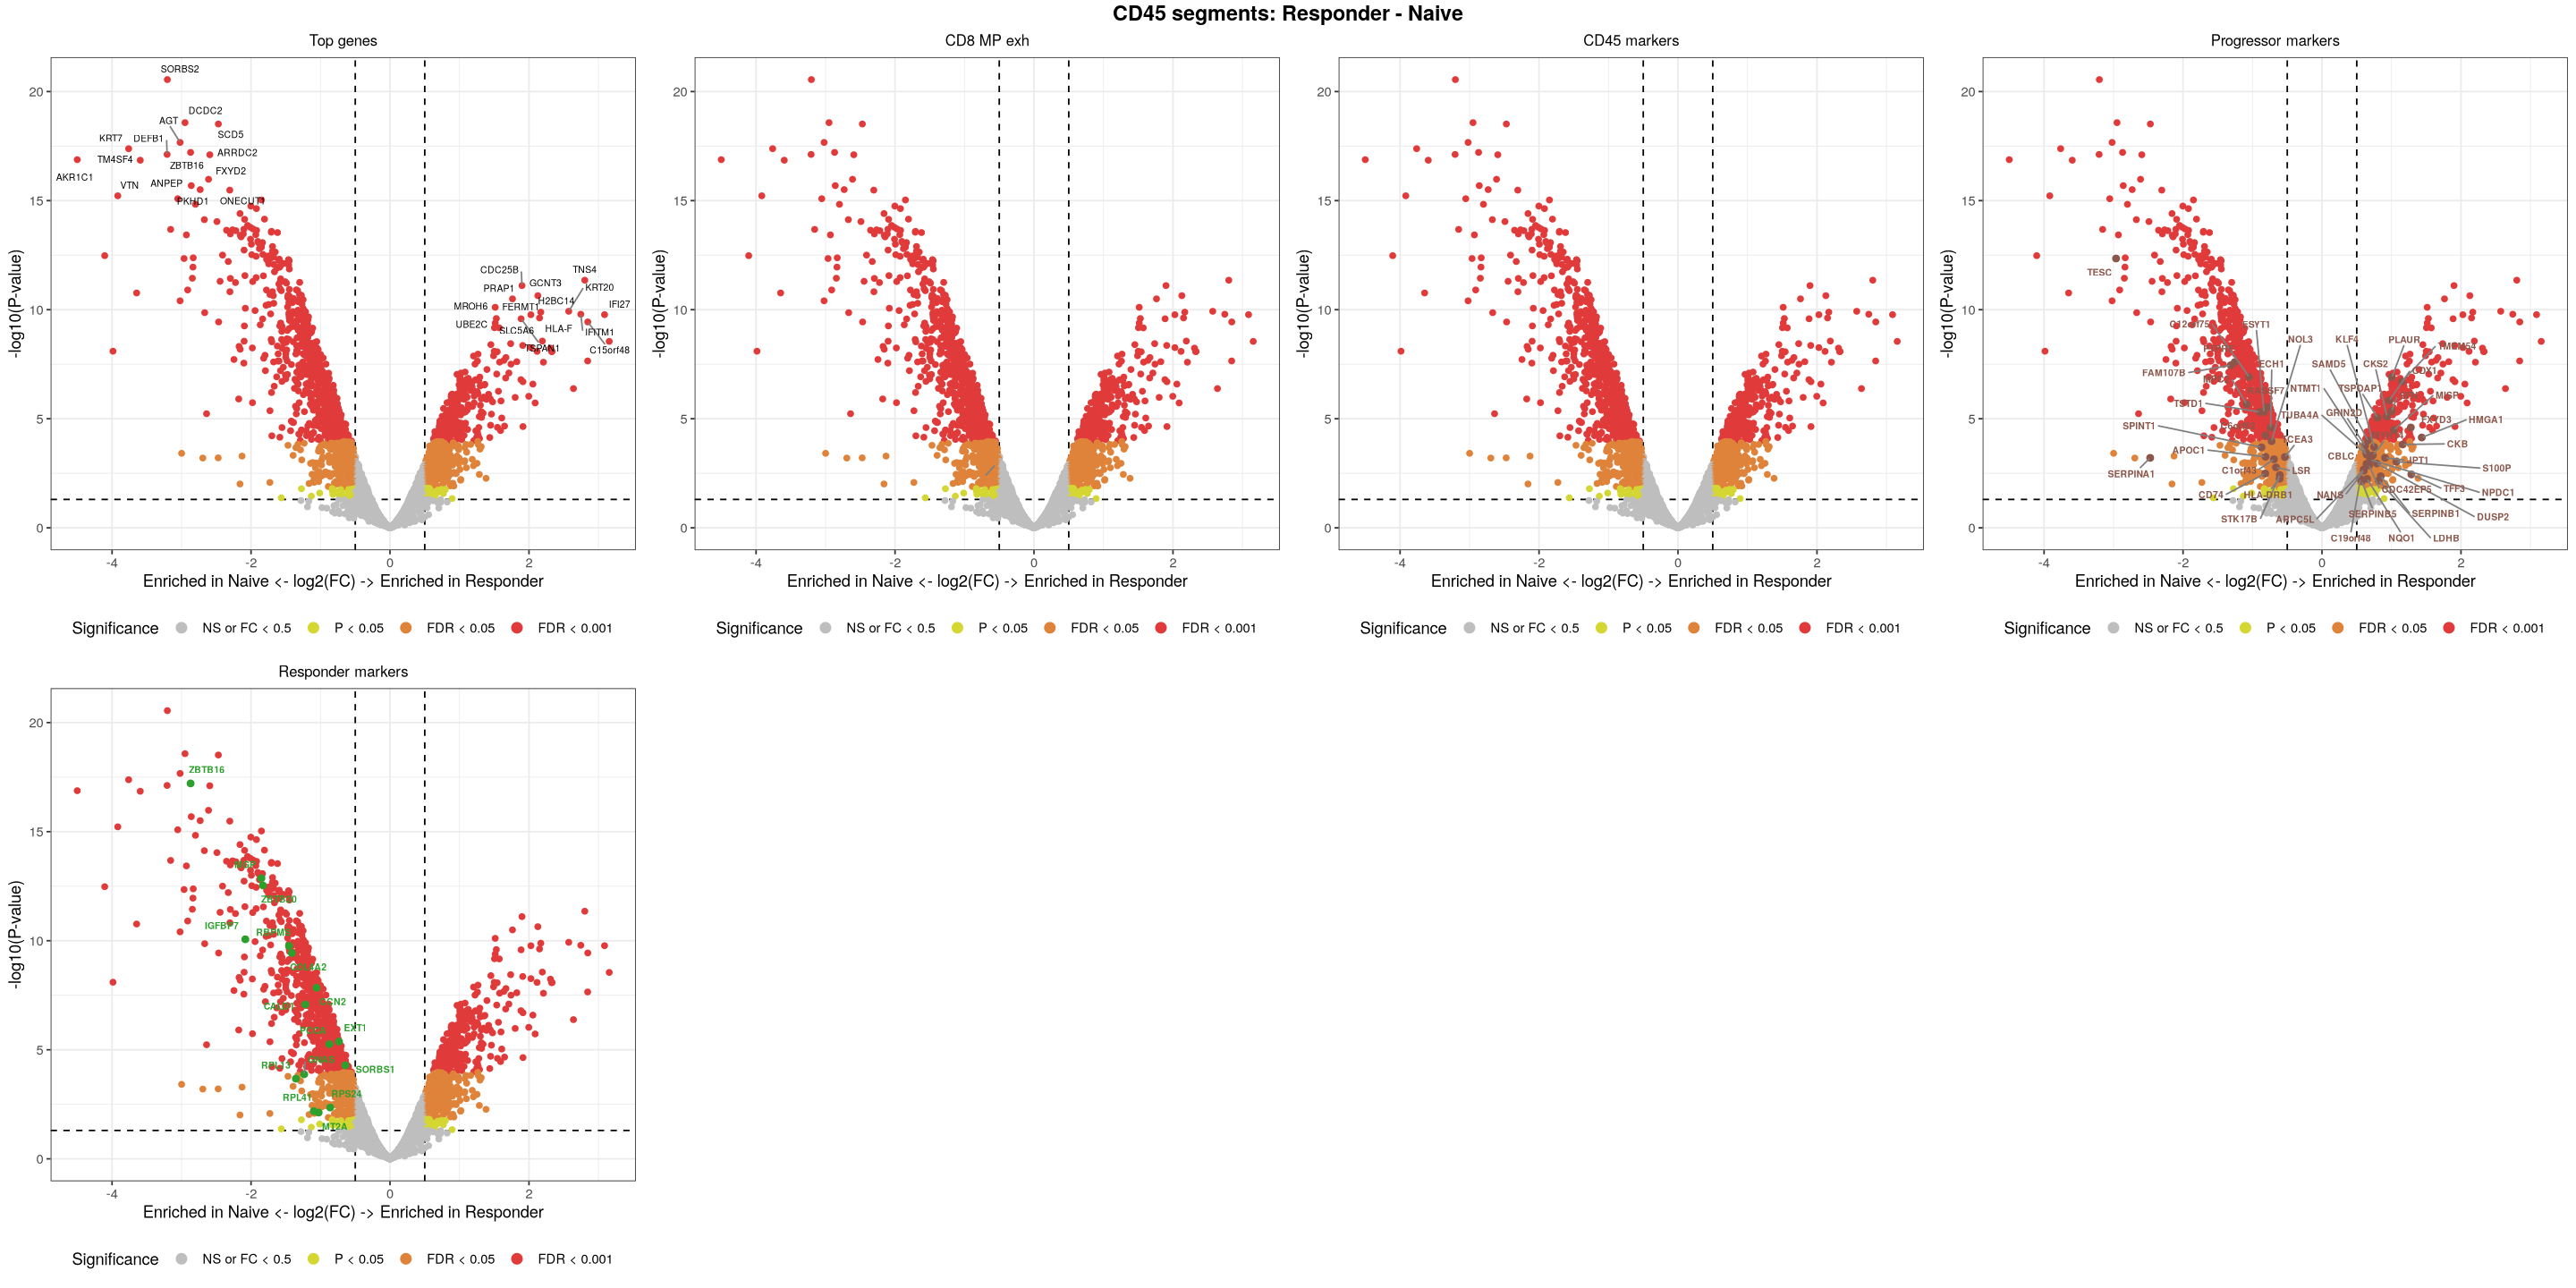

In [23]:
Progressor_Naive_results = topTags(cd45_results$df$Progressor_vs_Naive, n = Inf)$table
contrast = 'Progressor - Naive'
# Run the analysis
# Create list to store plots
plot_list <- list()

# Overview plot with top genes
plot_list[["Overview"]] <- edger_volcano_single(
  results = Progressor_Naive_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(cd45_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Progressor_Naive_results,
    contrast = contrast,
    gene_group = cd45_gene_groups[[group_name]],
    group_name = group_name,
    group_color = cd45_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("CD45 segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

Responder_Progressor_results = topTags(cd45_results$df$Responder_vs_Progressor, n = Inf)$table
contrast = 'Responder - Progressor'

plot_list <- list()

plot_list[["Overview"]] <- edger_volcano_single(
  results = Responder_Progressor_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(cd45_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Responder_Progressor_results,
    contrast = contrast,
    gene_group = cd45_gene_groups[[group_name]],
    group_name = group_name,
    group_color = cd45_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("CD45 segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

Responder_Naive_results = topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table
contrast = 'Responder - Naive'

plot_list <- list()

plot_list[["Overview"]] <- edger_volcano_single(
  results = Responder_Naive_results,
  contrast = contrast,
  show_top_genes = TRUE
)

# Individual gene group plots
for (group_name in names(cd45_gene_groups)) {
  plot_list[[group_name]] <- edger_volcano_single(
    results = Responder_Naive_results,
    contrast = contrast,
    gene_group = cd45_gene_groups[[group_name]],
    group_name = group_name,
    group_color = cd45_gene_group_colors[group_name],
    show_top_genes = FALSE
  )
}

options(repr.plot.width=24, repr.plot.height=12)
# Arrange in 2x4 grid
require(gridExtra)
grid_plot <- grid.arrange(
  grobs = plot_list,
  ncol = 4,
  nrow = 2,
  top = textGrob(paste("CD45 segments:",contrast), gp = gpar(fontsize = 14, fontface = "bold"))
)

# Display the grid
print(grid_plot)

In [24]:
plot_gene_heatmap <- function(results_df,geomx_dataset, gene_groups, gene_group_colors, top_n = 50,plot_title="") {
    top_genes <- unique(c(
      rownames(topTags(ck_results$df$Progressor_vs_Naive, n = top_n)$table),
      rownames(topTags(ck_results$df$Responder_vs_Naive, n = top_n)$table),
      rownames(topTags(ck_results$df$Responder_vs_Progressor, n = top_n)$table)
    ))

    logcpm <- cpm(cd45_results$y, log = TRUE)
    plot_data <- logcpm[top_genes, ]
    # Prepare data
    logcpm <- cpm(results_df$y, log = TRUE)
    plot_data <- logcpm[top_genes, ]
    annotation_col <- data.frame(Group = pData(geomx_dataset)$treatment_response)
    rownames(annotation_col) <- colnames(plot_data)
  
    # Cluster genes
    row_dist <- dist(t(scale(t(plot_data))), method = "euclidean")
    hc <- hclust(row_dist, method = "complete")
    ordered_genes <- rownames(plot_data)[hc$order]
  
    # Create gene colors
    gene_colors <- rep("black", length(ordered_genes))
    names(gene_colors) <- ordered_genes
  
    # Assign colors based on group membership
    for(group in names(gene_groups)) {
        genes_in_group <- gene_groups[[group]]
        gene_colors[names(gene_colors) %in% genes_in_group] <- gene_group_colors[group]
    }
  
    # Order data
    plot_data_ordered <- plot_data[ordered_genes, ]
    column_order <- order(annotation_col$Group)
    plot_data_ordered <- plot_data_ordered[, column_order]
    annotation_col_ordered <- annotation_col[column_order, , drop = FALSE]
  
    # Define colors
    group_colors <- c("naive" = "#e41a1c", "progressor" = "#367db7", "responder" = "#4cae49")
    heatmap_colors <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100)
      
    # Identify which groups are actually present in the heatmap
    present_groups <- names(gene_groups)[
        sapply(gene_groups, function(genes) any(genes %in% ordered_genes))
    ]
    print(present_groups)
    # Create heatmap
    ht <- Heatmap(
        t(scale(t(plot_data_ordered))),
        name = "Expression",  
        col = heatmap_colors,
        cluster_rows = FALSE,  
        cluster_columns = FALSE,  
        show_column_names = FALSE,  
        row_names_gp = gpar(col = gene_colors, fontsize = 5),
        top_annotation = HeatmapAnnotation(
          df = annotation_col_ordered,
          col = list(Group = group_colors),
          which = "col"
        ),
        column_title = plot_title,
        column_title_gp = gpar(fontsize = 14, fontface = "bold"),
        column_title_side = "top"  # This is the only line that changed
    )
  
    # Create legend only for present groups
    present_colors <- gene_group_colors[present_groups]
    legend_list <- list(
        Legend(
        labels = present_groups,
        title = "Gene Groups",
        type = "points",
        pch = 15,
        size = unit(0.3, "cm"),
        legend_gp = gpar(col = present_colors, fill = present_colors),
        ncol = 1
        )
    )
  
    # Draw heatmap with legend
    draw(ht,
        annotation_legend_list = legend_list,
        merge_legends = TRUE
    )
}

[1] "TC autophagy progressor" "MP14 EMT III"           
[3] "Progressor markers"      "Responder markers"      


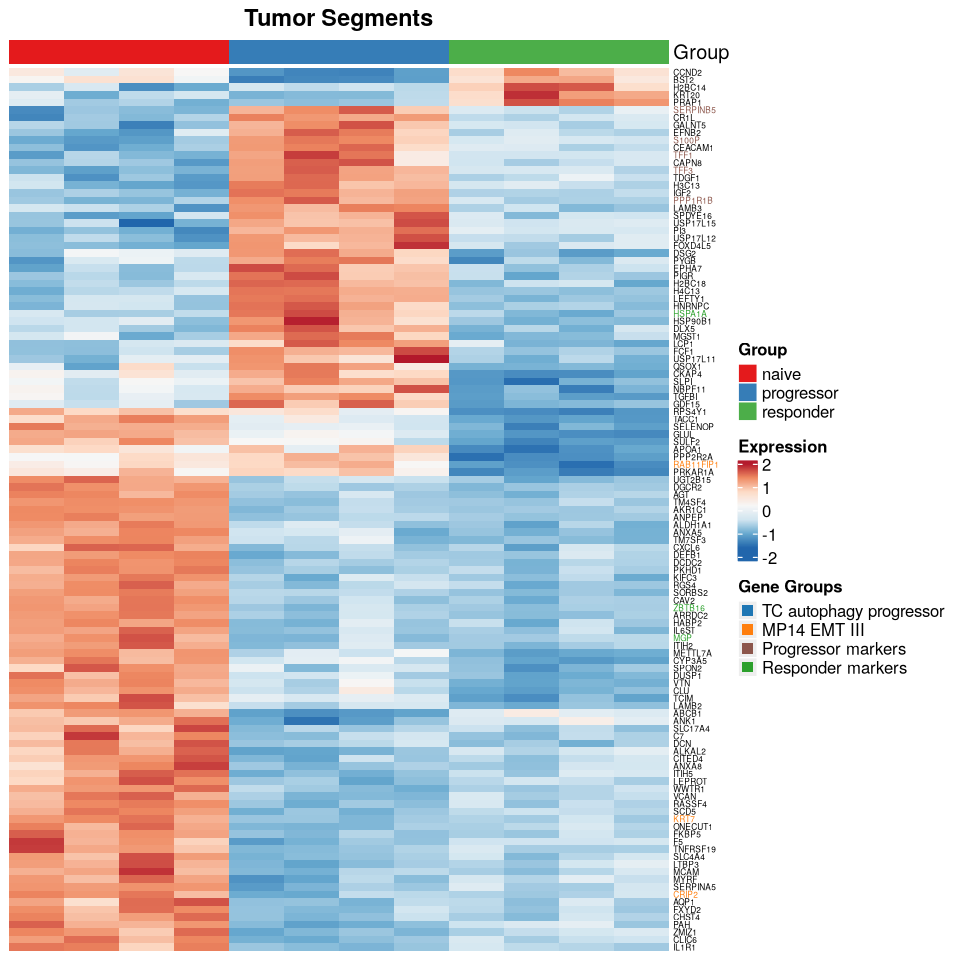

In [25]:
options(repr.plot.width=8, repr.plot.height=8)

plot_gene_heatmap(results_df = ck_results, 
                geomx_dataset=ck_subset,
                gene_groups = ck_gene_groups, 
                gene_group_colors = ck_gene_group_colors, 
                top_n = 50,
                 plot_title = "Tumor Segments")

[1] "CD8 MP exh"         "Progressor markers" "Responder markers" 


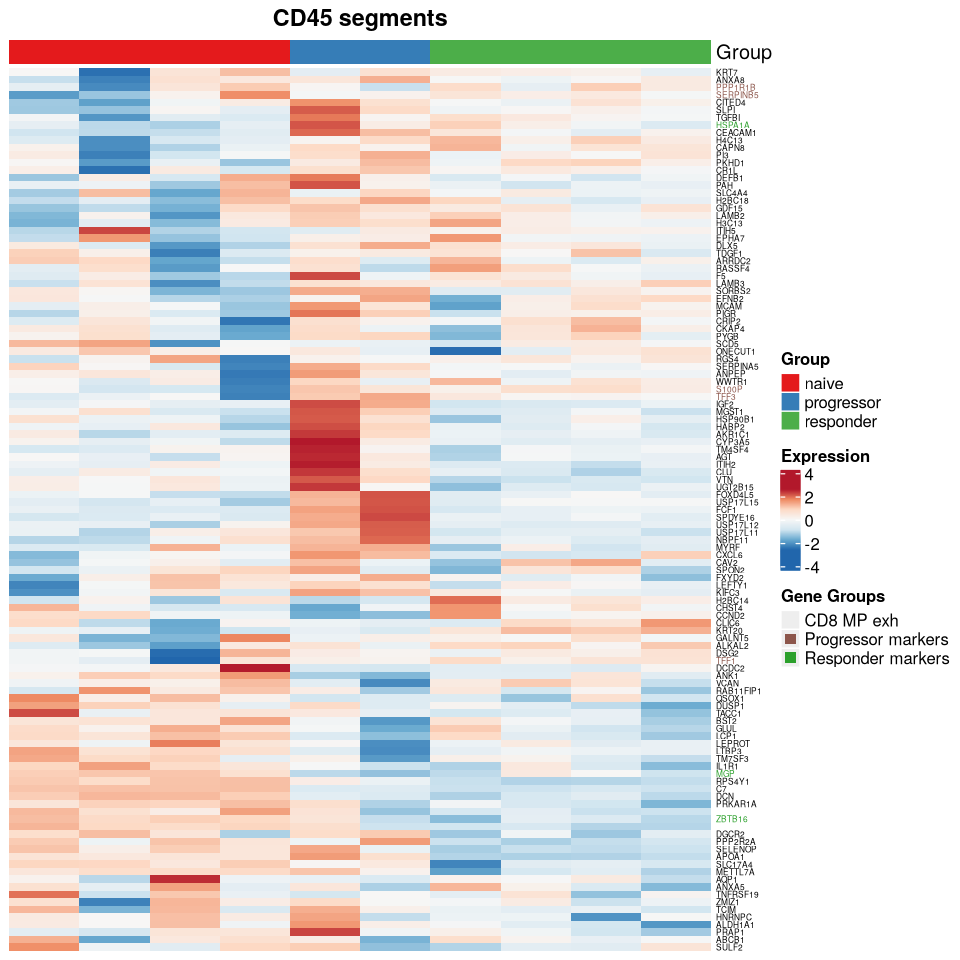

In [26]:
options(repr.plot.width=8, repr.plot.height=8)

plot_gene_heatmap(results_df = cd45_results, 
                geomx_dataset=cd45_subset,
                gene_groups = cd45_gene_groups, 
                gene_group_colors = cd45_gene_group_colors, 
                top_n = 50,
                 plot_title= "CD45 segments")        

In [27]:
top_genes <- function(res_df, pos = T) {
    if (pos) {
        res <- subset(res,FDR < 0.05 & logFC > 0.5)    
    } else {
        res <- subset(res,FDR < 0.05 & logFC  < -0.5)    
    }
    res$entrez <- mapIds(org.Hs.eg.db,
                        keys = rownames(res),
                        column = "ENTREZID",
                        keytype = "SYMBOL") 
    
    geneList <- res$logFC
    names(geneList) <- res$entrez
    if (pos) {
        geneList <- sort(geneList, decreasing = TRUE)
    } else {
        geneList <- sort(geneList, decreasing = FALSE)
        geneList <- abs(geneList)

    }
    geneList <- geneList[!is.na(names(geneList))]
return(geneList)
}
enrichment_plots <- function(genelist) {
  ### GO Enrichment Analysis
  go_bp <- tryCatch({
    gseGO(
      geneList     = genelist,
      OrgDb        = org.Hs.eg.db,
      ont          = "BP",
      keyType      = "ENTREZID",
      minGSSize    = 5,
      maxGSSize    = 500,
      pvalueCutoff = 0.05,
      verbose      = FALSE
    )
  }, error = function(e) {
    message("GO enrichment failed: ", e$message)
    return(NULL)
  })
  
  p1 <- NULL
  if (!is.null(go_bp) && nrow(go_bp@result) > 0) {
    p1 <- dotplot(go_bp, showCategory=10, font.size=8) + 
      theme_bw() +
      ggtitle("GO Biological Processes")
  } else {
    message("No significant GO terms found.")
  }
  
  ### KEGG Pathway Analysis
  kegg <- tryCatch({
    gseKEGG(
      geneList     = genelist,
      organism     = "hsa",
      minGSSize    = 5,
      maxGSSize    = 500,
      pvalueCutoff = 0.05,
      verbose      = FALSE
    )
  }, error = function(e) {
    message("KEGG enrichment failed: ", e$message)
    return(NULL)
  })
  
  p2 <- NULL
  if (!is.null(kegg) && nrow(kegg@result) > 0) {
    p2 <- dotplot(kegg, showCategory=10) + 
      theme_bw() +
      ggtitle("KEGG Pathways")
  } else {
    message("No significant KEGG pathways found.")
  }
  return(list(p1=p1, p2=p2))
}

'select()' returned 1:1 mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



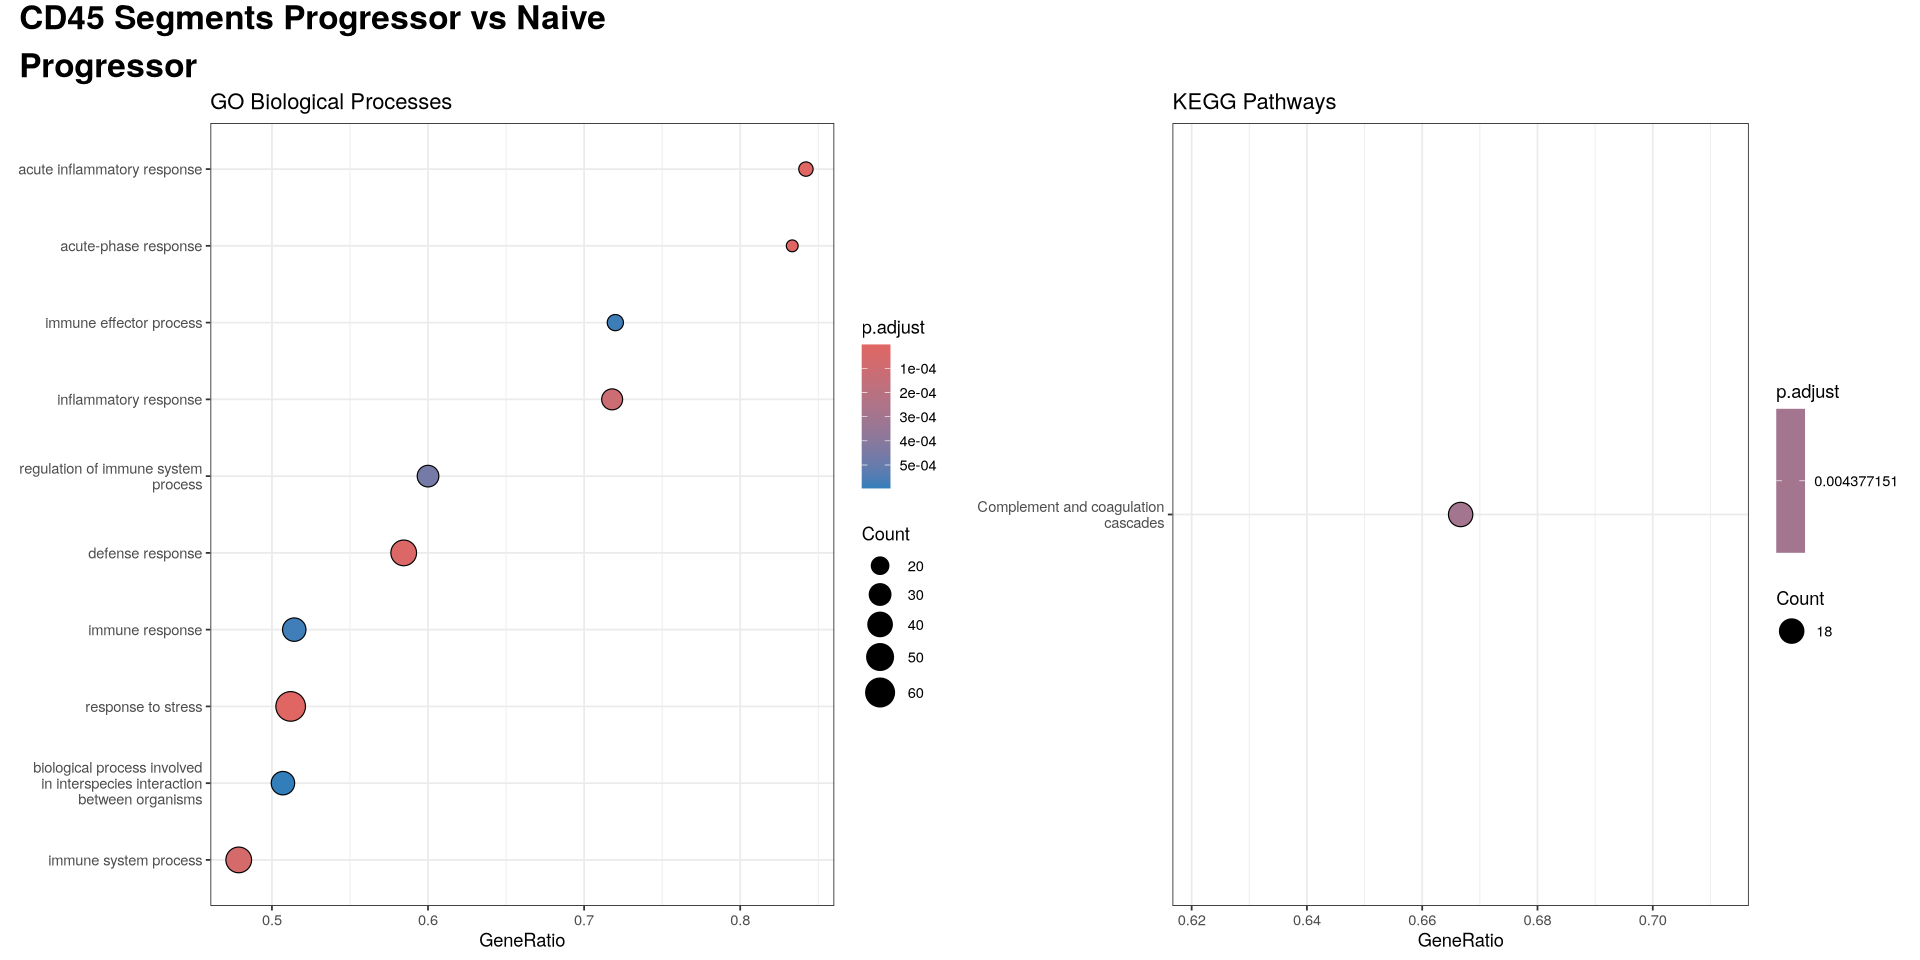

In [28]:
options(warn=-1)
options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(cd45_results$df$Progressor_vs_Naive, n = Inf)$table
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Progressor vs Naive\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

# options(repr.plot.width=16, repr.plot.height=8)
# res <- topTags(cd45_results$df$Responder_vs_Naive, n = Inf)$table
# genes <- top_genes(res)
# plots <- enrichment_plots(genes)
# grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Responder vs Naive\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

# options(repr.plot.width=16, repr.plot.height=8)
# res <- topTags(cd45_results$df$Responder_vs_Progressor, n = Inf)$table
# genes <- top_genes(res)
# plots <- enrichment_plots(genes)
# grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Responder vs Progressor\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



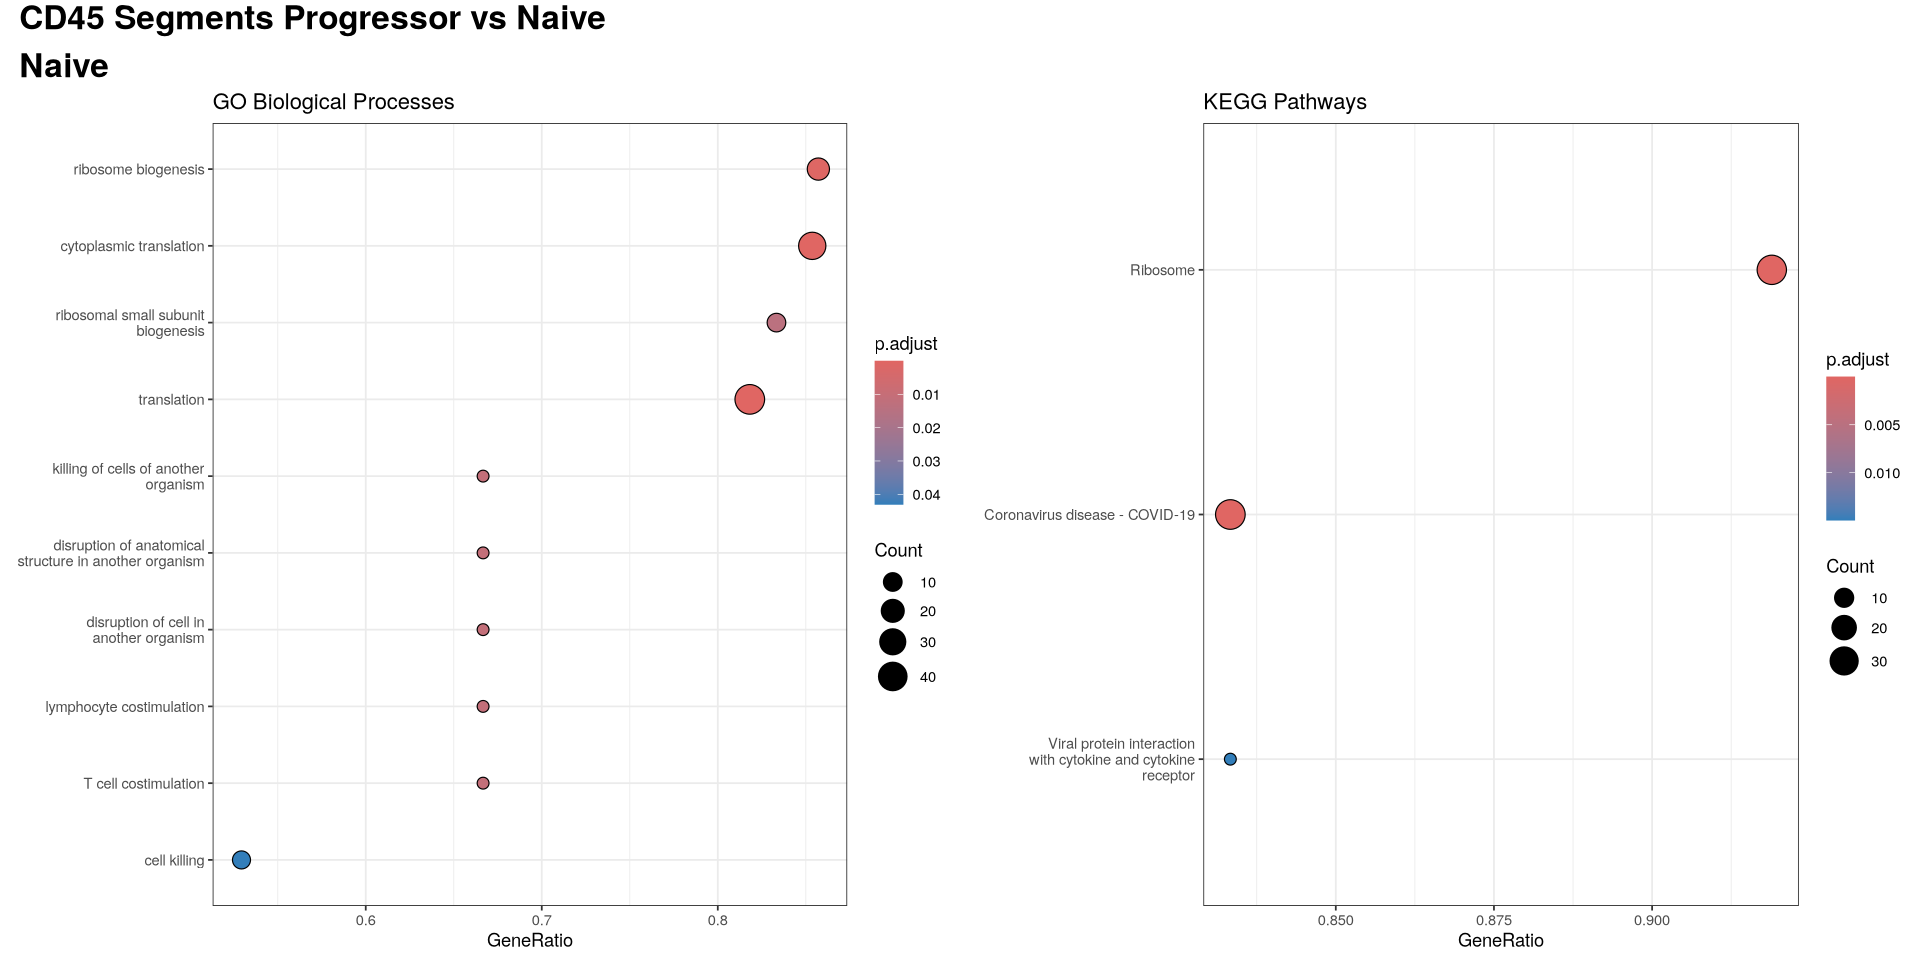

'select()' returned 1:1 mapping between keys and columns



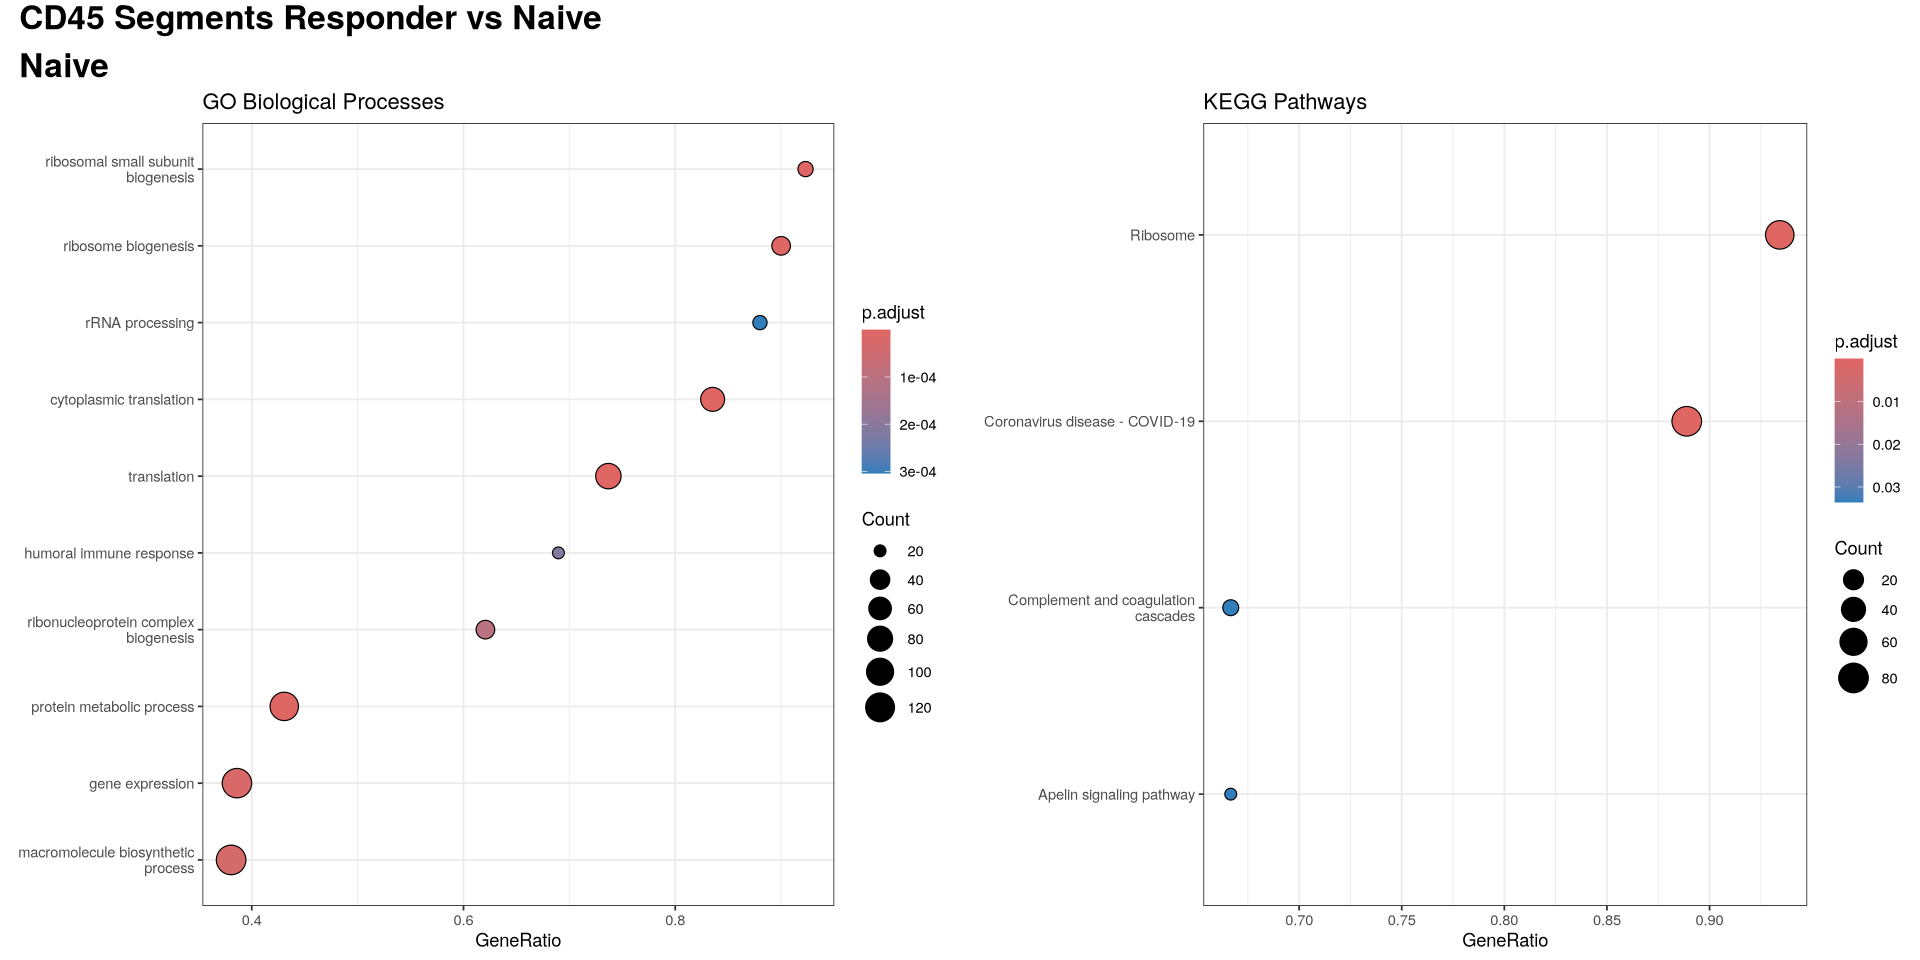

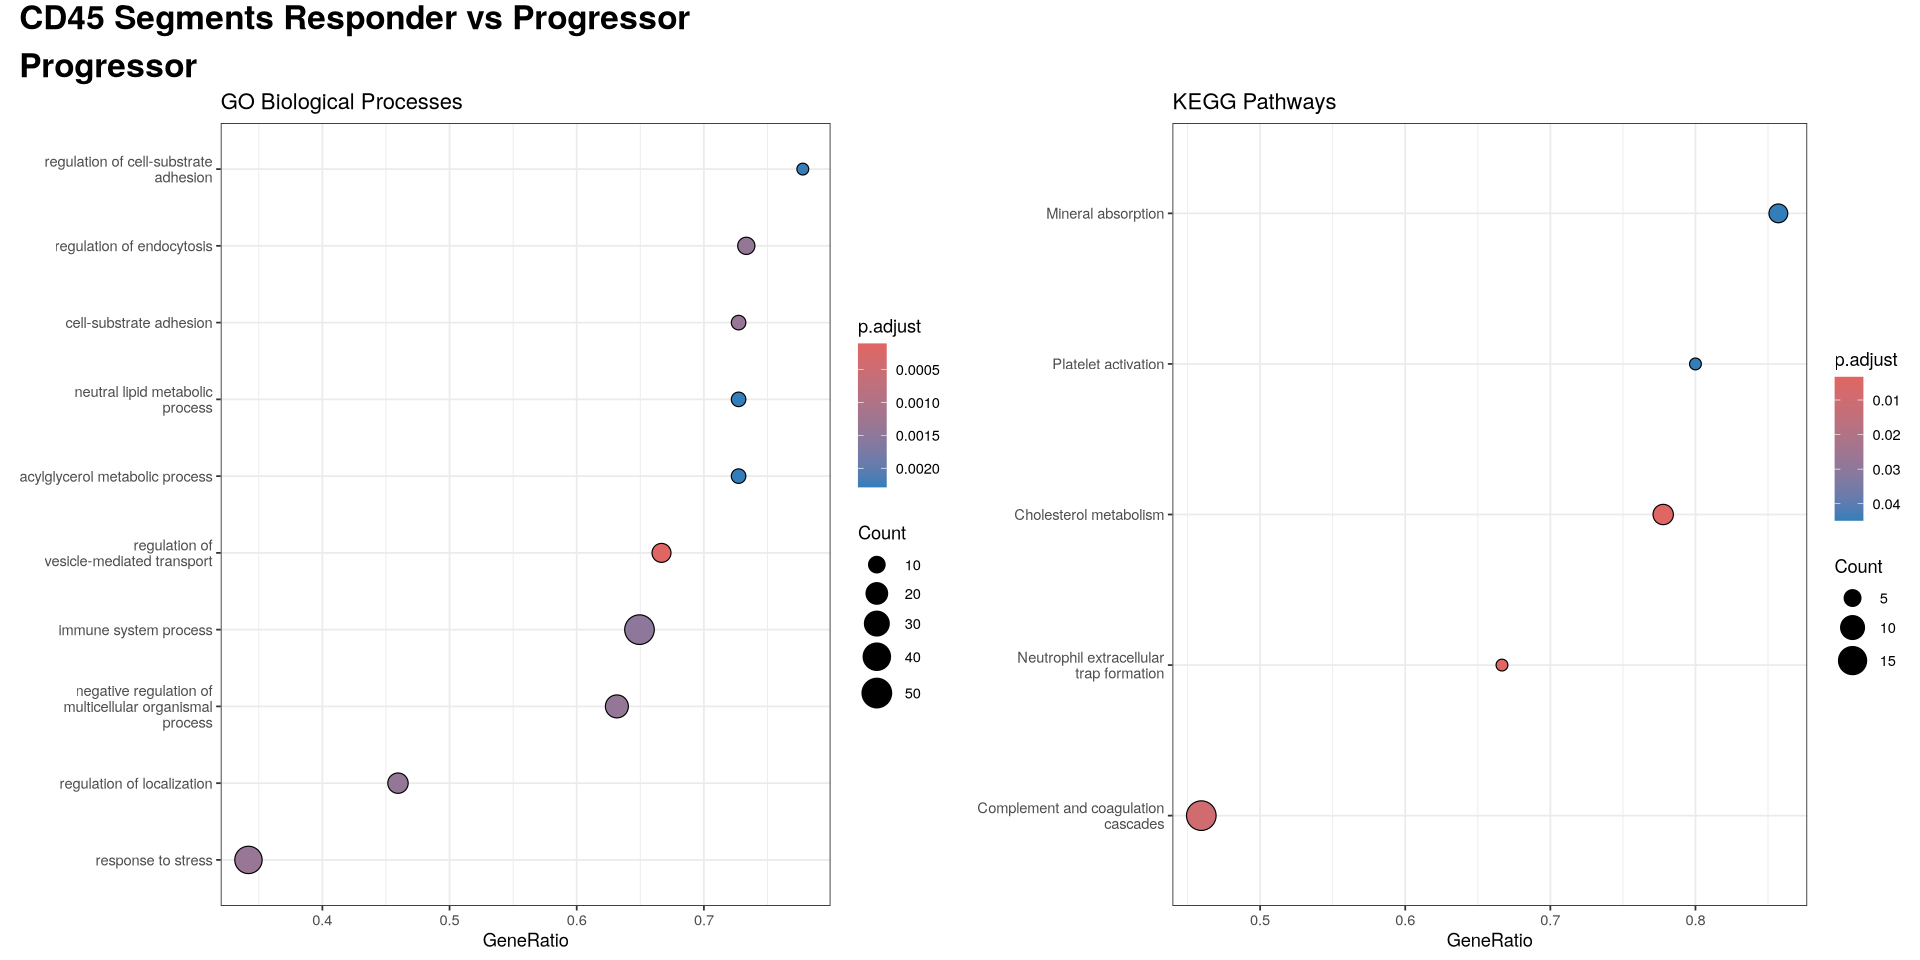

In [29]:
options(warn=-1)
options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(cd45_results$df$Progressor_vs_Naive, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Progressor vs Naive\nNaive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)

res <- topTags(cd45_results$df$Responder_vs_Naive, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Responder vs Naive\nNaive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(cd45_results$df$Responder_vs_Progressor, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CD45 Segments Responder vs Progressor\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



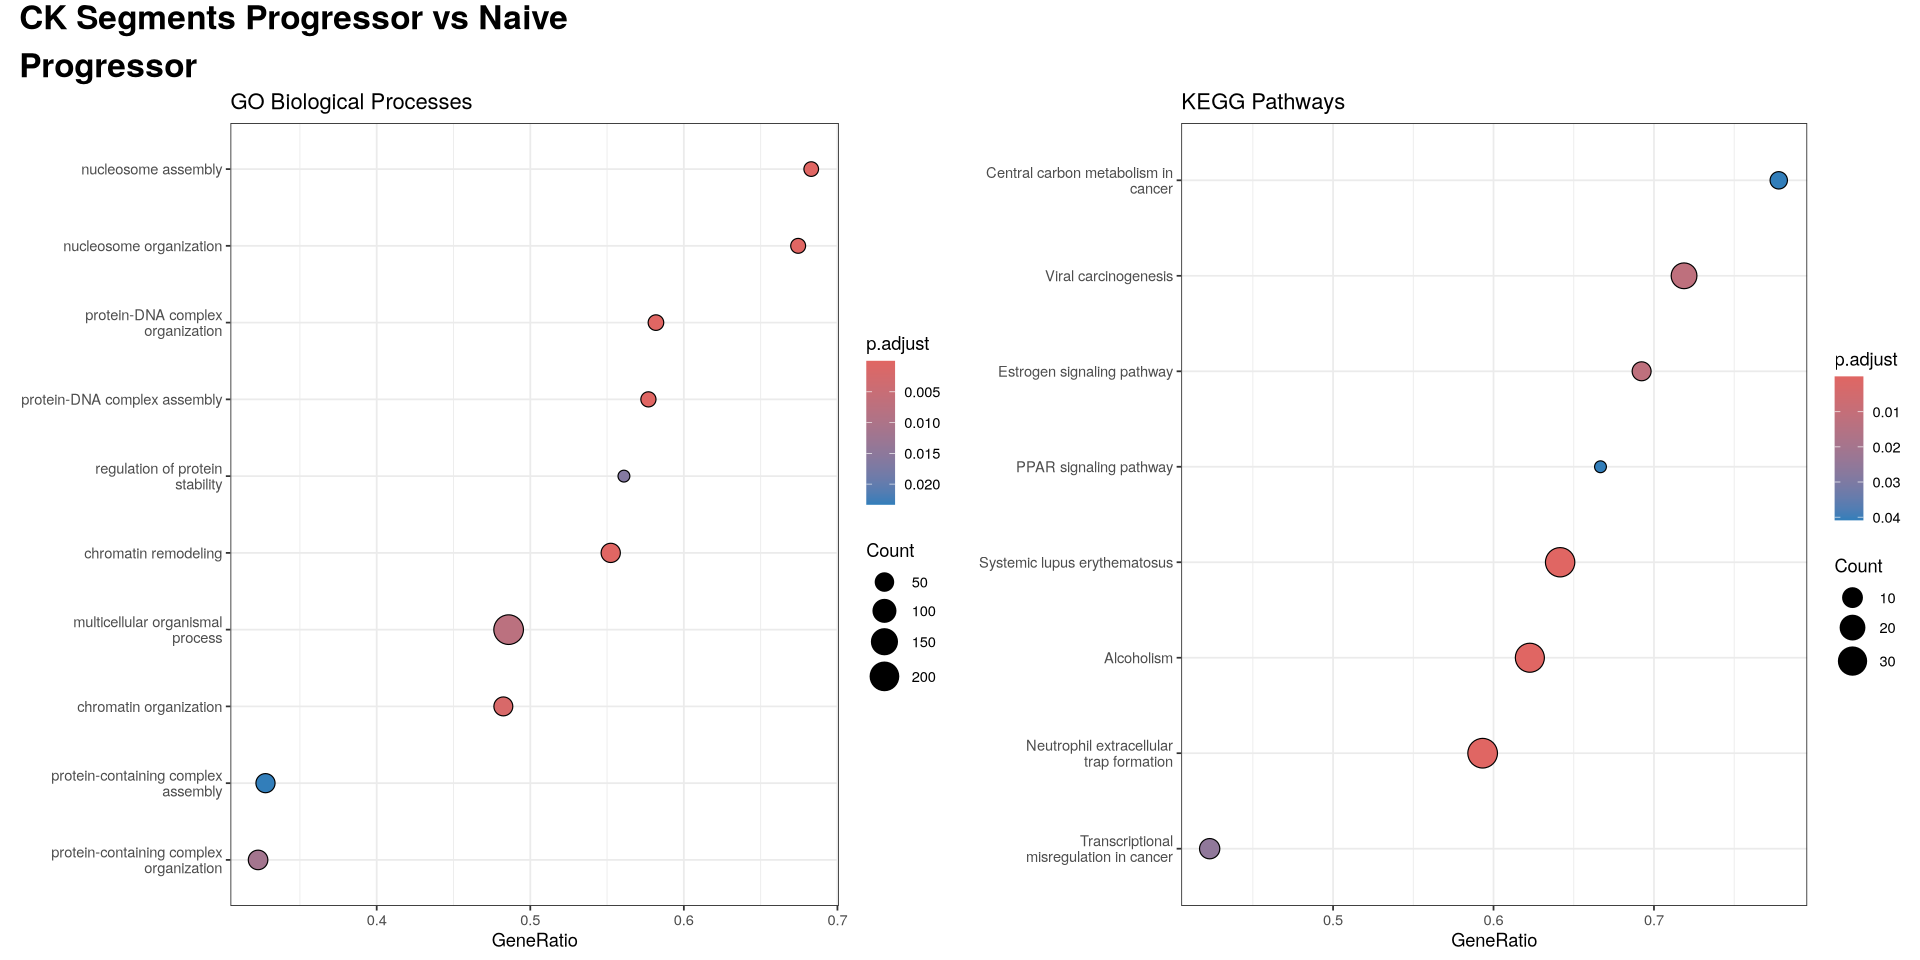

'select()' returned 1:1 mapping between keys and columns



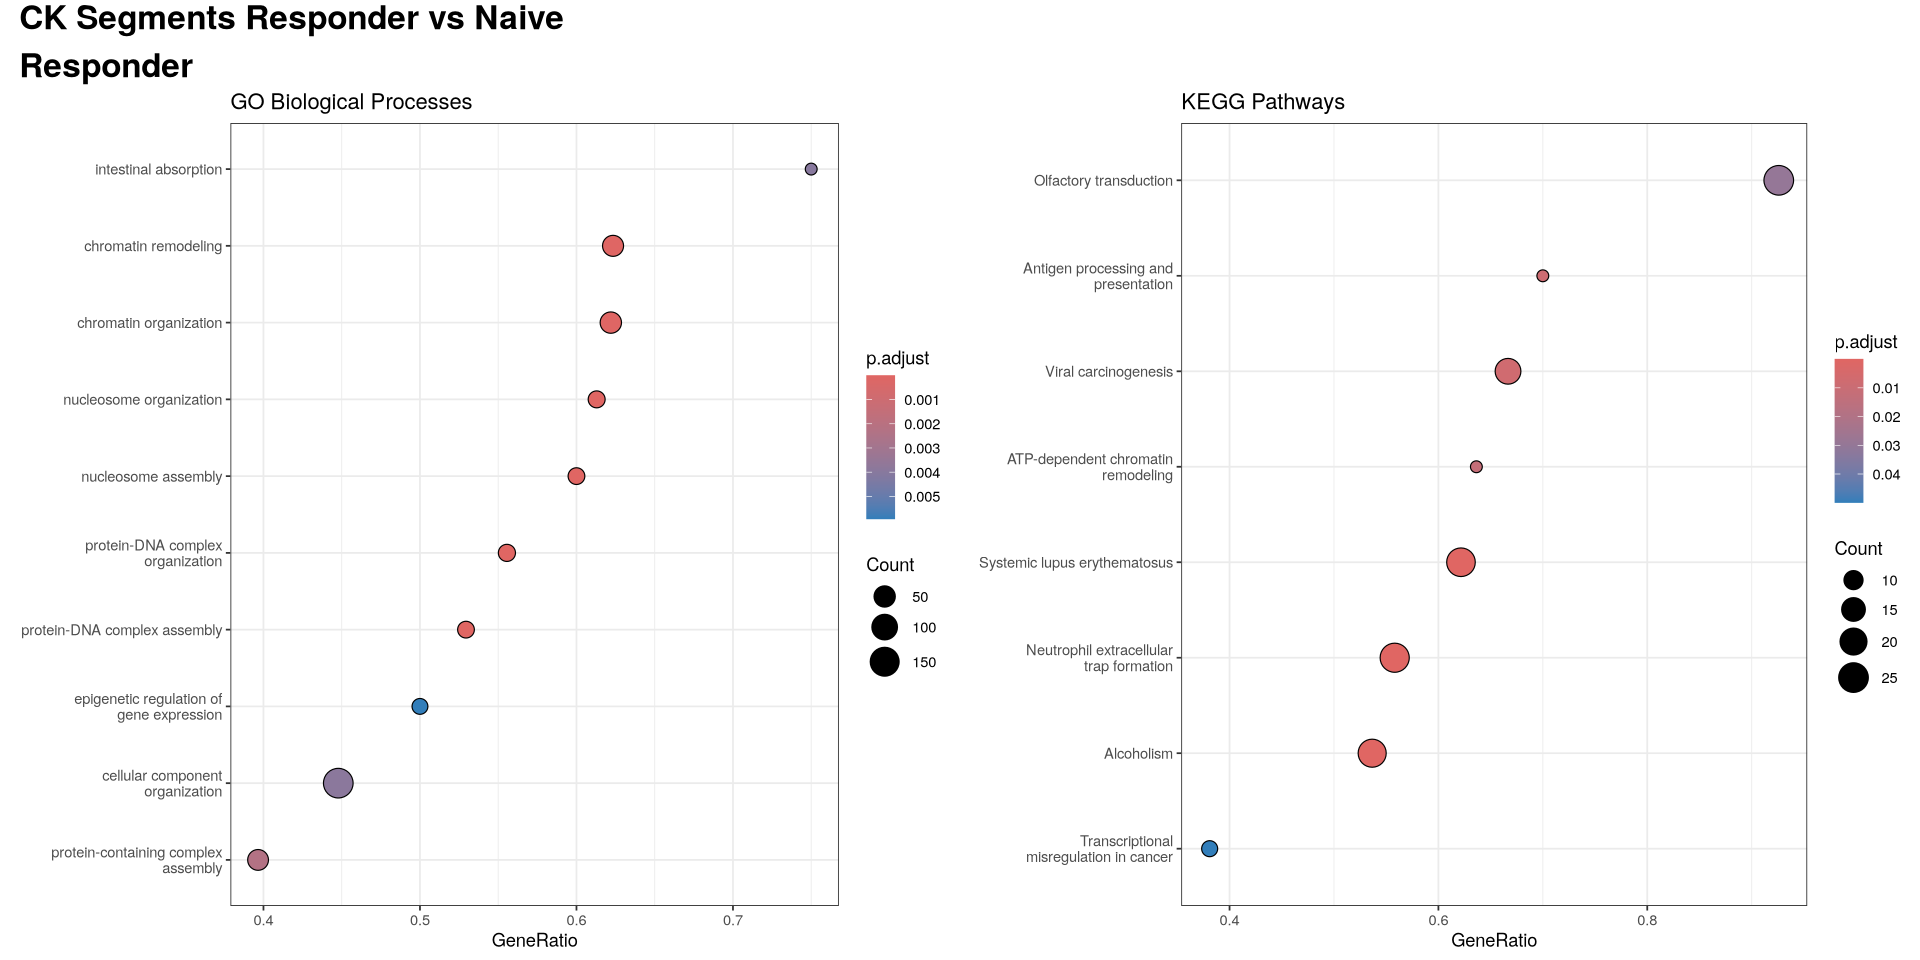

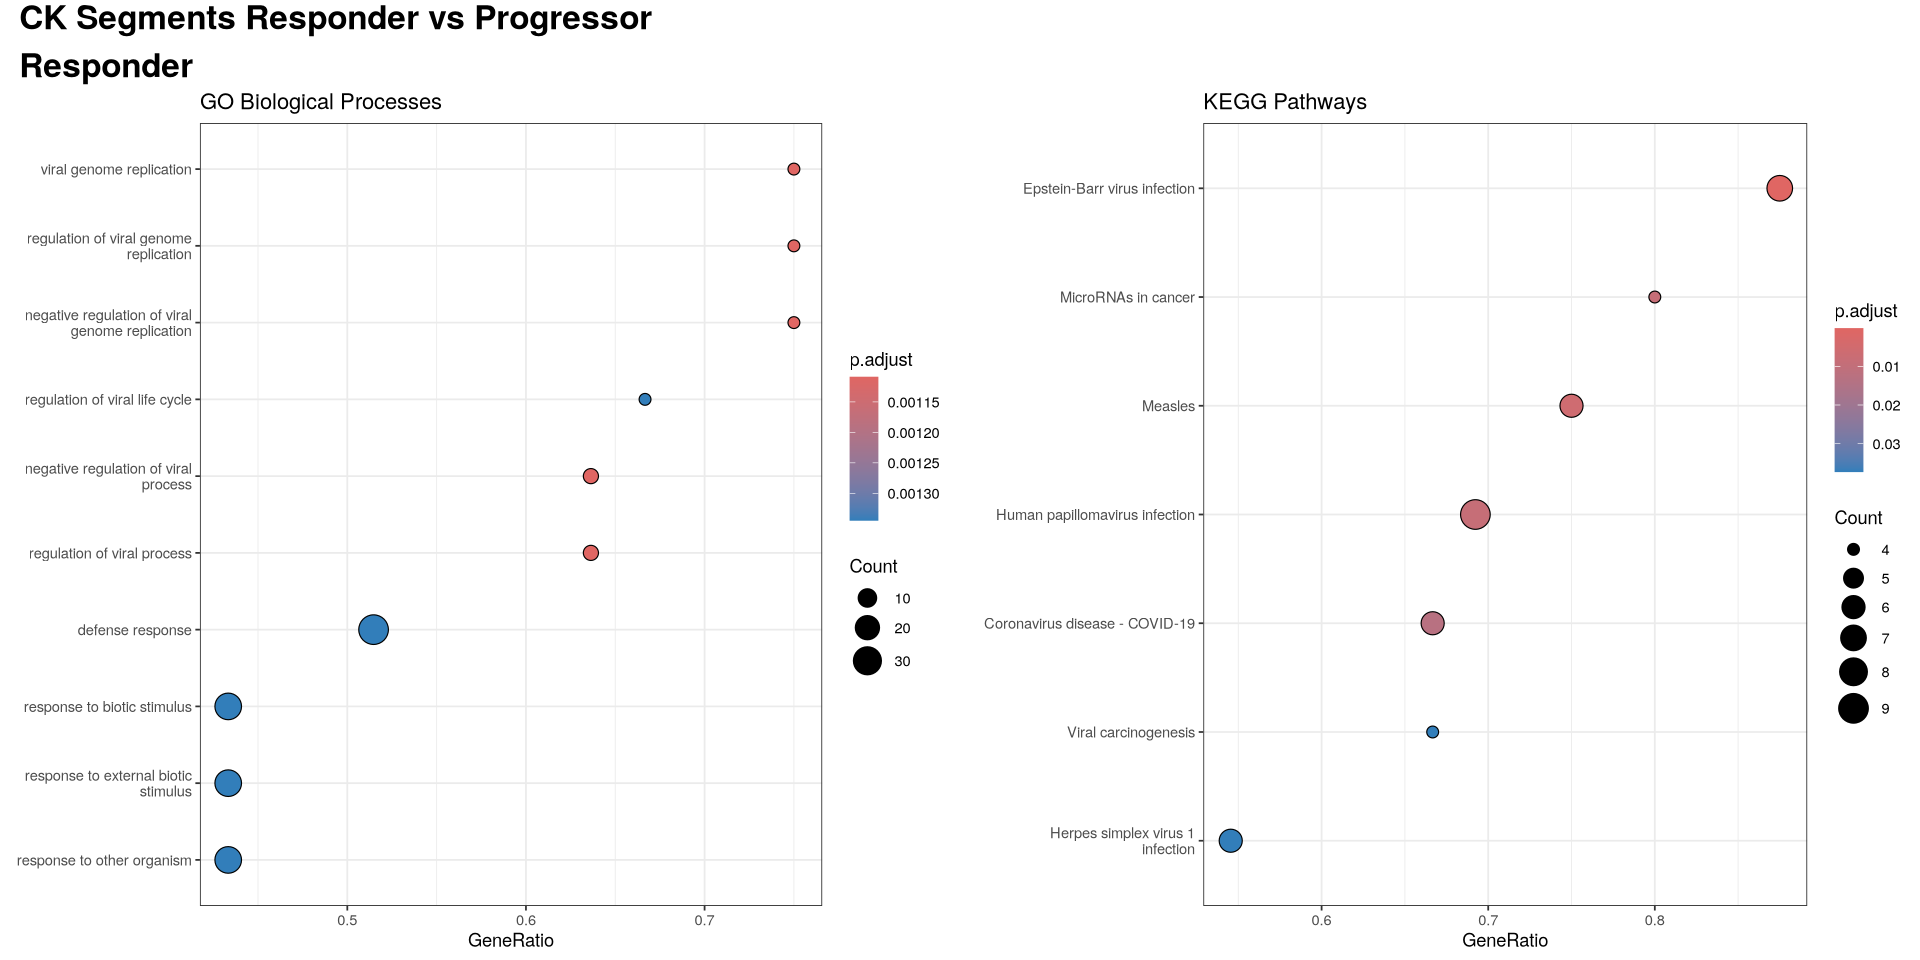

In [30]:
options(warn=-1)
options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(ck_results$df$Progressor_vs_Naive, n = Inf)$table
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Progressor vs Naive\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)

res <- topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Naive\nResponder",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Progressor\nResponder",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



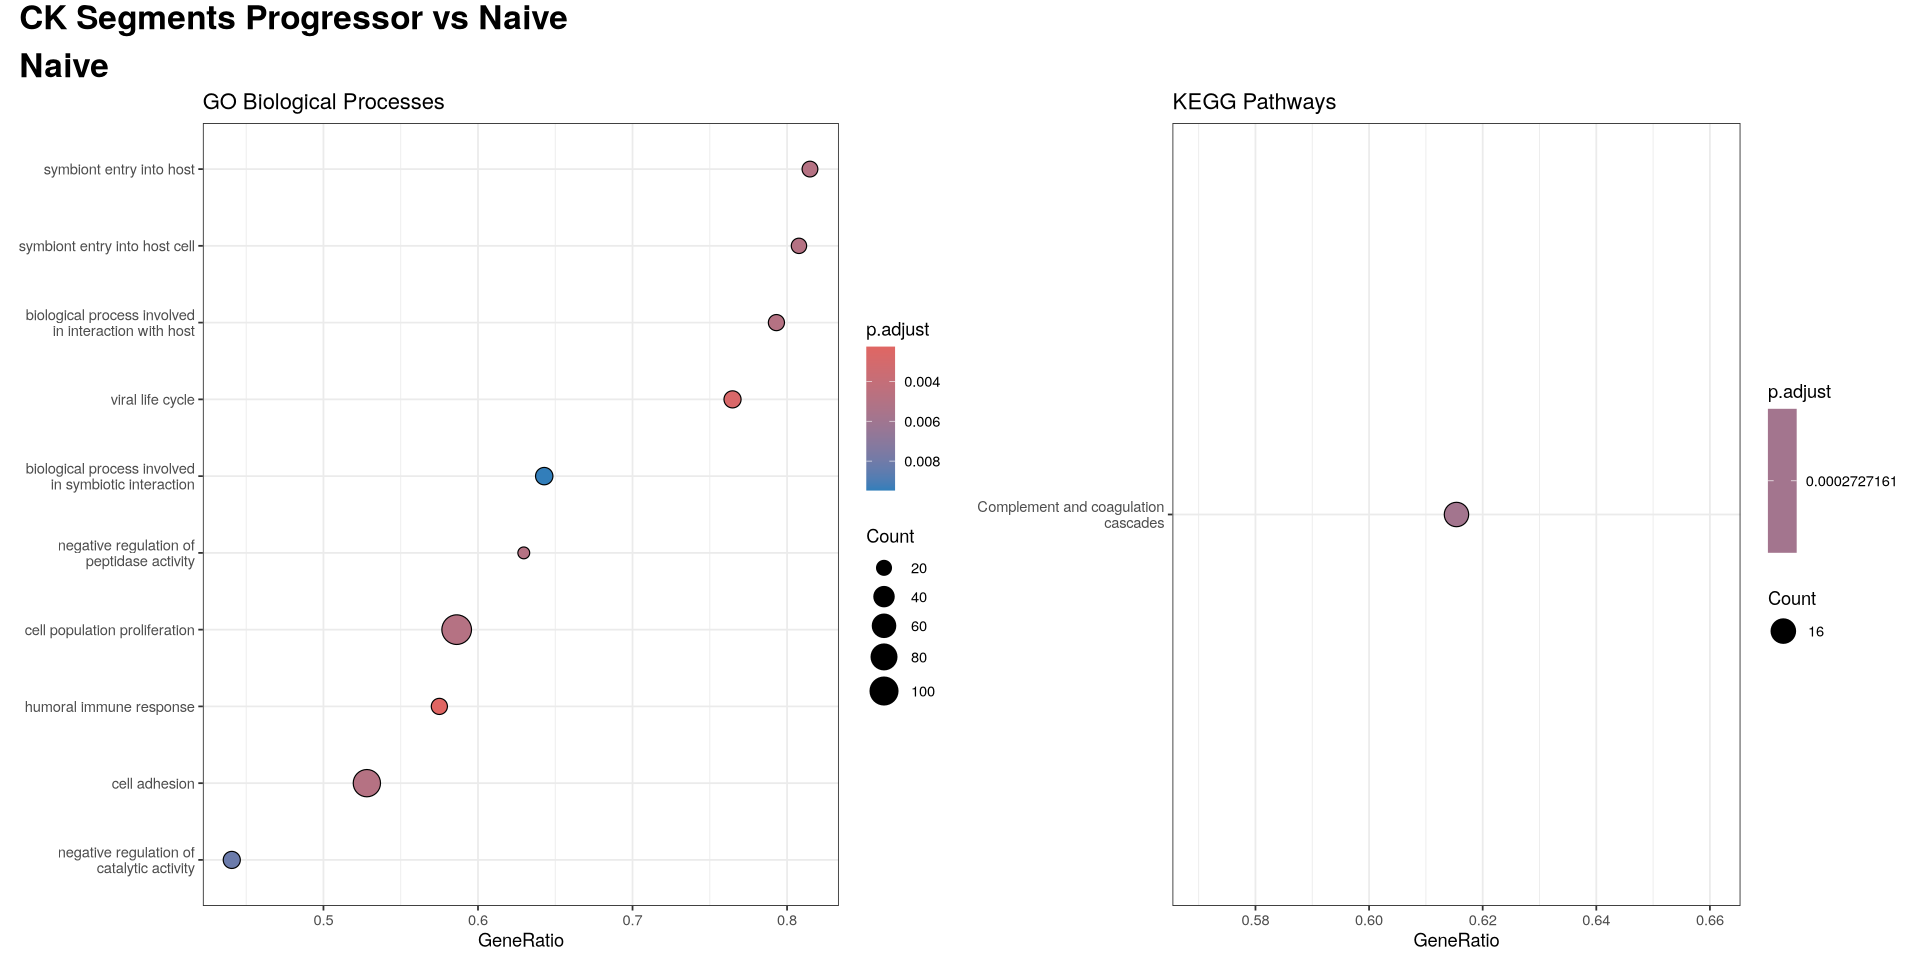

'select()' returned 1:1 mapping between keys and columns



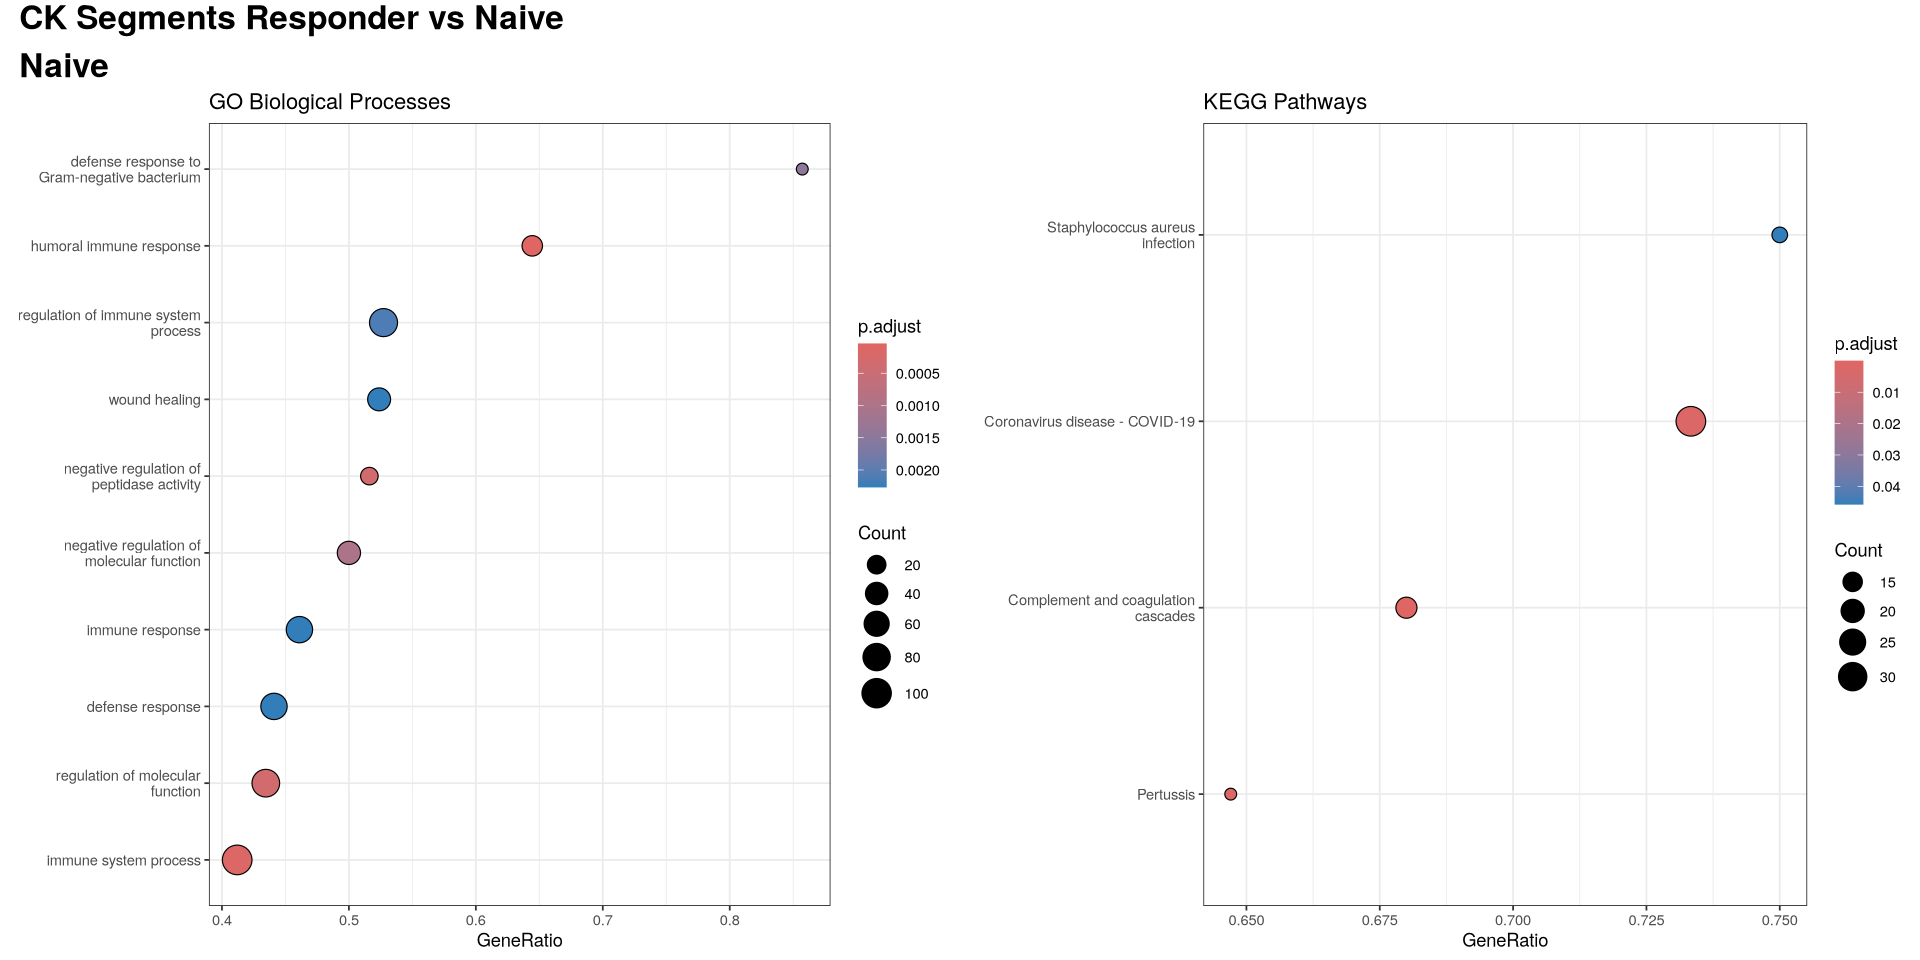

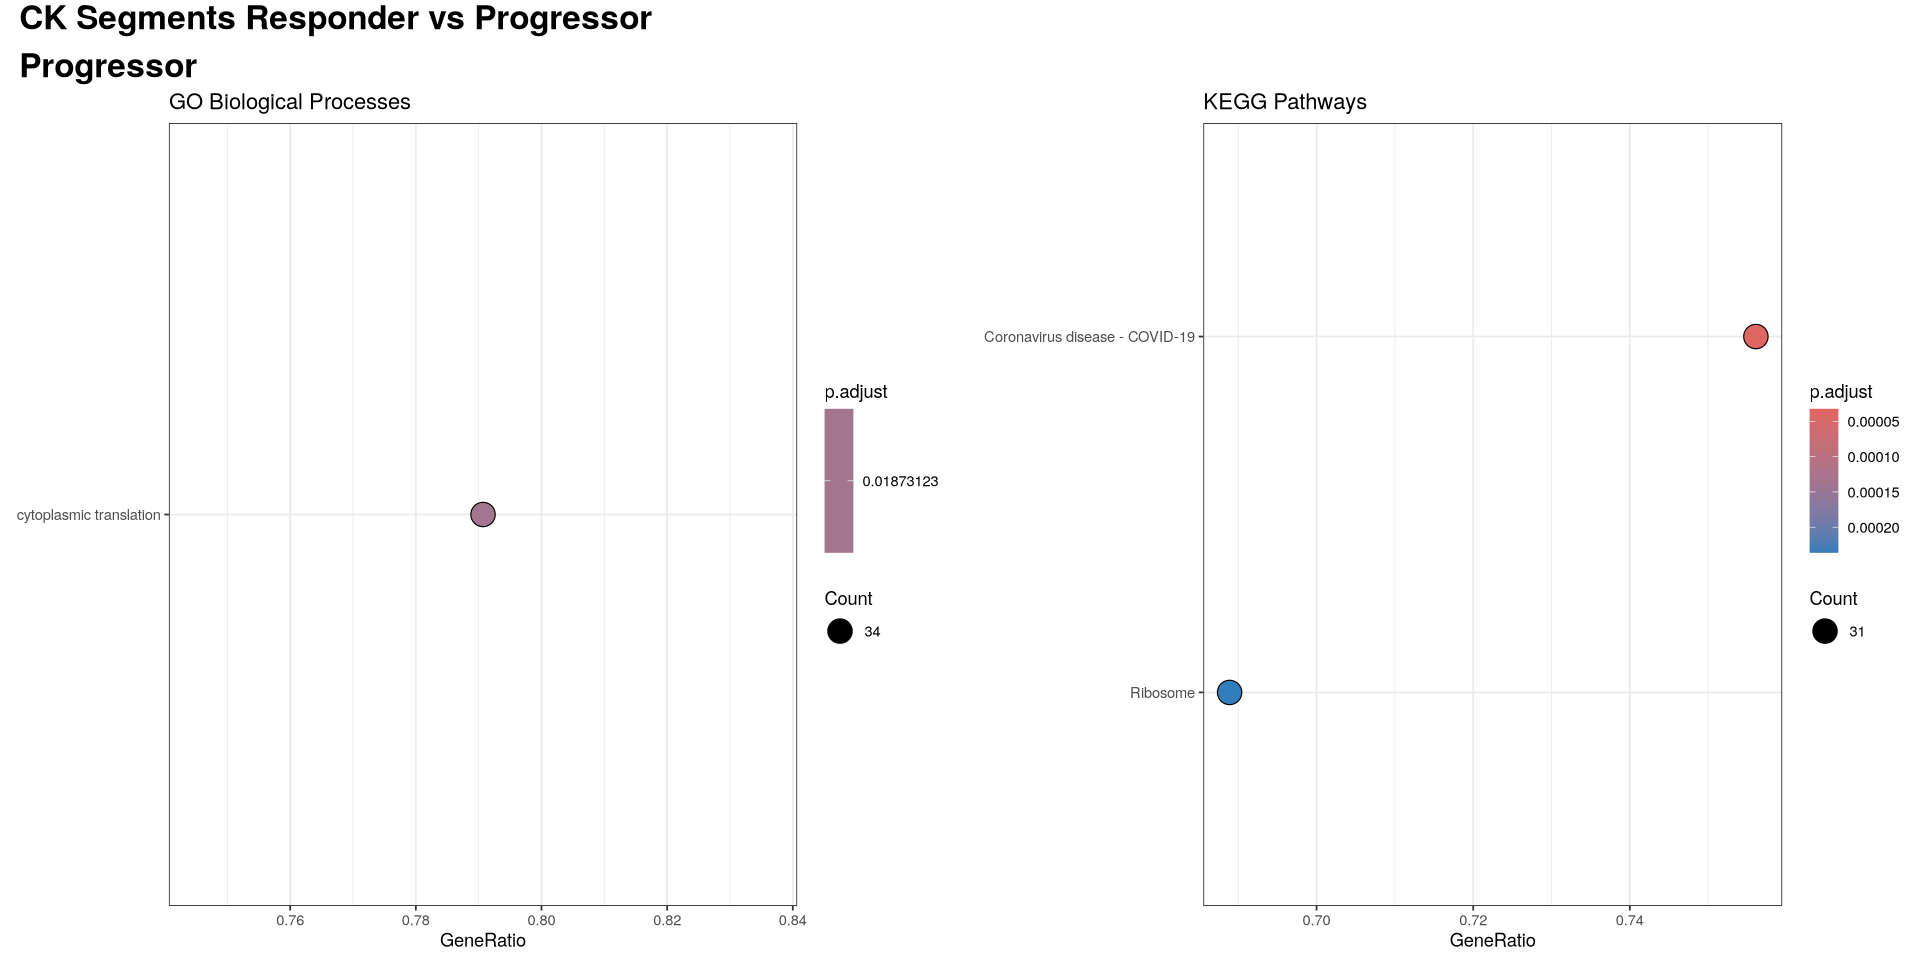

In [31]:

options(warn=-1)
options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(ck_results$df$Progressor_vs_Naive, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Progressor vs Naive\nNaive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)

res <- topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Naive\nNaive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table
genes <- top_genes(res,pos=F)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Progressor\nProgressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

In [32]:
genes = c("COL6A3", "GPC6", "RARRES2", "DCN", "BICC1", "LUM", "C1S", "COL5A1", "ANTXR1", "COL12A1", "VCAN", "CDH11","COL18A1", "SOX5", "EBF1", "DLC1", "RGS5", "PDGFRB", "LHFPL6", "CACNA1C", "FILIP1L", "CCDC102B", "NOTCH3", "MGP", "RBMS3","CD3", "CD8", "PD1", "GZMB", "LAG3", "TIM3", "HLA-DPB1", "FTL", "FTH1", "RPL10", "TPT1", "TMSB4X", "RPL13", "TMSB10", "EEF1A1", "RPS12", "BDCA-2", "CD1A", "CD11C", "CD83", "XCR1", "CD86", "CD4", "CD45", "CD25", "CD69", "FOXP3", "CTLA4", "CD38", "MTRNR2L1", "CDX1", "PLP2", "TFF3", "VAMP8", "GPX2", "DBI", "CLIC1", "KRT18", "PTPRK", "KRT19", "PHGR1", "LLGL2", "LMO7", "CTNND1", "AGAP1", "MAP7", "LINC00511")
subtypes = c("FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1", "FC1","FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2", "FC2","Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "Exhausted CD8", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "responder_dc_sig", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "DCs markers", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Progressor", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder", "Responder")
cell_types = c("fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","fibroblast","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Marker TOE","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells","Markers Tumor Cells")
df = data.frame(genes= genes , subtypes = subtypes, cell_type = cell_types)

fc1 =df[df$subtypes == 'FC1',]$genes
fc2 =df[df$subtypes == 'FC2',]$genes
exhausted_cd8 =df[df$subtypes == 'Exhausted CD8',]$genes
dc_markers =df[df$subtypes == 'DCs markers',]$genes
Progressor =df[df$subtypes == 'Progressor',]$genes
Responder =df[df$subtypes == 'Responder',]$genes
responder_dc_sig =df[df$subtypes == 'responder_dc_sig',]$genes
unknown =df[df$subtypes == 'unknown',]$genes

signature_5Ato30 = c("CXCL2", "CXCL8", "CXCL3", "CXCL1", "CREB5", "EMP1", "KLF10", "RELB", "EPHA2", "TUBA1A", "PMAIP1", "IRF1", "GADD45B", "TCIM", "HBEGF", "TNAIP3", "TNFRSF12A", "BCL3", "MAFF", "TMEM265", "NFKBIA", "CTSB", "PIM3", "ABTB2", "ANXA1", "PLAUR", "CCN1", "RND3", "TUBB2A", "FOSL1")
apoptotic_hallmarks = c("CASP1", "CASP2", "CASP3", "CASP4", "CASP6", "CASP7", "CASP8", "CASP9", "ENO2", "ERBB2", "ERBB3", "F2", "F2R", "FAS", "GPX1", "GPX3", "GPX4", "GSTM1", "HGF", "HMGB2", "IRF1", "LGALS3", "MMP2", "PDGFRB", "RELA", "RHOB", "TGFB2", "TGFBR3", "TNF")
cd45_markers = c("CD3E","CD8A","PDCD1","LAG-3","HAVCR2")
ck_markers = c("CXCL1", "CXCL2", "CXCL3","CXCL8")

# Create a list data frame
data <- list(signature_5Ato30 = signature_5Ato30, 
             apoptotic_hallmarks = apoptotic_hallmarks,
             ck_markers = ck_markers,
             fc1 =fc1,
             fc2 =fc2,
            exhausted_cd8 = exhausted_cd8,
dc_markers =dc_markers,
Progressor =Progressor,
Responder =Responder,
responder_dc_sig =responder_dc_sig,
unknown =unknown)

# Convert to LaTeX
kable(data, "latex", booktabs = TRUE) %>%
  kable_styling()

\begin{table}
\centering
\centering
\begin{tabular}[t]{l}
\toprule
x\\
\midrule
CXCL2\\
CXCL8\\
CXCL3\\
CXCL1\\
CREB5\\
\addlinespace
EMP1\\
KLF10\\
RELB\\
EPHA2\\
TUBA1A\\
\addlinespace
PMAIP1\\
IRF1\\
GADD45B\\
TCIM\\
HBEGF\\
\addlinespace
TNAIP3\\
TNFRSF12A\\
BCL3\\
MAFF\\
TMEM265\\
\addlinespace
NFKBIA\\
CTSB\\
PIM3\\
ABTB2\\
ANXA1\\
\addlinespace
PLAUR\\
CCN1\\
RND3\\
TUBB2A\\
FOSL1\\
\bottomrule
\end{tabular}
\centering
\begin{tabular}[t]{l}
\toprule
x\\
\midrule
CASP1\\
CASP2\\
CASP3\\
CASP4\\
CASP6\\
\addlinespace
CASP7\\
CASP8\\
CASP9\\
ENO2\\
ERBB2\\
\addlinespace
ERBB3\\
F2\\
F2R\\
FAS\\
GPX1\\
\addlinespace
GPX3\\
GPX4\\
GSTM1\\
HGF\\
HMGB2\\
\addlinespace
IRF1\\
LGALS3\\
MMP2\\
PDGFRB\\
RELA\\
\addlinespace
RHOB\\
TGFB2\\
TGFBR3\\
TNF\\
\bottomrule
\end{tabular}
\centering
\begin{tabular}[t]{l}
\toprule
x\\
\midrule
CXCL1\\
CXCL2\\
CXCL3\\
CXCL8\\
\bottomrule
\end{tabular}
\centering
\begin{tabular}[t]{l}
\toprule
x\\
\midrule
COL6A3\\
GPC6\\
RARRES2\\
DCN\\
BICC1\\
\addli

In [33]:
lapply(data, head, 6)

$signature_5Ato30
[1] "CXCL2" "CXCL8" "CXCL3" "CXCL1" "CREB5" "EMP1" 

$apoptotic_hallmarks
[1] "CASP1" "CASP2" "CASP3" "CASP4" "CASP6" "CASP7"

$ck_markers
[1] "CXCL1" "CXCL2" "CXCL3" "CXCL8"

$fc1
[1] "COL6A3"  "GPC6"    "RARRES2" "DCN"     "BICC1"   "LUM"    

$fc2
[1] "COL18A1" "SOX5"    "EBF1"    "DLC1"    "RGS5"    "PDGFRB" 

$exhausted_cd8
[1] "CD3"  "CD8"  "PD1"  "GZMB" "LAG3" "TIM3"

$dc_markers
[1] "BDCA-2" "CD1A"   "CD11C"  "CD83"   "XCR1"   "CD86"  

$Progressor
[1] "MTRNR2L1" "CDX1"     "PLP2"     "TFF3"     "VAMP8"    "GPX2"    

$Responder
[1] "KRT18" "PTPRK" "KRT19" "PHGR1" "LLGL2" "LMO7" 

$responder_dc_sig
[1] "HLA-DPB1" "FTL"      "FTH1"     "RPL10"    "TPT1"     "TMSB4X"  

$unknown
[1] "CD4"   "CD45"  "CD25"  "CD69"  "FOXP3" "CTLA4"

In [34]:
cd45_progressor_naive = subset(topTags(cd45_results$df$Progressor_vs_Naive, n = Inf)$table , FDR < 0.05 )
cd45_responder_progressor = subset(topTags(cd45_results$df$Responder_vs_Progressor, n = Inf)$table, FDR < 0.05 )
cd45_responder_naive = subset(topTags(cd45_results$df$Responder_vs_Naive, n = Inf)$table,FDR < 0.05)

ck_progressor_naive = subset(topTags(ck_results$df$Progressor_vs_Naive, n = Inf)$table, FDR < 0.05)
ck_responder_progressor = subset(topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table, FDR < 0.05)
ck_responder_naive = subset(topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table, FDR < 0.05 )

get_extreme_logFC_genes <- function(df, n = 100) {
  # Ensure 'logFC' column exists
  if (!"logFC" %in% colnames(df)) {
    stop("The dataframe must contain a 'logFC' column.")
  }
  
  # Get top n highest logFC genes (most positive)
  top_high <- df %>%
    arrange(desc(logFC)) %>%
    slice_head(n = n) %>%
    rownames()
  
  # Get top n lowest logFC genes (most negative)
  top_low <- df %>%
    arrange(logFC) %>%
    slice_head(n = n) %>%
    rownames()
  
  # Return results as a named list
  return(list(
    highest_logFC = top_high,
    lowest_logFC = top_low
  ))
}

ck_responder_naive_extreme_genes <- get_extreme_logFC_genes(ck_responder_naive)
ck_responder_progressor_extreme_genes <- get_extreme_logFC_genes(ck_responder_progressor)
ck_progressor_naive_extreme_genes <- get_extreme_logFC_genes(ck_progressor_naive)

cd45_responder_naive_extreme_genes <- get_extreme_logFC_genes(cd45_responder_naive)
cd45_responder_progressor_extreme_genes <- get_extreme_logFC_genes(cd45_responder_progressor)
cd45_progressor_naive_extreme_genes <- get_extreme_logFC_genes(cd45_progressor_naive)

export_df = data.frame(CK_Responder_vs_Naive_High = ck_responder_naive_extreme_genes$highest_logFC,
                       CK_Responder_vs_Naive_Low = ck_responder_naive_extreme_genes$lowest_logFC,
                       CK_Responder_vs_Progressor_High = ck_responder_progressor_extreme_genes$highest_logFC,
                       CK_Responder_vs_Progressor_Low = ck_responder_progressor_extreme_genes$lowest_logFC,
                       CK_Progressor_vs_Naive_High = ck_progressor_naive_extreme_genes$highest_logFC,
                       CK_Progressor_vs_Naive_Low = ck_progressor_naive_extreme_genes$lowest_logFC,
                       CD45_Responder_vs_Naive_High = cd45_responder_naive_extreme_genes$highest_logFC,
                       CD45_Responder_vs_Naive_Low = cd45_responder_naive_extreme_genes$lowest_logFC,
                       CD45_Responder_vs_Progressor_High = cd45_responder_progressor_extreme_genes$highest_logFC,
                       CD45_Responder_vs_Progressor_Low = cd45_responder_progressor_extreme_genes$lowest_logFC,
                       CD45_Progressor_vs_Naive_High = cd45_progressor_naive_extreme_genes$highest_logFC,
                       CD45_Progressor_vs_Naive_Low = cd45_progressor_naive_extreme_genes$lowest_logFC
                      )
write.xlsx(
  export_df,
  file = "/home/dimitris/Workspace/crc/sergey_paper/Top_Extreme_logFC_Genes.xlsx",
  sheetName = "Extreme_Genes",
  colNames = TRUE,
  rowNames = FALSE
)


In tumor segments:

TC_DEGs_enr_PR

TC_MP_progr

TC_autophagiy_progr

 

In CD45:

CD8_MP_exh

 

    Look at pathways enriched progressors vs responders and progressors vs trt-naïve

 

    Correlate CXCLs with the KEGG pathway of apoptosis in tumor cells. Do separately in progressors and in responders

 

Camille, are there any lists of gene markers of inflammation, so we could correlate DEGs in progressors with this signature?

In [35]:
# options(warn=-1)
# options(repr.plot.width=16, repr.plot.height=8)
# res <- topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table
# ind <- which(res$logFC <= 0.5 & res$FDR < 0.05)
# res$invert_P <- (-log10(res$PValue)) * sign(res$logFC)
# genes <- rownames(res)[ind][order(res$FDR[ind], decreasing = F)[1:15]]
# plots <- enrichment_plots(genes)
# grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Progressor vs Responder",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))


In [36]:
# plots <- enrichment_plots(genes)
# grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Progressor vs Naive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

# options(repr.plot.width=16, repr.plot.height=8)

# res <- topTags(ck_results$df$Responder_vs_Naive, n = Inf)$table
# genes <- top_genes(res)
   

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



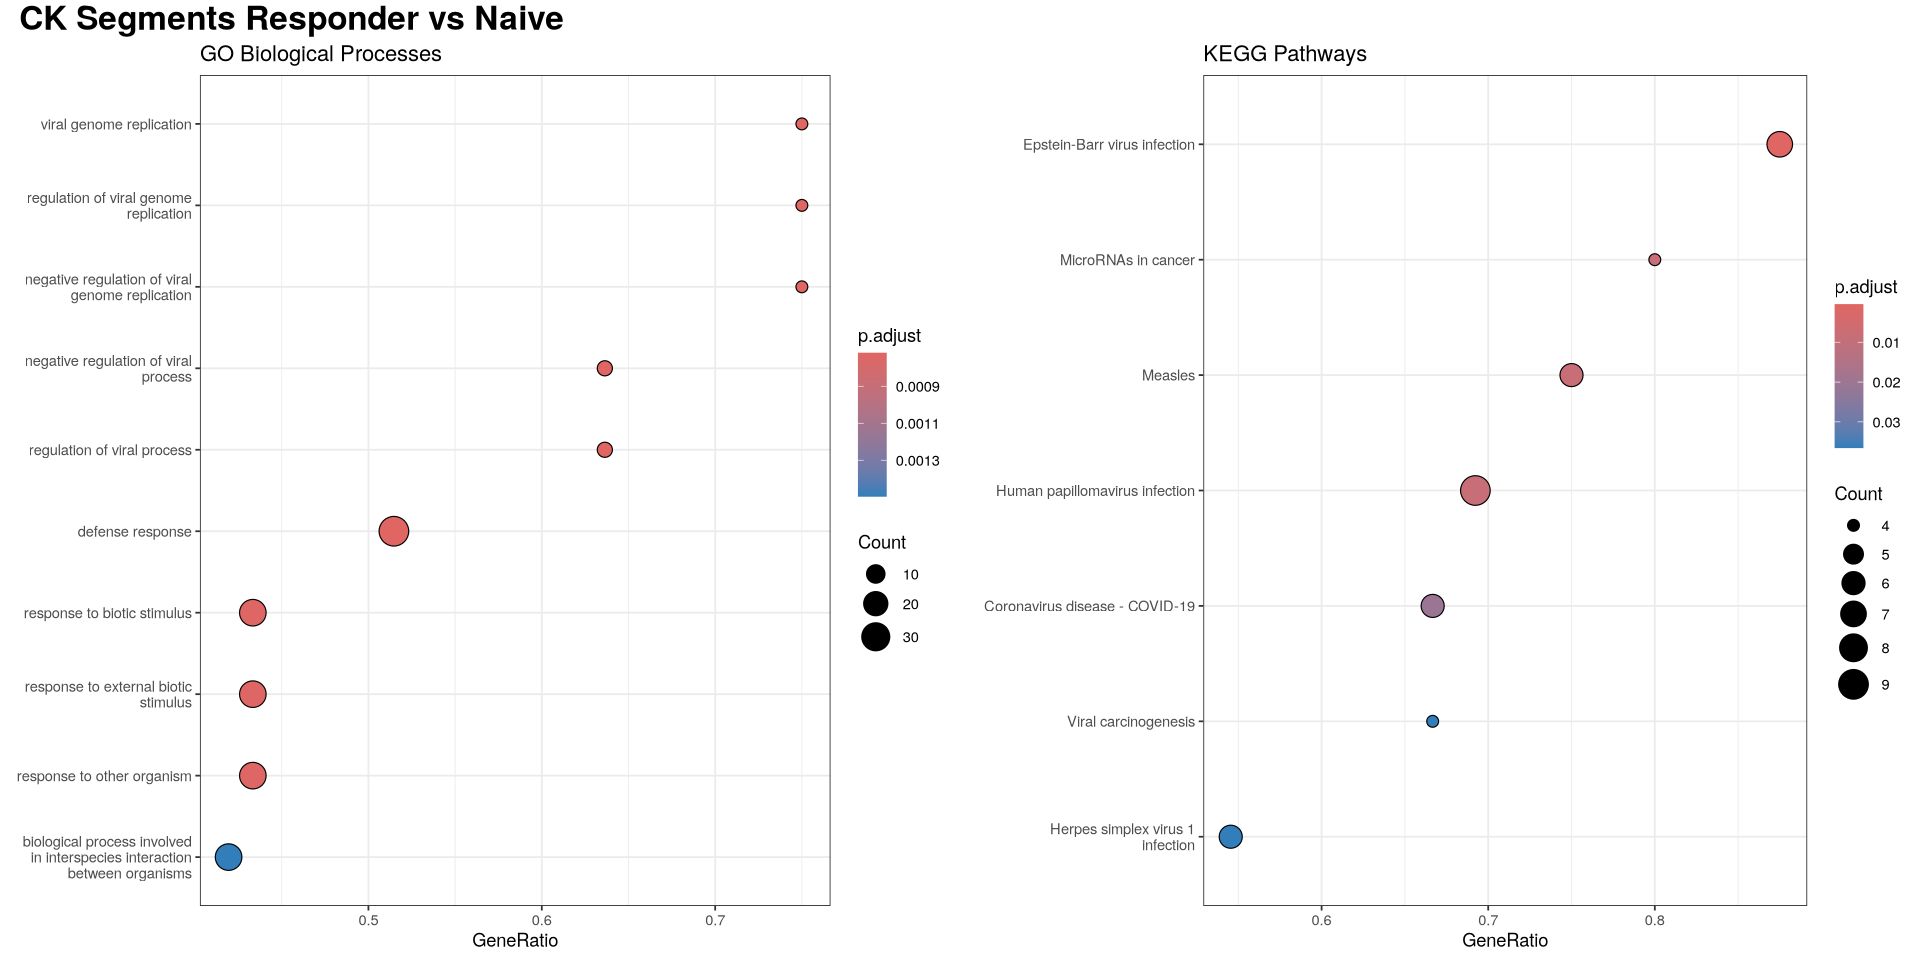

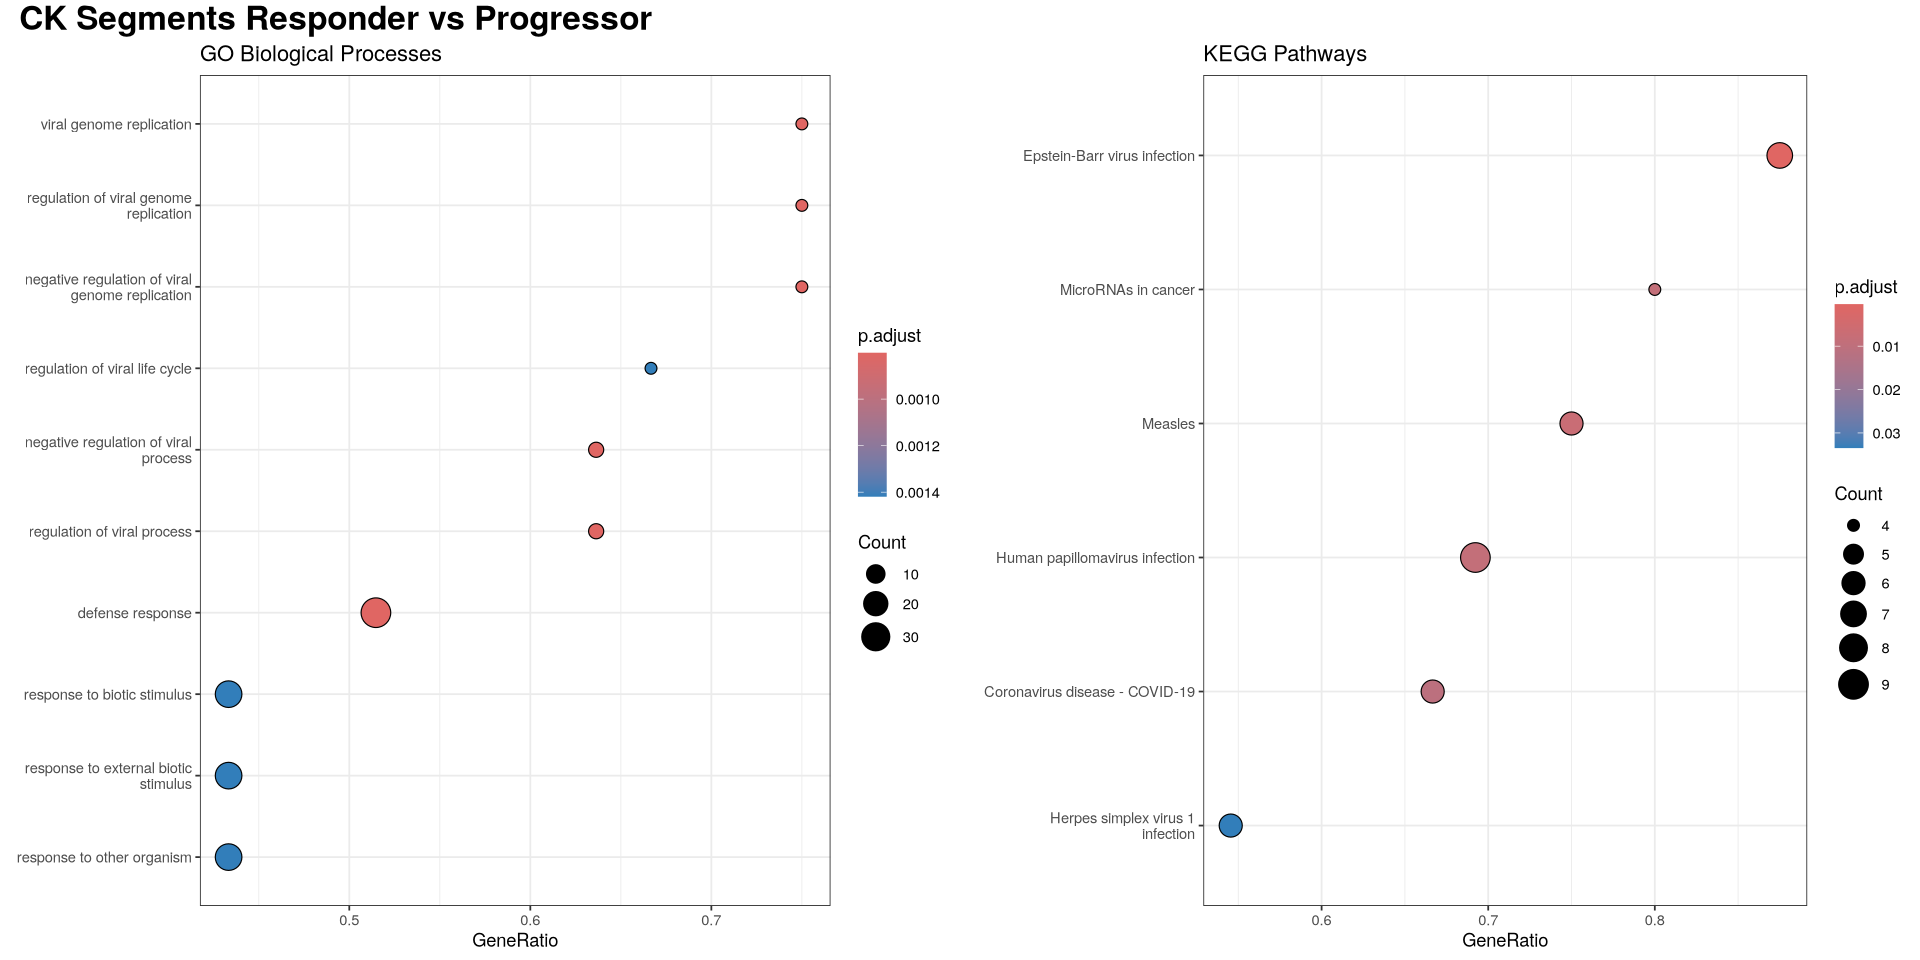

In [37]:
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Naive",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

options(repr.plot.width=16, repr.plot.height=8)
res <- topTags(ck_results$df$Responder_vs_Progressor, n = Inf)$table
genes <- top_genes(res)
plots <- enrichment_plots(genes)
grid.arrange(plots$p1,plots$p2,ncol =2 , top = textGrob("CK Segments Responder vs Progressor",  x = 0.01, y = 0.51, just = "left", gp = gpar(fontsize = 20, fontface = "bold")))

CXCL8    CXCL1     CXCL2    CXCL3    CDX1    
DSP-1001660005664-D-C10.dcc 41.01088 162.41611 48.17151 67.37502 60.21439
DSP-1001660005664-D-C11.dcc 28.79003 100.67994 35.43389 56.04687 60.81682
DSP-1001660005664-D-C12.dcc 60.25903 231.38135 63.58825 76.90517 56.59688
DSP-1001660005664-D-D02.dcc 36.09119  91.25915 41.76266 51.04325 56.71472
DSP-1001660013260-F-B06.dcc 35.47975  83.28405 60.87579 47.05736 38.46752
DSP-1001660013260-F-B09.dcc 30.32790 192.34273 60.65580 79.27819 50.01443
DSP-1001660013260-F-B12.dcc 32.51804 109.29675 51.03526 39.29263 41.55083
DSP-1001660013260-F-C03.dcc 41.43039 126.23323 55.99577 57.93781 40.13569
                            CD24      Group      apoptotic_signature
DSP-1001660005664-D-C10.dcc 265.91976 progressor 49.68951           
DSP-1001660005664-D-C11.dcc 353.82782 progressor 45.11723           
DSP-1001660005664-D-C12.dcc 263.34193 progressor 50.21667           
DSP-1001660005664-D-D02.dcc 157.77005 progressor 51.84941           
DSP-1001660013260-F-B06.dcc  60.87579 responder  54.21083           
DSP-1001660013260-F-B09.dcc  91.24973 responder  58.78313           
DSP-1001660013260-F-B12.dcc  74.97215 responder  60.53931           
DSP-1001660013260-F-C03.dcc  80.91874 responder  60.30350

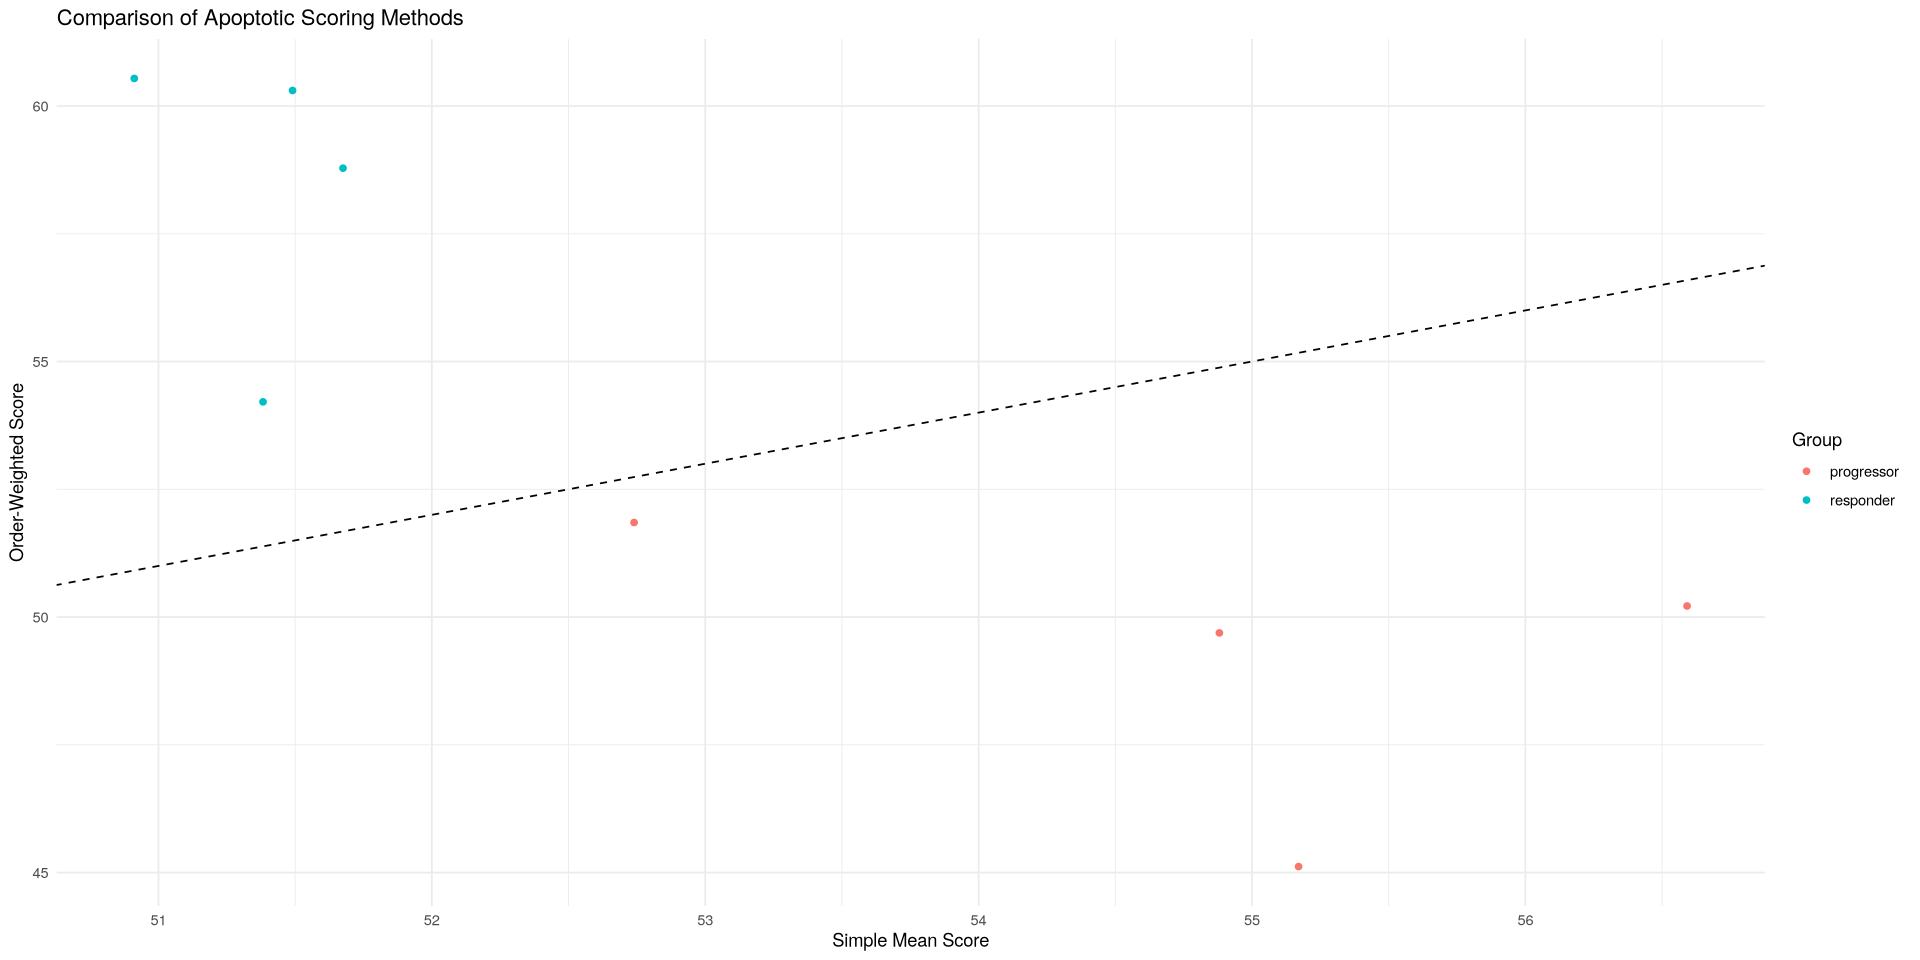

In [38]:
rna_data <- assayData(ck_subset[,pData(ck_subset)$treatment_response != 'naive'])[["q_norm"]]
annotation_df <- pData(ck_subset[,pData(ck_subset)$treatment_response != 'naive'])["treatment_response"]
annotation_df$Sample  <- rownames(annotation_df)
names(annotation_df)[1] <- "Group"
apoptotic_genes <- c("AKT3", "IRAK3", "CHP1", "CHUK", "CSF2RB", "DFFA", "DFFB", "ENDOG", "AKT1", "AKT2", "ENDOD1", "PIK3R5", "APAF1", "BIRC2", "BIRC3", "XIAP", "FAS", "IKBKB", "IL1A", "IL1B", "IL1R1", "IL1RAP", "FASLG", "IL3", "IL3RA", "IRAK1", "IRAK2", "MYD88", "ATM", "NFKB1", "NFKBIA", "NGF", "NTRK1", "IRAK4", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3CG", "PIK3R1", "PIK3R2", "CYCS", "PPP3CA", "PPP3CB", "PPP3CC", "PPP3R1", "PPP3R2", "PRKACA", "PRKACB", "PRKACG", "PRKAR1A", "PRKAR1B", "PRKAR2A", "PRKAR2B", "PRKX", "BAD", "BAX", "BCL2", "RELA", "BCL2L1", "BID", "CHP2", "", "TNF", "TNFRSF1A", "TP53", "TRAF2", "CAPN1", "CAPN2", "CASP3", "CASP6", "CASP7", "CASP8", "CASP9", "CASP10", "PIK3R3", "IKBKG", "TRADD", "RIPK1", "TNFSF10", "FADD", "TNFRSF10D", "TNFRSF10C", "TNFRSF10B", "TNFRSF10A", "CFLAR", "MAP3K14", "AIFM1", "EXOG")
genes_of_interest <- c("CXCL8", "CXCL1", "CXCL2", "CXCL3", "CDX1", "CD24")
## 1. First check which apoptotic genes are present (as before)
present_apoptotic_genes <- apoptotic_genes[apoptotic_genes %in% rownames(rna_data)]
missing_apoptotic_genes <- apoptotic_genes[!apoptotic_genes %in% rownames(rna_data)]

## 2. Create weights based on original order (earlier genes get higher weights)
# We'll use exponential decay for weights (can adjust decay rate)
original_indices <- match(present_apoptotic_genes, apoptotic_genes)
weights <- exp(-0.3 * (original_indices - 1))  # e^(-0.5*position)
weights <- weights / sum(weights)  # Normalize to sum to 1
# 3. Calculate weighted apoptotic signature score
# Get expression values for present genes (samples × genes)
apoptotic_expr <- t(rna_data[present_apoptotic_genes,])
# Calculate weighted score
annotation_df$weighted_apoptotic_score <- apply(apoptotic_expr, 1, function(x) sum(x * weights))
                                                

## 4. Compare with simple mean for reference
annotation_df$mean_apoptotic_score <- rowMeans(apoptotic_expr)

## 5. Visualize the difference between scoring methods
ggplot(annotation_df, aes(x = mean_apoptotic_score, y = weighted_apoptotic_score, color = Group)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(title = "Comparison of Apoptotic Scoring Methods",
       x = "Simple Mean Score",
       y = "Order-Weighted Score") +
  theme_minimal()


## 6. Now use the weighted score in your correlation analysis
analysis_df <- cbind(t(rna_data)[, genes_of_interest], 
                    annotation_df[, c("Group", "weighted_apoptotic_score")])

# Rename for consistency with previous code
colnames(analysis_df)[colnames(analysis_df) == "weighted_apoptotic_score"] <- "apoptotic_signature"
           analysis_df                                     


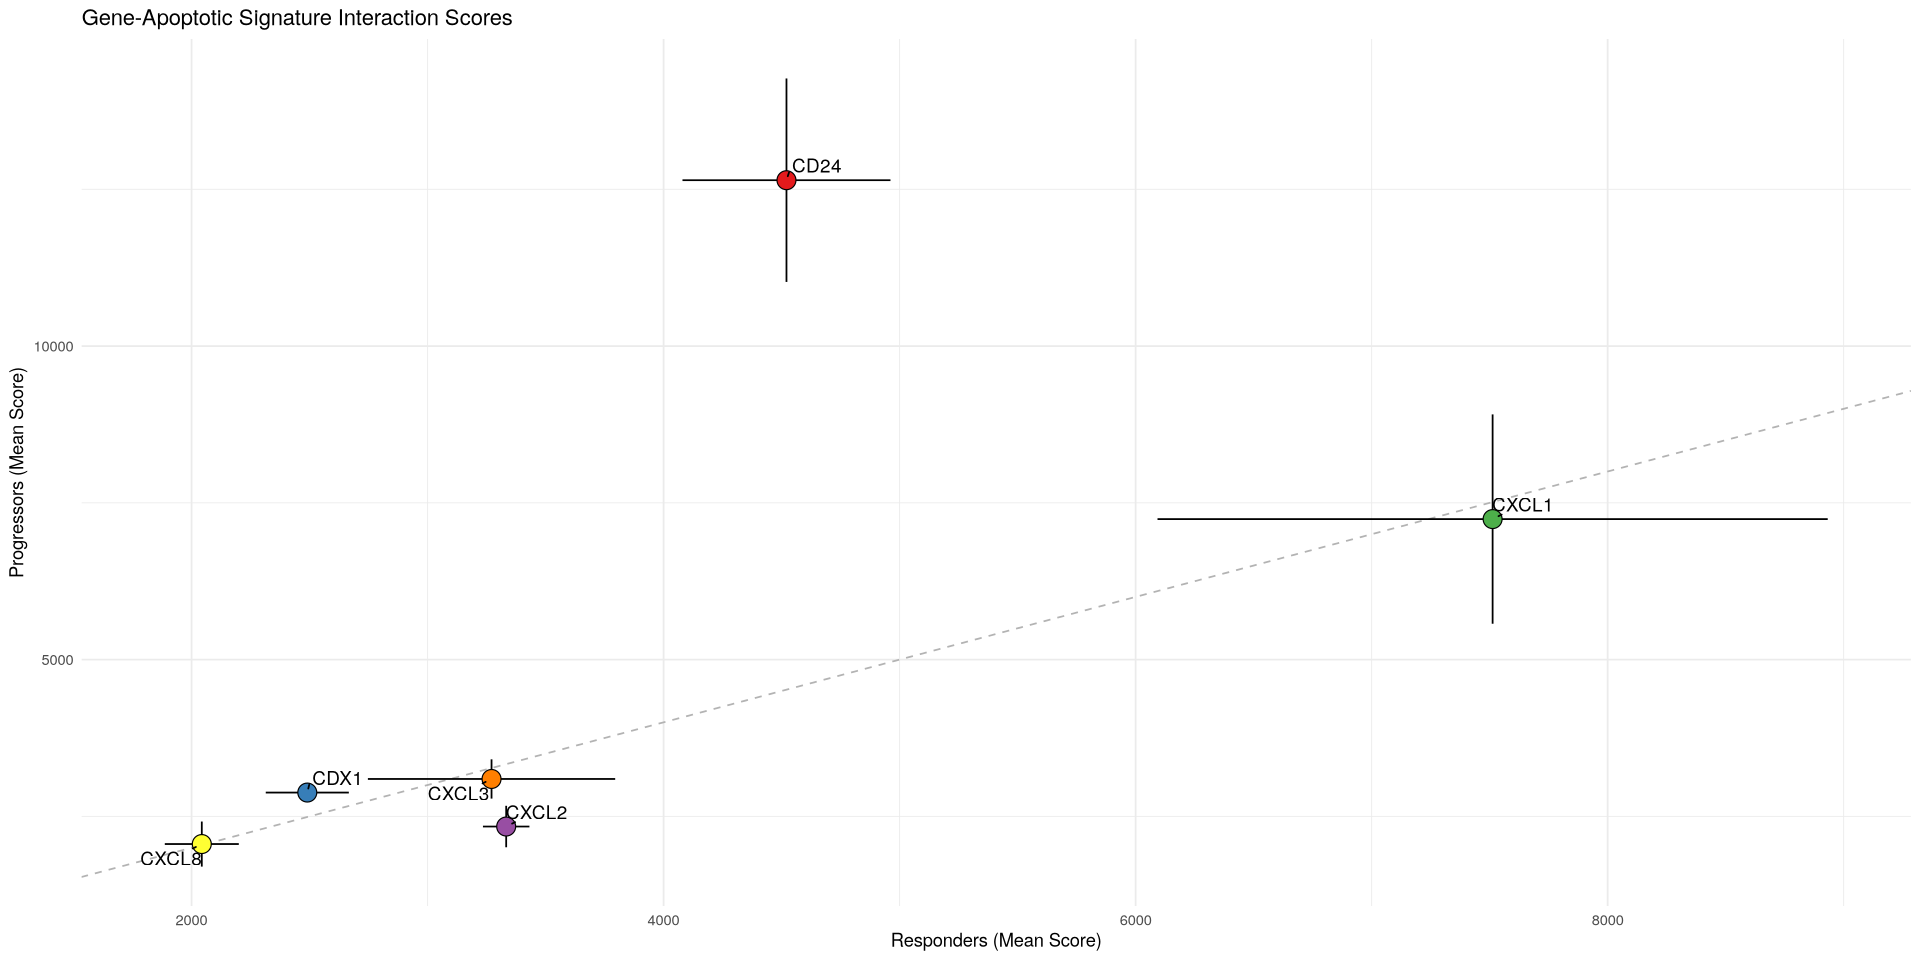

In [39]:

# 1. Prepare the data
analysis_df <- analysis_df %>%
  mutate(Group = factor(Group, levels = c("responder", "progressor")))

# 2. Calculate gene-specific apoptotic interaction scores
gene_scores <- analysis_df %>%
  pivot_longer(
    cols = c(CXCL8, CXCL1, CXCL2, CXCL3, CDX1, CD24),
    names_to = "Gene",
    values_to = "Expression"
  ) %>%
  mutate(Interaction_Score = Expression * apoptotic_signature)

# 3. Compute mean scores per group for plotting
plot_data <- gene_scores %>%
  group_by(Gene, Group) %>%
  summarise(
    Mean_Score = mean(Interaction_Score),
    SEM = sd(Interaction_Score)/sqrt(n()),
    .groups = "drop"
  ) %>%
  pivot_wider(
    names_from = Group,
    values_from = c(Mean_Score, SEM))

ggplot(plot_data, aes(x = Mean_Score_responder, y = Mean_Score_progressor)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray70") +
  geom_segment(
    aes(xend = Mean_Score_responder, yend = Mean_Score_progressor),
    color = "gray50",
    linewidth = 0.5
  ) +
  geom_errorbar(
    aes(ymin = Mean_Score_progressor - SEM_progressor,
        ymax = Mean_Score_progressor + SEM_progressor),
    width = 0,
    color = "black"
  ) +
  geom_errorbarh(
    aes(xmin = Mean_Score_responder - SEM_responder,
        xmax = Mean_Score_responder + SEM_responder),
    height = 0,
    color = "black"
  ) +
  geom_point(aes(fill = Gene), shape = 21, size = 5, color = "black") +
  geom_text_repel(
    aes(label = Gene),
    point.padding = 0.5,
    min.segment.length = 0,
    size = 4
  ) +
  labs(
    title = "Gene-Apoptotic Signature Interaction Scores",
    x = "Responders (Mean Score)",
    y = "Progressors (Mean Score)"
  ) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set1") +
  theme(legend.position = "none")

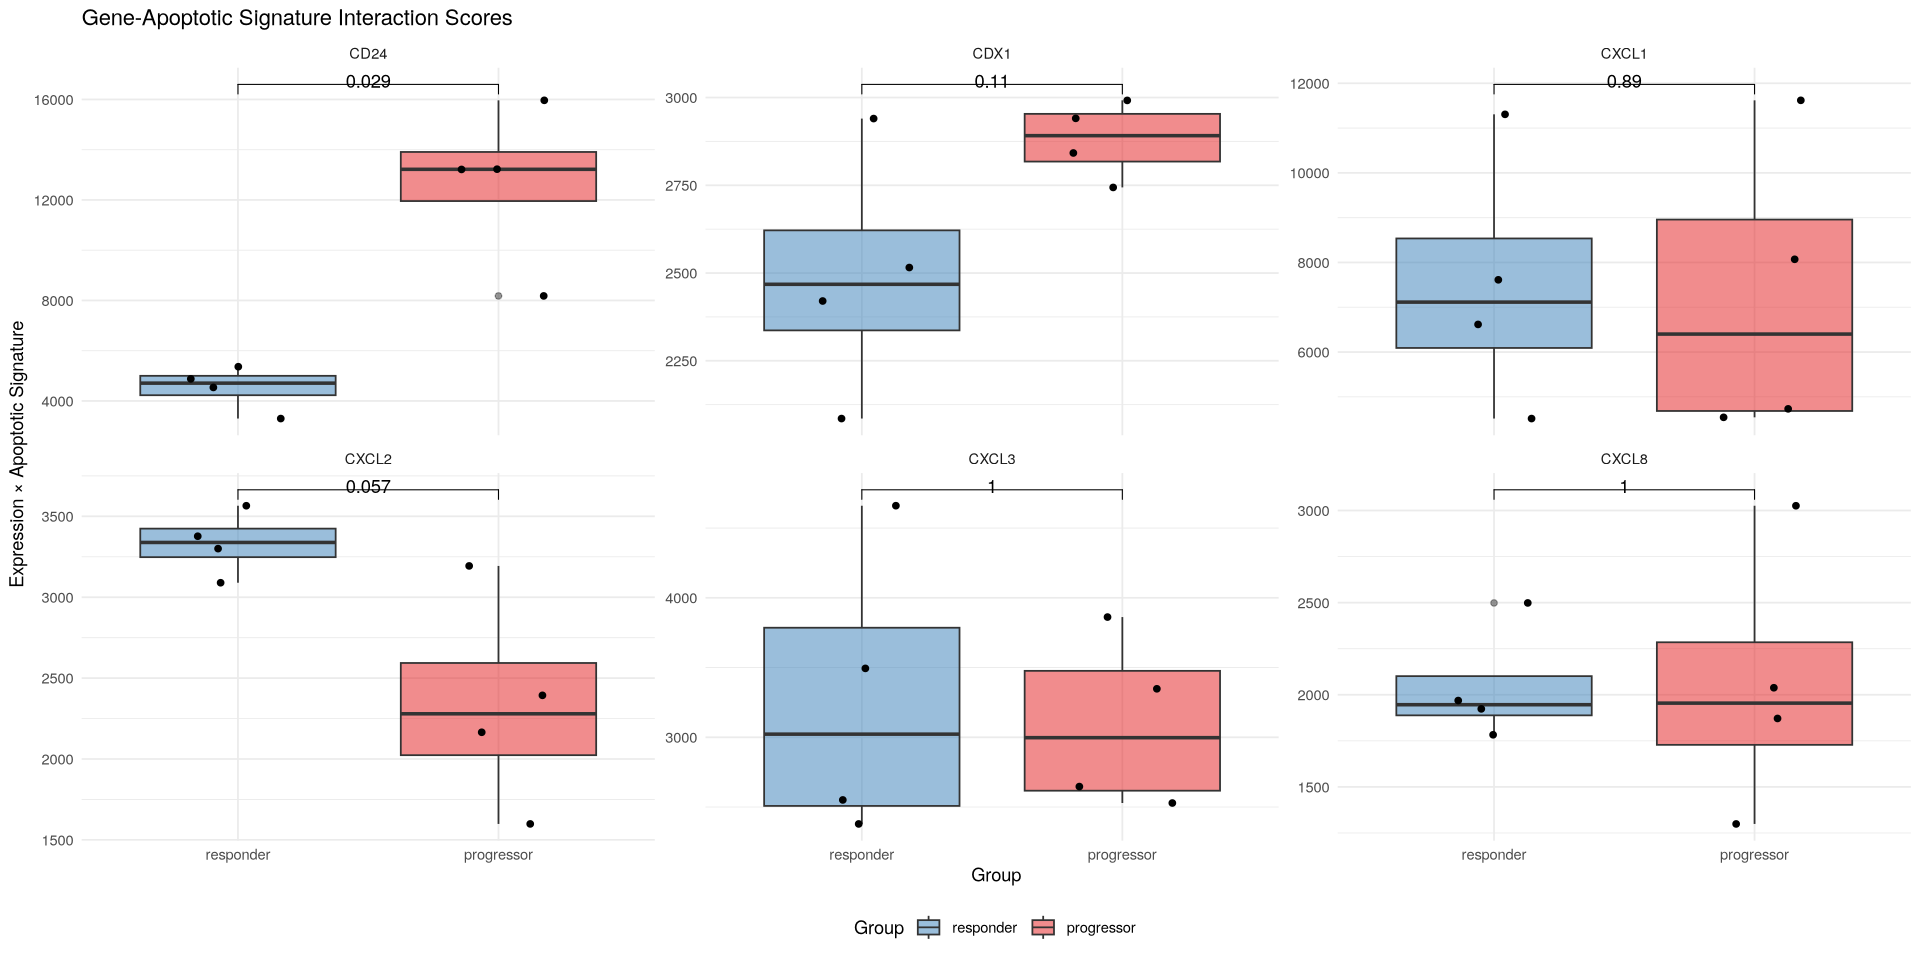

In [40]:

ggplot(gene_scores, aes(x = Group, y = Interaction_Score)) +
  geom_boxplot(aes(fill = Group), alpha = 0.5) +
  geom_jitter(width = 0.2, size = 1.5) +
  stat_compare_means(method = "wilcox.test", # or "t.test" if appropriate
                     label = "p.format", 
                     comparisons = list(c("responder", "progressor")),
                     vjust = 0.5) +
  facet_wrap(~ Gene, scales = "free_y") +
  labs(
    title = "Gene-Apoptotic Signature Interaction Scores",
    y = "Expression × Apoptotic Signature"
  ) +
  theme_minimal() +
  scale_fill_manual(values = c("responder" = "#377EB8", "progressor" = "#E41A1C")) +
  theme(legend.position = "bottom")

### Monday August 4 2025
Hi Dimitris, <br>
Thank you again for your analyses of GMX CRCs. <br>
We had a discussion with Mohamed, he mentioned that the ROIs were taken from the tumoral area, from tumor-normal border area and from the surrounding normal tissue.<br>
Did you include only the tumoral ROIs?<br>

I think we will include some of the results on CRC tumor cells in the paper.<br>
Could you please write a paragraph for the methods section.<br>
When you will write it, please specify:<br>
- The number of samples, (naïve, res, progr)
- The antibody for cancer cell staining
- The version of the GMX machine
- The pipeline reference
- The criteria for DEGs

Please also write a legend to the figures (attached). What colors mean, how significance was computed. <br>
Remove responder and CK marker plots

Kind regards,
Sergey

PS: it would fantastic if you could do this before Wednesday next week.


In [41]:
df <- readxl::read_excel("/home/dimitris/Workspace/crc/geomx_crc/annotations.xlsx")
df <- df[df$`slide name` %in% c('21H03592-11 metastase #1 13-10-22','21H09328.13 COLON METASTASE 13.09.22','21H05698-33 Meta#4 06-10-22'),]
table(df[,c('location','segment')])

             segment
location      CD45 CD68 CK
  border         0    4  0
  extra-tumor    0    2  0
  intra-tumor   10   10 12

In [42]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Fedora Linux 42 (Workstation Edition)

Matrix products: default
BLAS/LAPACK: /home/dimitris/Workspace/miniconda/envs/r_env/lib/libopenblasp-r0.3.29.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Athens
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] kableExtra_1.4.0            readODS_2.3.2              
 [3] ggrepel_0.9.6               cowplot_1.1.3              
 [5] ggpubr_0.6.1                RColorBrewer_1.1-3       